# IMPORTS

In [ ]:
!pip install pydicom
!pip install nibabel

import os

import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import pydicom
import tensorflow as tf
import torch
import random

from google.colab import drive, files
from ipywidgets import interact, IntSlider
from torch import nn, optim
from torch.nn import BCELoss
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import Dataset, DataLoader
import gc
import torch.optim as optim
from tqdm import tqdm
from google.colab import drive
from scipy.ndimage import affine_transform


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 71.5 MB/s eta 0:00:00


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

drive.mount('/content/drive')
drive_dir = '/content/drive/MyDrive/lung'
data_folders = [os.path.join(drive_dir, f) for f in os.listdir(drive_dir) if os.path.isdir(os.path.join(drive_dir, f))]
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Mounted at /content/drive


# MODEL

In [ ]:
class DownCNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, use_padding=False):
        super(DownCNNBlock, self).__init__()
        padding = 1 if use_padding else 0

        # Two 3x3x3 convolutional layers with ReLU activation
        self.conv1 = nn.Conv3d(in_channels, out_channels, kernel_size=(3, 3, 3), padding=padding)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv3d(out_channels, out_channels, kernel_size=(3, 3, 3), padding=padding)
        self.relu2 = nn.ReLU()

        # 2x2x2 max pooling for downsampling
        self.pooling = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=2)

    def forward(self, input):
        # print("DownCNNBLOCK")
        res = self.relu1(self.conv1(input))
        res = self.relu2(self.conv2(res))
        out = self.pooling(res)
        return out, res

class UpCNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, last_layer=False):
        super(UpCNNBlock, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels

        # 2x2x2 transposed convolution for upsampling
        self.upconv = nn.ConvTranspose3d(in_channels - out_channels, in_channels - out_channels, kernel_size=(2, 2, 2), stride=2)
        self.finalUpconv = nn.ConvTranspose3d(in_channels, in_channels, kernel_size=(2, 2, 2), stride=2)

        # Two 3x3x3 convolutional layers with ReLU activation
        self.conv1 = nn.Conv3d(in_channels + out_channels, out_channels, kernel_size=(3, 3, 3), padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv3d(out_channels, out_channels, kernel_size=(3, 3, 3), padding=1)
        self.relu2 = nn.ReLU()
        self.conv1Final = nn.Conv3d(in_channels + in_channels, out_channels, kernel_size=(3, 3, 3), padding=1)

        # Flag to indicate if this is the last layer
        self.last_layer = last_layer

        # If it's the last layer, add a 1x1x1 convolution and sigmoid activation
        self.conv3 = nn.Conv3d(out_channels, 1, kernel_size=(1, 1, 1))
        self.sigmoid = nn.Sigmoid()

    def forward(self, input, residual=None):
        # Apply transposed convolution for upsampling
        if self.out_channels == 1:
            out = self.finalUpconv(input)
        else:
            out = self.upconv(input)
        if residual is not None:
            if len(out.shape) == 4:
                out = torch.cat((out, residual), dim=0)
            else:
              out = torch.cat((out, residual), dim=1)

        # Apply convolutions and activations
        if self.out_channels == 1:
            out = self.conv1Final(out)
        else:
            out = self.relu1(self.conv1(out))

        out = self.relu2(self.conv2(out))
        # Apply final convolution and sigmoid if it's the last layer
        if self.last_layer:
            out = self.conv3(out)
            out = self.sigmoid(out)
        return out


class UNet3D(nn.Module):
    def __init__(self, in_channels, level_channels=[16, 32, 64, 128, 256]):
        super(UNet3D, self).__init__()
        self.a_block1 = DownCNNBlock(in_channels, level_channels[0], use_padding=True)
        self.a_block2 = DownCNNBlock(level_channels[0], level_channels[1], use_padding=True)
        self.a_block3 = DownCNNBlock(level_channels[1], level_channels[2], use_padding=True)
        self.a_block4 = DownCNNBlock(level_channels[2], level_channels[3], use_padding=True)
        self.a_block5 = DownCNNBlock(level_channels[3], level_channels[4], use_padding=True)

        self.s_block5 = UpCNNBlock(level_channels[4] + level_channels[3], level_channels[3])
        self.s_block4 = UpCNNBlock(level_channels[3] + level_channels[2], level_channels[2])
        self.s_block3 = UpCNNBlock(level_channels[2] + level_channels[1], level_channels[1])
        self.s_block2 = UpCNNBlock(level_channels[1] + level_channels[0], level_channels[0])
        self.s_block1 = UpCNNBlock(level_channels[0], in_channels, last_layer=True)

    def forward(self, input):
        out1, res1 = self.a_block1(input)
        out2, res2 = self.a_block2(out1)
        out3, res3 = self.a_block3(out2)
        out4, res4 = self.a_block4(out3)
        out5, res5 = self.a_block5(out4)

        out = self.s_block5(out5, res5)
        out = self.s_block4(out, res4)
        out = self.s_block3(out, res3)
        out = self.s_block2(out, res2)
        out = self.s_block1(out, res1)
        return out

In [ ]:
def dice_loss(prediction, target, smooth=1e-5):
    prediction = prediction.view(-1)
    target = target.view(-1)

    intersection = (prediction * target).sum()
    union = prediction.sum() + target.sum()

    dice = (2. * intersection + smooth) / (union + smooth)

    return 1.0 - dice

# DATA PROCESSING

## Cache Dataset

In [ ]:
class DICOMCacheDataset():
    def __init__(self, data_folders, cache_dir='numpy_dicom_images'):
        self.data_folders = data_folders
        self.cache_dir = cache_dir

    def __len__(self):
        return len(self.scans)

    def load_and_cache_volumes(self, input_dir, mask_path):
        folder_name = os.path.basename(os.path.dirname(input_dir))
        input_cache_path = os.path.join(self.cache_dir, folder_name + "/input.pt")
        mask_cache_path = os.path.join(self.cache_dir, folder_name + "/mask.pt")

        if os.path.exists(input_cache_path) and os.path.exists(mask_cache_path):
            # print(f"Loading volumes from cache for {input_dir}...")
            with open(input_cache_path, 'rb') as f:
                input_volume = torch.load(f, map_location=torch.device('cpu'), weights_only=True)
            with open(mask_cache_path, 'rb') as f:
                mask_volume = torch.load(f, map_location=torch.device('cpu'), weights_only=True)
        else:
            # print(f"Loading volumes from source and caching for {input_dir}...")
            dcm_files = [os.path.join(input_dir, f) for f in os.listdir(input_dir) if f.endswith('.dcm')]
            dcm_files.sort(key=lambda f: pydicom.dcmread(f).SliceLocation)
            input_volume = []

            for file_path in tqdm(dcm_files, desc="Loading DICOM files"):
                ds = pydicom.dcmread(file_path)
                input_volume.append(ds.pixel_array)
            input_volume = np.stack(input_volume, axis=0)

            mask_volume = nib.load(mask_path).get_fdata()
            mask_volume = np.asarray(mask_volume)
            mask_volume = np.rot90(mask_volume, k=1, axes=(0, 1))
            mask_volume = np.flip(mask_volume, axis=0)
            mask_volume = np.moveaxis(mask_volume, -1, 0)

            os.makedirs(os.path.dirname(input_cache_path), exist_ok=True)
            os.makedirs(os.path.dirname(mask_cache_path), exist_ok=True)

            input_volume = torch.from_numpy(input_volume).float()
            mask_volume = torch.from_numpy(mask_volume).float()

            torch.save(input_volume, input_cache_path)
            torch.save(mask_volume, mask_cache_path)
        return input_volume, mask_volume

    def get_volume(self, input_dir, mask_path):
        folder_name = os.path.basename(os.path.dirname(input_dir))
        input_cache_path = os.path.join(self.cache_dir, folder_name + "/input.pt")
        mask_cache_path = os.path.join(self.cache_dir, folder_name + "/mask.pt")
        if os.path.exists(input_cache_path) and os.path.exists(mask_cache_path):
            with open(input_cache_path, 'rb') as f:
                input_volume = torch.load(f, map_location=torch.device('cpu'), weights_only=True)
            with open(mask_cache_path, 'rb') as f:
                mask_volume = torch.load(f, map_location=torch.device('cpu'), weights_only=True)
            return input_volume, mask_volume
        else:
            return self.load_and_cache_volumes(input_dir, mask_path)

## Patch Loader

In [ ]:
class GPUPatchLoader(Dataset):
    def __init__(self, data_folders, patches_per_vol=8, patch_size=256, cache_dir='numpy_dicom_images'):
        self.patches_per_vol = patches_per_vol
        self.patch_size = patch_size
        self.cache = DICOMCacheDataset(data_folders, cache_dir)
        self.data = data_folders

    def __len__(self):
        return len(self.data) * self.patches_per_vol

    def __getitem__(self, idx):
        if idx == 101:
            input_dir = '/content/drive/MyDrive/lung/1.3.6.1.4.1.14519.5.2.1.6279.6001.221945191226273284587353530424/Input'
            mask_path = '/content/drive/MyDrive/lung/1.3.6.1.4.1.14519.5.2.1.6279.6001.221945191226273284587353530424/Mask/1.3.6.1.4.1.14519.5.2.1.6279.6001.221945191226273284587353530424.nii.gz'
            example_volume, example_volume_mask = self.cache.load_and_cache_volumes(input_dir, mask_path)
            example_volume, example_volume_mask = self.crop_to_lung_bounds(example_volume, example_volume_mask)
            example_patch, example_mask = self.get_patch(example_volume, example_volume_mask, (216,0,75))
            return example_patch, example_mask

        volume_idx = idx // self.patches_per_vol
        input_dir = os.path.join(self.data[volume_idx], 'Input')
        mask_path = os.path.join(self.data[volume_idx], 'Mask', os.listdir(os.path.join(self.data[volume_idx], 'Mask'))[0])

        input_volume, mask_volume = self.cache.load_and_cache_volumes(input_dir, mask_path)
        input_volume, mask_volume = self.crop_to_lung_bounds(input_volume, mask_volume)
        input_patch, mask_patch = self.get_patch(input_volume, mask_volume)
        input_patch, mask_patch = self.augment_patch(input_patch, mask_patch)
        return input_patch, mask_patch

    def calculate_lung_bounding_box(self, mask_volume):
        nonzero_indices = torch.nonzero(mask_volume)

        min_d, min_h, min_w = nonzero_indices.min(dim=0).values
        max_d, max_h, max_w = nonzero_indices.max(dim=0).values

        buffer_size = 30
        min_d = max(0, min_d - buffer_size)
        min_h = max(0, min_h - buffer_size)
        min_w = max(0, min_w - buffer_size)
        max_d = min(mask_volume.shape[0] - 1, max_d + buffer_size)
        max_h = min(mask_volume.shape[1] - 1, max_h + buffer_size)
        max_w = min(mask_volume.shape[2] - 1, max_w + buffer_size)
        return min_d, min_h, min_w, max_d, max_h, max_w

    def crop_to_lung_bounds(self, volume, mask_volume):
        min_d, min_h, min_w, max_d, max_h, max_w = self.calculate_lung_bounding_box(mask_volume)
        cropped_volume = volume[min_d:max_d+1, min_h:max_h+1, min_w:max_w+1]
        cropped_mask = mask_volume[min_d:max_d+1, min_h:max_h+1, min_w:max_w+1]
        return cropped_volume, cropped_mask

    def get_patch(self, input_volume, mask_volume, coords=None):
        patch_size = self.patch_size
        if coords is None:
            valid_d = input_volume.shape[0] - patch_size
            valid_h = input_volume.shape[1] - patch_size
            valid_w = input_volume.shape[2] - patch_size

            d = torch.randint(0, max(1, valid_d + 1), (1,)).item()
            h = torch.randint(0, max(1, valid_h + 1), (1,)).item()
            w = torch.randint(0, max(1, valid_w + 1), (1,)).item()
        else:
            d, h, w = coords
        input_patch = input_volume[d:d + patch_size, h:h + patch_size, w:w + patch_size]
        mask_patch = mask_volume[d:d + patch_size, h:h + patch_size, w:w + patch_size]

        pad_d = max(0, patch_size - input_volume.shape[0])
        pad_h = max(0, patch_size - input_volume.shape[1])
        pad_w = max(0, patch_size - input_volume.shape[2])

        padding = (0, pad_w, 0, pad_h, 0, pad_d)
        input_patch = torch.nn.functional.pad(input_patch, padding, mode='constant', value=0)
        mask_patch = torch.nn.functional.pad(mask_patch, padding, mode='constant', value=0)

        input_patch = input_patch.unsqueeze(0)
        mask_patch = mask_patch.unsqueeze(0)

        return input_patch, mask_patch

    def augment_patch(self, input_patch, mask_patch, augmentation_type="r'"):
        augmentations = [
                ("n", 0.1),
                ("f", 0.3),
                ("rt", 0.3),
                ("s", 0.3)]
        if augmentation_type == "r":
            aug_names, probabilities = zip(*augmentations)
            choice = random.choices(aug_names, probabilities, k=1)[0]
        else:
            choice = augmentation_type
        if choice == "n":
            print("nothing")
            pass
        elif choice == "f":
            print("flipping")
            axis = torch.randint(1, 4, [1,]).item()
            input_patch = torch.flip(input_patch, dims=[axis])
            mask_patch = torch.flip(mask_patch, dims=[axis])
        elif choice == "rt":
            print("rotating")
            angle = torch.rand(1).item() * 20 - 10
            angle_rad = np.deg2rad(angle)
            rotation_matrix = np.array([[1, 0, 0],
                                        [0, np.cos(angle_rad), -np.sin(angle_rad)],
                                        [0, np.sin(angle_rad), np.cos(angle_rad)]])

            input_patch_np = input_patch.squeeze(0).numpy()
            input_patch_rotated = affine_transform(input_patch_np, rotation_matrix,
                                                    order=3, mode='constant', cval=0.0)
            input_patch = torch.from_numpy(input_patch_rotated).unsqueeze(0)

            mask_patch_np = mask_patch.squeeze(0).numpy()
            mask_patch_rotated = affine_transform(mask_patch_np, rotation_matrix,
                                                  order=0, mode='constant', cval=0.0)
            mask_patch = torch.from_numpy(mask_patch_rotated).unsqueeze(0)
        elif choice == "s":
            print("scaling")
            scale = 0.75 + torch.rand(1).item() * 0.5
            new_size = int(self.patch_size * scale)
            input_patch = torch.nn.functional.interpolate(
                input_patch.unsqueeze(0),
                size=(new_size, new_size, new_size),
                mode='trilinear',
                align_corners=True).squeeze(0)
            mask_patch = torch.nn.functional.interpolate(
                mask_patch.unsqueeze(0),
                size=(new_size, new_size, new_size),
                mode='nearest').squeeze(0)

            if new_size > self.patch_size:
                diff = new_size - self.patch_size
                start = diff // 2
                input_patch = input_patch[:, start:start+self.patch_size,
                                        start:start+self.patch_size,
                                        start:start+self.patch_size]
                mask_patch = mask_patch[:, start:start+self.patch_size,
                                      start:start+self.patch_size,
                                      start:start+self.patch_size]
            else:
                diff = self.patch_size - new_size
                pad = diff // 2
                input_patch = torch.nn.functional.pad(input_patch, (pad, pad, pad, pad, pad, pad))
                mask_patch = torch.nn.functional.pad(mask_patch, (pad, pad, pad, pad, pad, pad))

        # If none of the above (probability = none), return original patches
        return input_patch, mask_patch

def visualize_patch(input_patch, mask_patch, slice_index=64):
    plt.clf()
    fig, axes = plt.subplots(1, 2, figsize=(6, 5))

    input_patch_np = input_patch[0][slice_index].cpu().numpy()
    axes[0].imshow(input_patch_np, cmap='gray')
    axes[0].set_title(f"Input Patch Slice {slice_index}")
    del input_patch_np

    mask_patch_np = mask_patch[0][slice_index].cpu().numpy()
    axes[1].imshow(mask_patch_np, cmap='gray')
    axes[1].set_title(f"Mask Patch Slice {slice_index}")
    del mask_patch_np

    plt.show()
    plt.close()

# TEST CACHE / LOADER

## Test CacheDataset

Loading DICOM files: 100%|██████████| 471/471 [00:01<00:00, 265.05it/s]


Input Volume Shape: torch.Size([471, 512, 512])
Mask Volume Shape: torch.Size([471, 512, 512])


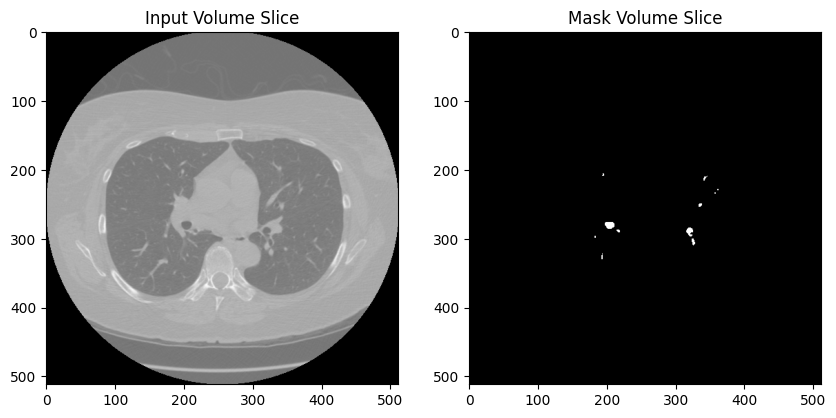

Cached Input Volume Shape: torch.Size([471, 512, 512])
Cached Mask Volume Shape: torch.Size([471, 512, 512])


In [ ]:
cache_dataset = DICOMCacheDataset(data_folders)

# Select a specific volume for testing
input_dir = os.path.join(data_folders[0], 'Input')
mask_path = os.path.join(data_folders[0], 'Mask', os.listdir(os.path.join(data_folders[0], 'Mask'))[0])

# Load the volume and mask using the cache
input_volume, mask_volume = cache_dataset.load_and_cache_volumes(input_dir, mask_path)

# Print the shapes to check if they are loaded correctly
print("Input Volume Shape:", input_volume.shape)
print("Mask Volume Shape:", mask_volume.shape)

# Visualize a slice of the input and mask
slice_index = 256  # Adjust as needed
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(input_volume[slice_index].cpu().numpy(), cmap='gray')
plt.title("Input Volume Slice")
plt.subplot(1, 2, 2)
plt.imshow(mask_volume[slice_index].cpu().numpy(), cmap='gray')
plt.title("Mask Volume Slice")
plt.show()

# Test loading from cache
input_volume_cached, mask_volume_cached = cache_dataset.get_volume(input_dir, mask_path)

# Compare shapes to ensure they match the original loaded volumes
print("Cached Input Volume Shape:", input_volume_cached.shape)
print("Cached Mask Volume Shape:", mask_volume_cached.shape)

## Test GPU Patch Loader

In [ ]:
patch_loader = GPUPatchLoader(data_folders[25], patches_per_vol=1, patch_size=256)
input_dir = os.path.join(data_folders[25], 'Input')
mask_path = os.path.join(data_folders[25], 'Mask', os.listdir(os.path.join(data_folders[25], 'Mask'))[0])
input_volume, mask_volume = patch_loader.cache.load_and_cache_volumes(input_dir, mask_path)

Loading DICOM files: 100%|██████████| 682/682 [00:02<00:00, 238.36it/s]


### crop_to_lung_bounds

<Figure size 640x480 with 0 Axes>

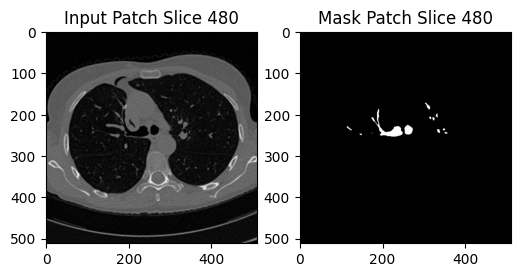

<Figure size 640x480 with 0 Axes>

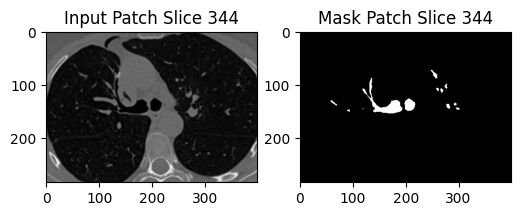

torch.Size([546, 284, 400])


In [ ]:
test_idx = 480
visualize_patch(input_volume.unsqueeze(0), mask_volume.unsqueeze(0), slice_index=test_idx)  # Assuming visualize_patch handles volumes
cropped_volume, mask_cropped = patch_loader.crop_to_lung_bounds(input_volume, mask_volume)
min_d, _, _, _, _, _ = patch_loader.calculate_lung_bounding_box(mask_volume) # get bounding box minimal value to calculate slice index
new_slice_index = min(test_idx - min_d.item(), cropped_volume.shape[0] -1)
visualize_patch(cropped_volume.unsqueeze(0), mask_cropped.unsqueeze(0), slice_index=new_slice_index)
print(cropped_volume.shape)

### get_patch

<Figure size 640x480 with 0 Axes>

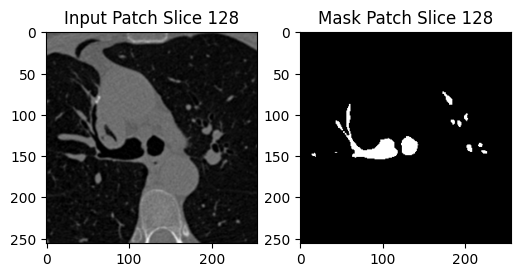

In [ ]:
input_patch, mask_patch = patch_loader.get_patch(cropped_volume, mask_cropped, (216,0,75))
visualize_patch(input_patch, mask_patch, slice_index=128)

### augment_patch

scaling


<Figure size 640x480 with 0 Axes>

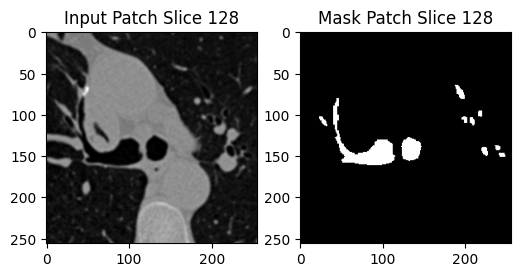

In [ ]:
aug_input, aug_mask = patch_loader.augment_patch(input_patch, mask_patch, augmentation_type="s")
visualize_patch(aug_input, aug_mask, slice_index=128)

# TRAINING

In [ ]:
dummy_patch_loader = GPUPatchLoader(data_folders, patches_per_vol=1, patch_size=256)
for i in range(len(dummy_patch_loader)):
    print(f"loading in data[{i}]")
    input_patch, mask_patch = dummy_patch_loader[i]
    del input_patch
    del mask_patch
del dummy_patch_loader
gc.collect()
# !zip -r /content/file.zip /content/numpy_dicom_images
# files.download("/content/file.zip")

loading in data[0]
loading in data[1]


Loading DICOM files: 100%|██████████| 458/458 [00:01<00:00, 261.99it/s]


loading in data[2]


Loading DICOM files: 100%|██████████| 413/413 [00:01<00:00, 278.80it/s]


loading in data[3]


Loading DICOM files: 100%|██████████| 538/538 [00:02<00:00, 261.89it/s]


loading in data[4]


Loading DICOM files: 100%|██████████| 633/633 [00:02<00:00, 277.15it/s]


loading in data[5]


Loading DICOM files: 100%|██████████| 548/548 [00:01<00:00, 276.04it/s]


loading in data[6]


Loading DICOM files: 100%|██████████| 509/509 [00:02<00:00, 252.94it/s]


loading in data[7]


Loading DICOM files: 100%|██████████| 458/458 [00:01<00:00, 266.27it/s]


loading in data[8]


Loading DICOM files: 100%|██████████| 449/449 [00:01<00:00, 268.33it/s]


loading in data[9]


Loading DICOM files: 100%|██████████| 588/588 [00:02<00:00, 248.18it/s]


loading in data[10]


Loading DICOM files: 100%|██████████| 506/506 [00:01<00:00, 257.98it/s]


loading in data[11]


Loading DICOM files: 100%|██████████| 561/561 [00:02<00:00, 273.07it/s]


loading in data[12]


Loading DICOM files: 100%|██████████| 401/401 [00:01<00:00, 267.92it/s]


loading in data[13]


Loading DICOM files: 100%|██████████| 519/519 [00:01<00:00, 265.87it/s]


loading in data[14]


Loading DICOM files: 100%|██████████| 672/672 [00:02<00:00, 249.40it/s]


loading in data[15]


Loading DICOM files: 100%|██████████| 529/529 [00:01<00:00, 265.22it/s]


loading in data[16]


Loading DICOM files: 100%|██████████| 484/484 [00:01<00:00, 272.49it/s]


loading in data[17]


Loading DICOM files: 100%|██████████| 509/509 [00:01<00:00, 272.92it/s]


loading in data[18]


Loading DICOM files: 100%|██████████| 567/567 [00:02<00:00, 279.61it/s]


loading in data[19]


Loading DICOM files: 100%|██████████| 730/730 [00:02<00:00, 257.19it/s]


loading in data[20]


Loading DICOM files: 100%|██████████| 474/474 [00:01<00:00, 247.82it/s]


loading in data[21]


Loading DICOM files: 100%|██████████| 477/477 [00:01<00:00, 264.16it/s]


loading in data[22]


Loading DICOM files: 100%|██████████| 477/477 [00:01<00:00, 276.74it/s]


loading in data[23]


Loading DICOM files: 100%|██████████| 449/449 [00:01<00:00, 259.67it/s]


loading in data[24]


Loading DICOM files: 100%|██████████| 636/636 [00:02<00:00, 249.65it/s]


loading in data[25]


21818

## epochs till 90

Epoch 1/1000: 100%|██████████| 100/100 [01:58<00:00,  1.19s/it]


Epoch [1/1000], Loss: 0.9071425801515579


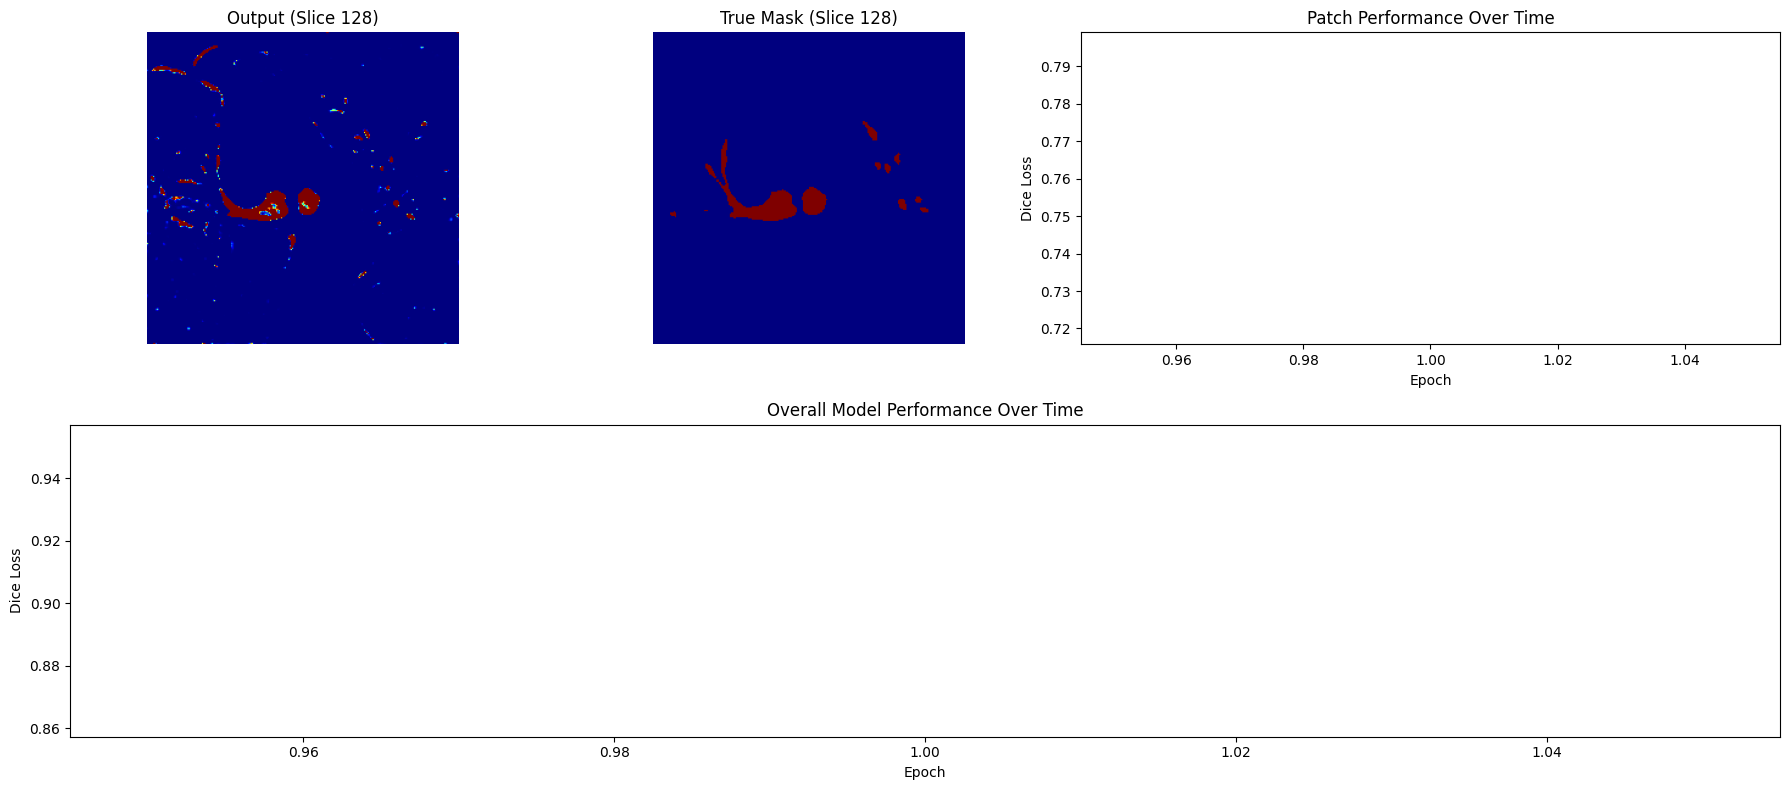

Checkpoint saved at epoch 1 to /content/drive/MyDrive/MyCheckpoints/model_epoch_1.pth


Epoch 11/1000: 100%|██████████| 100/100 [01:54<00:00,  1.14s/it]


Epoch [11/1000], Loss: 0.6440367156267166


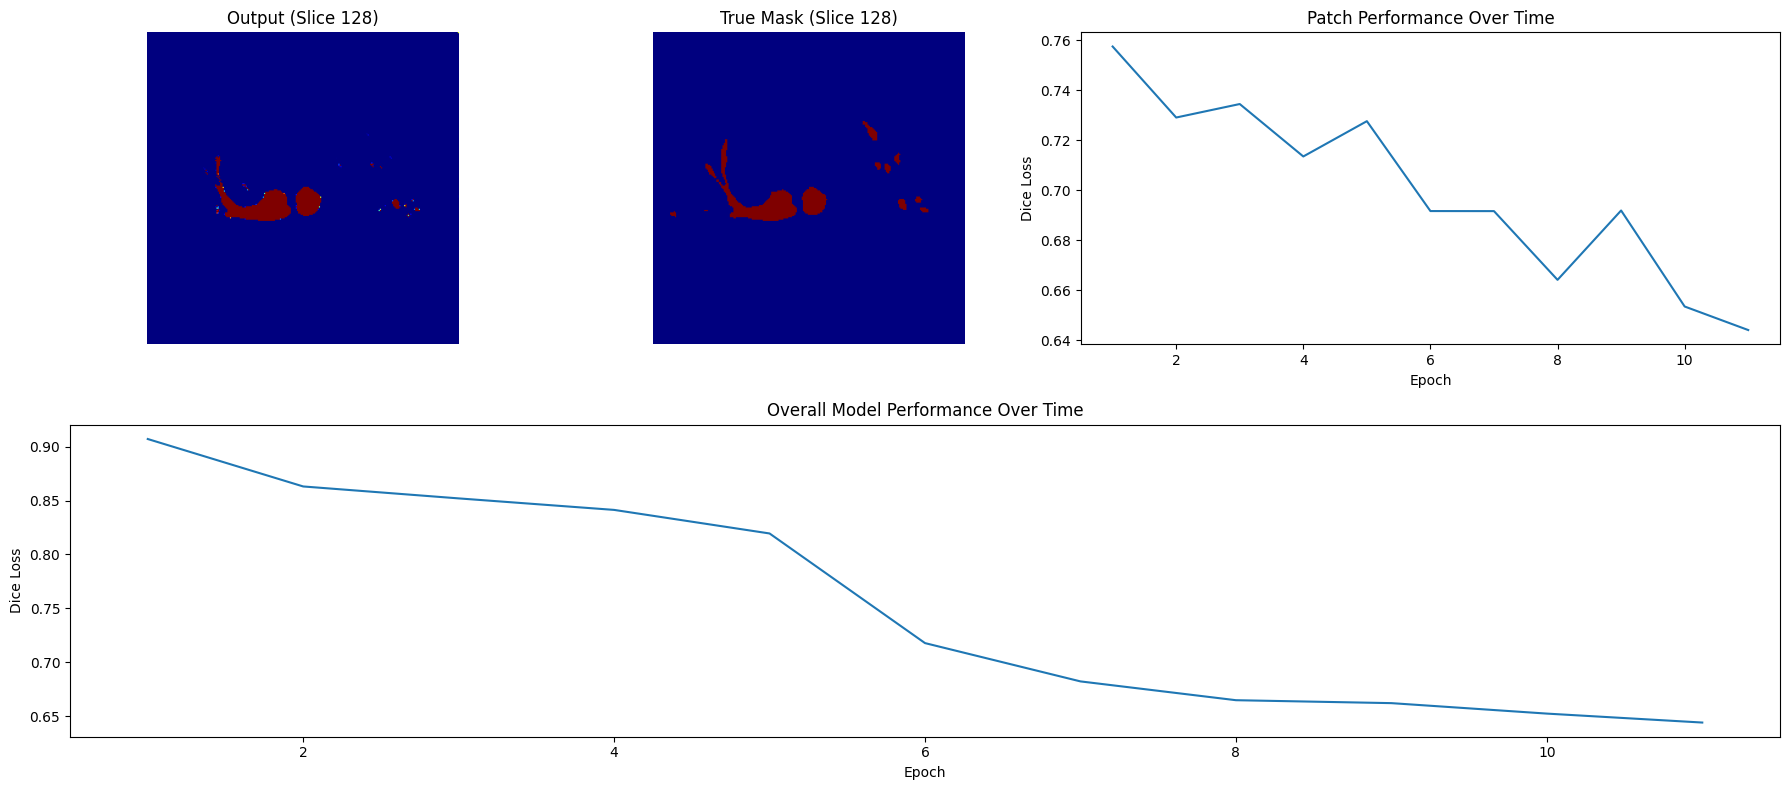

Checkpoint saved at epoch 11 to /content/drive/MyDrive/MyCheckpoints/model_epoch_11.pth


Epoch 21/1000: 100%|██████████| 100/100 [01:53<00:00,  1.14s/it]


Epoch [21/1000], Loss: 0.5898550641536713


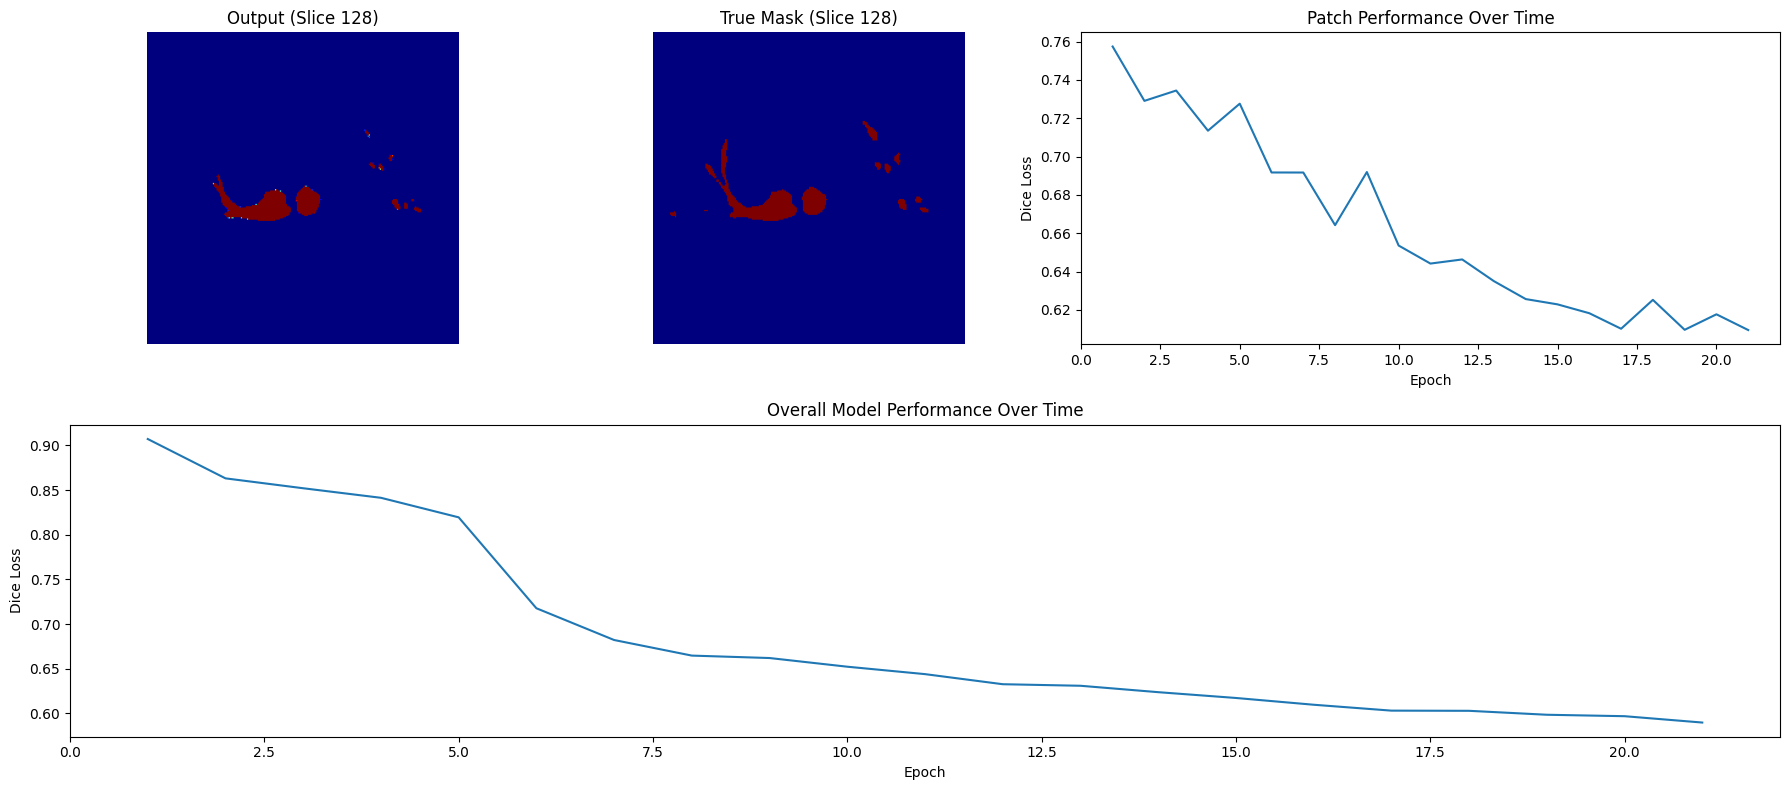

Checkpoint saved at epoch 21 to /content/drive/MyDrive/MyCheckpoints/model_epoch_21.pth


Epoch 31/1000: 100%|██████████| 100/100 [01:53<00:00,  1.14s/it]


Epoch [31/1000], Loss: 0.5546724677085877


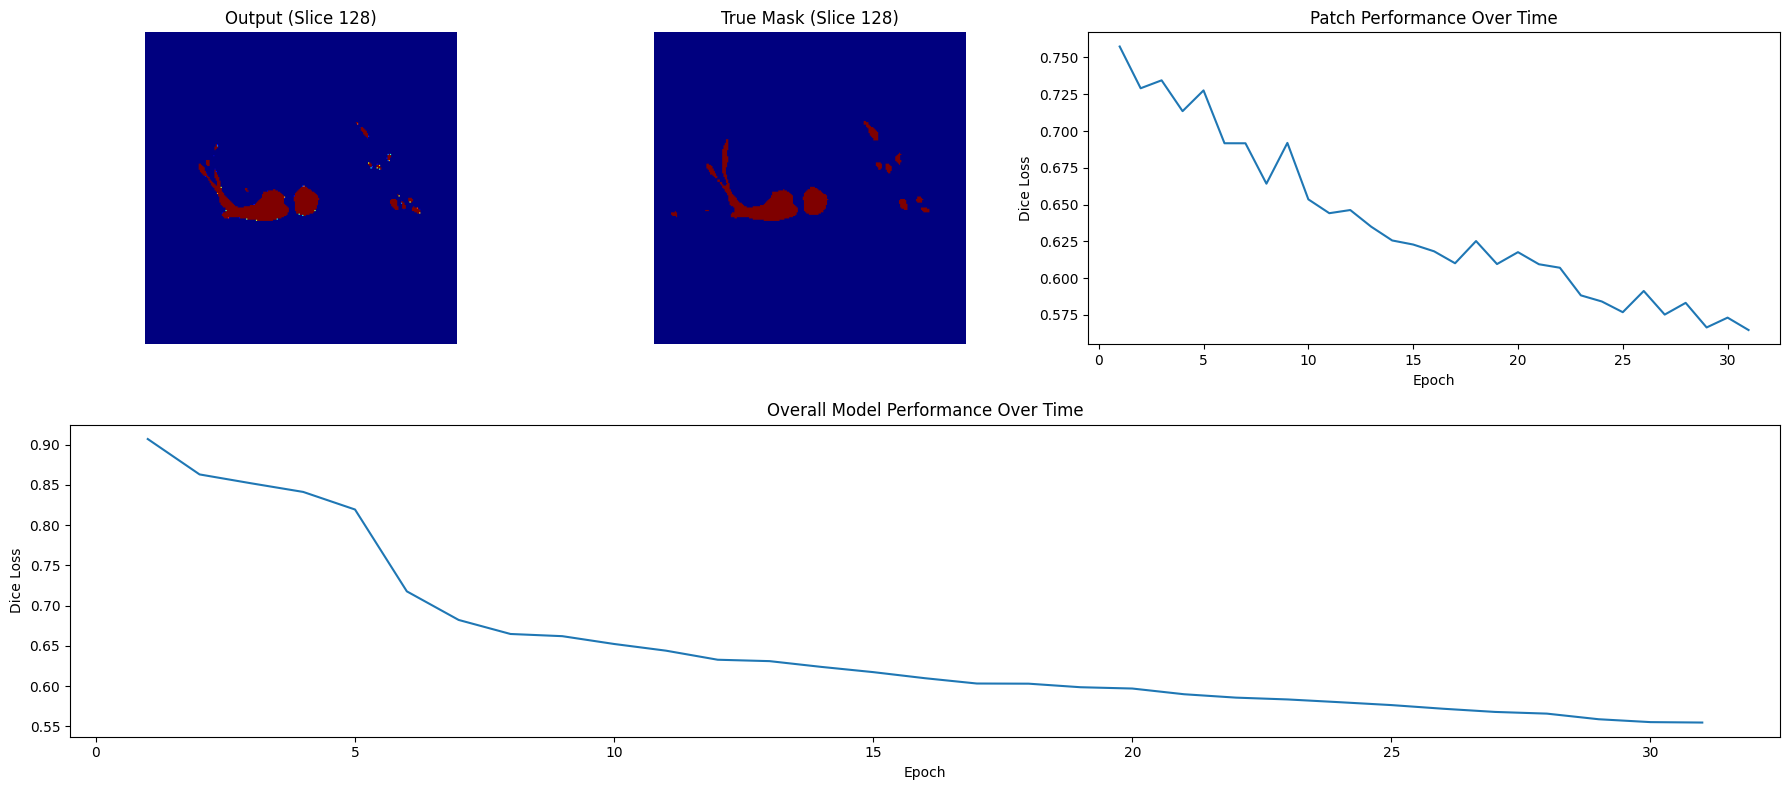

Checkpoint saved at epoch 31 to /content/drive/MyDrive/MyCheckpoints/model_epoch_31.pth


Epoch 41/1000: 100%|██████████| 100/100 [01:53<00:00,  1.13s/it]


Epoch [41/1000], Loss: 0.4968093204498291


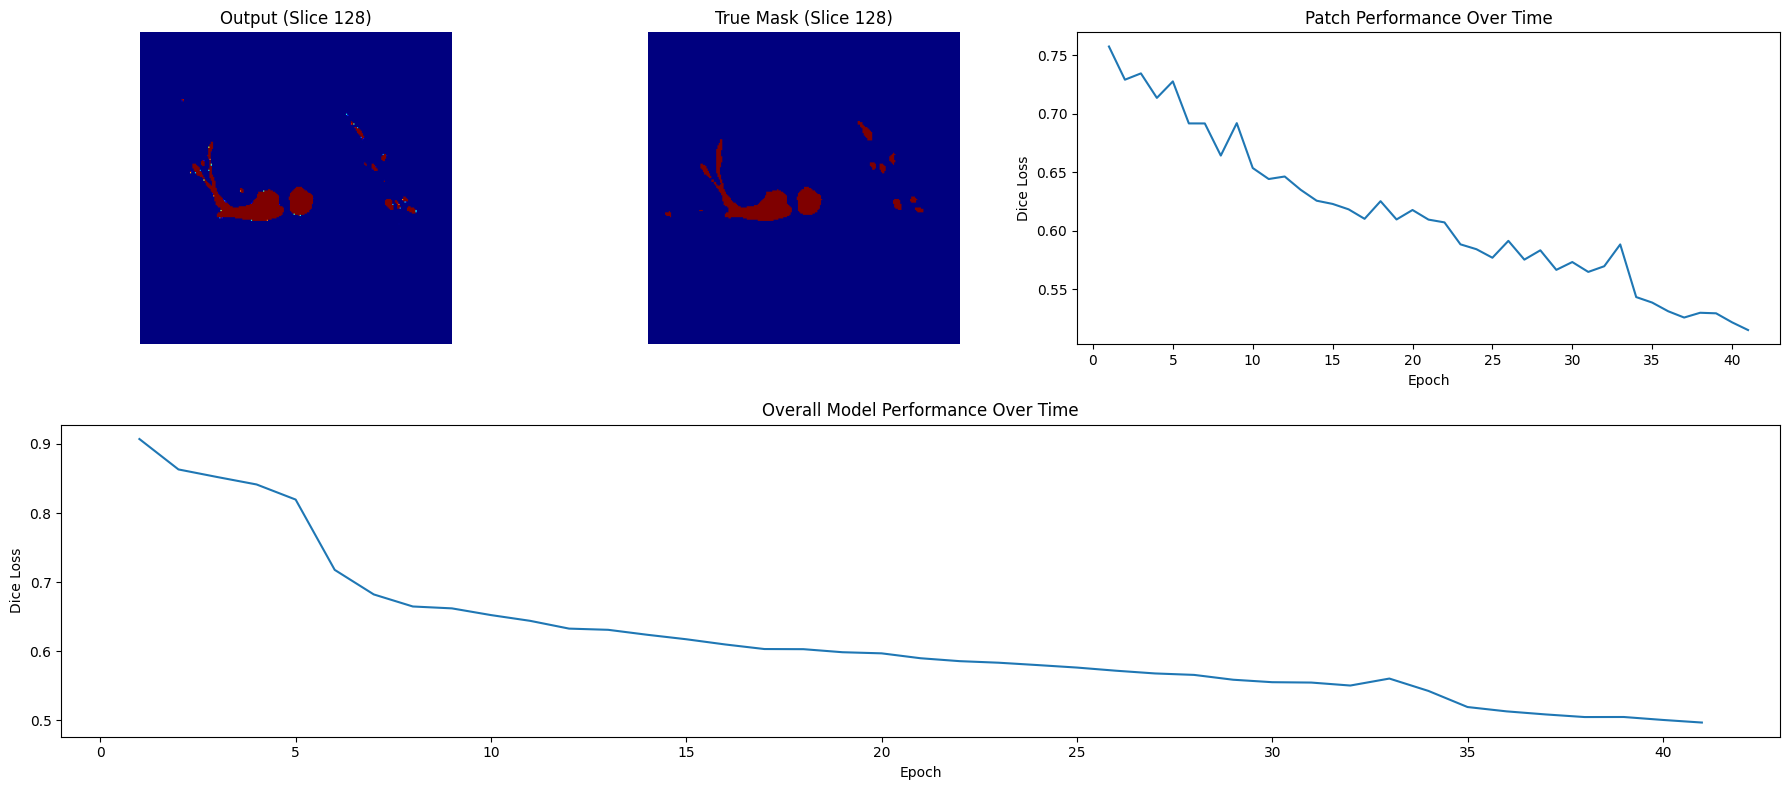

Checkpoint saved at epoch 41 to /content/drive/MyDrive/MyCheckpoints/model_epoch_41.pth


Epoch 51/1000: 100%|██████████| 100/100 [01:53<00:00,  1.14s/it]


Epoch [51/1000], Loss: 0.4690175414085388


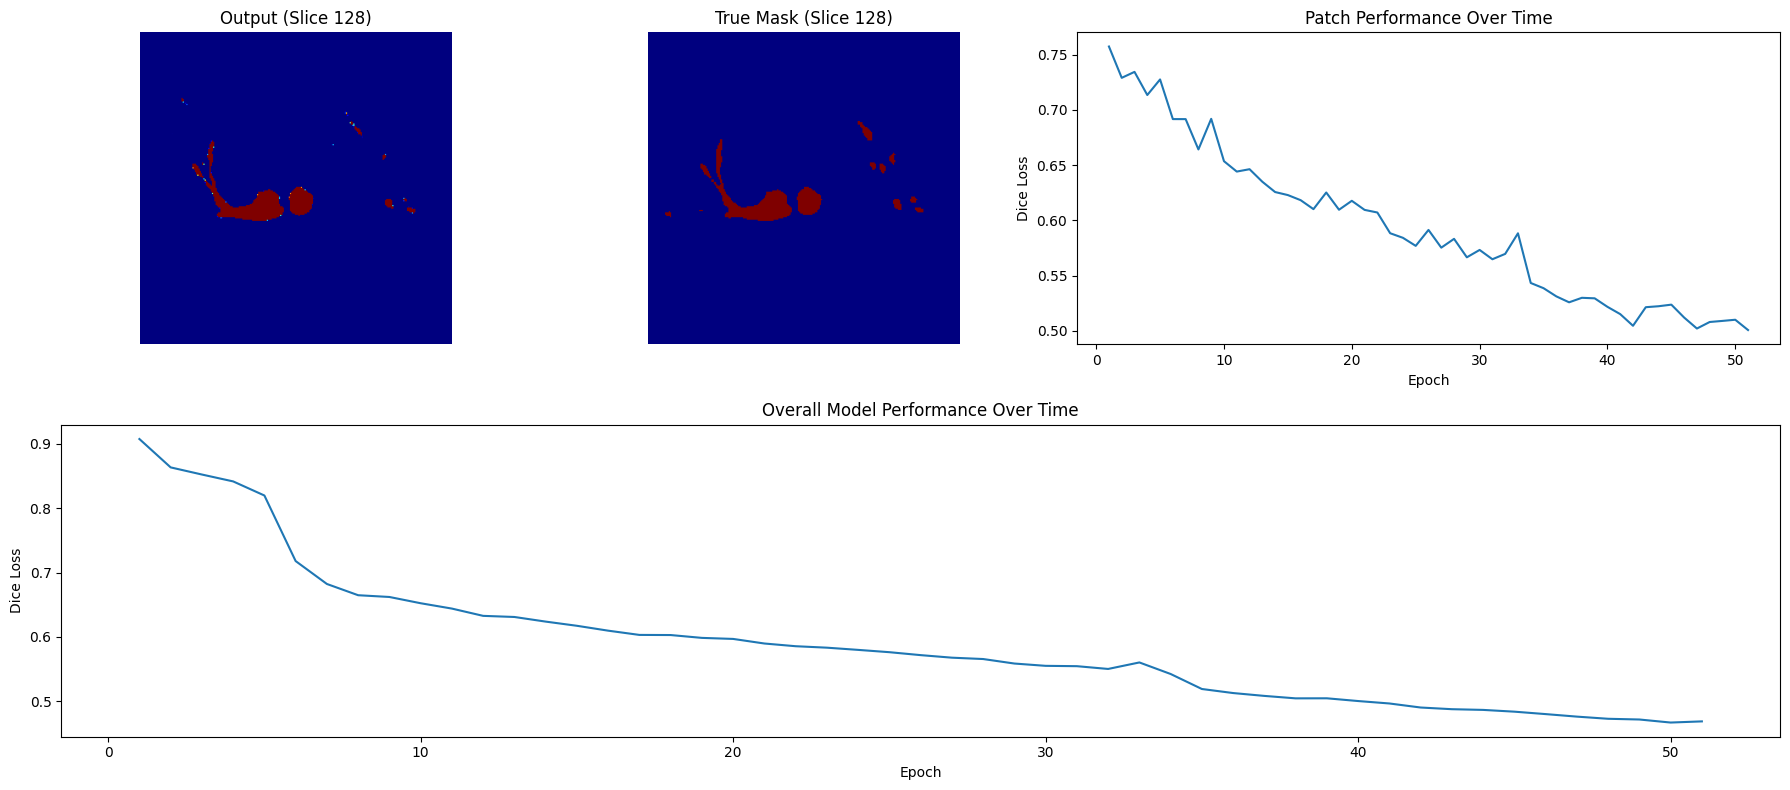

Checkpoint saved at epoch 51 to /content/drive/MyDrive/MyCheckpoints/model_epoch_51.pth


Epoch 61/1000: 100%|██████████| 100/100 [01:53<00:00,  1.14s/it]


Epoch [61/1000], Loss: 0.44063182711601256


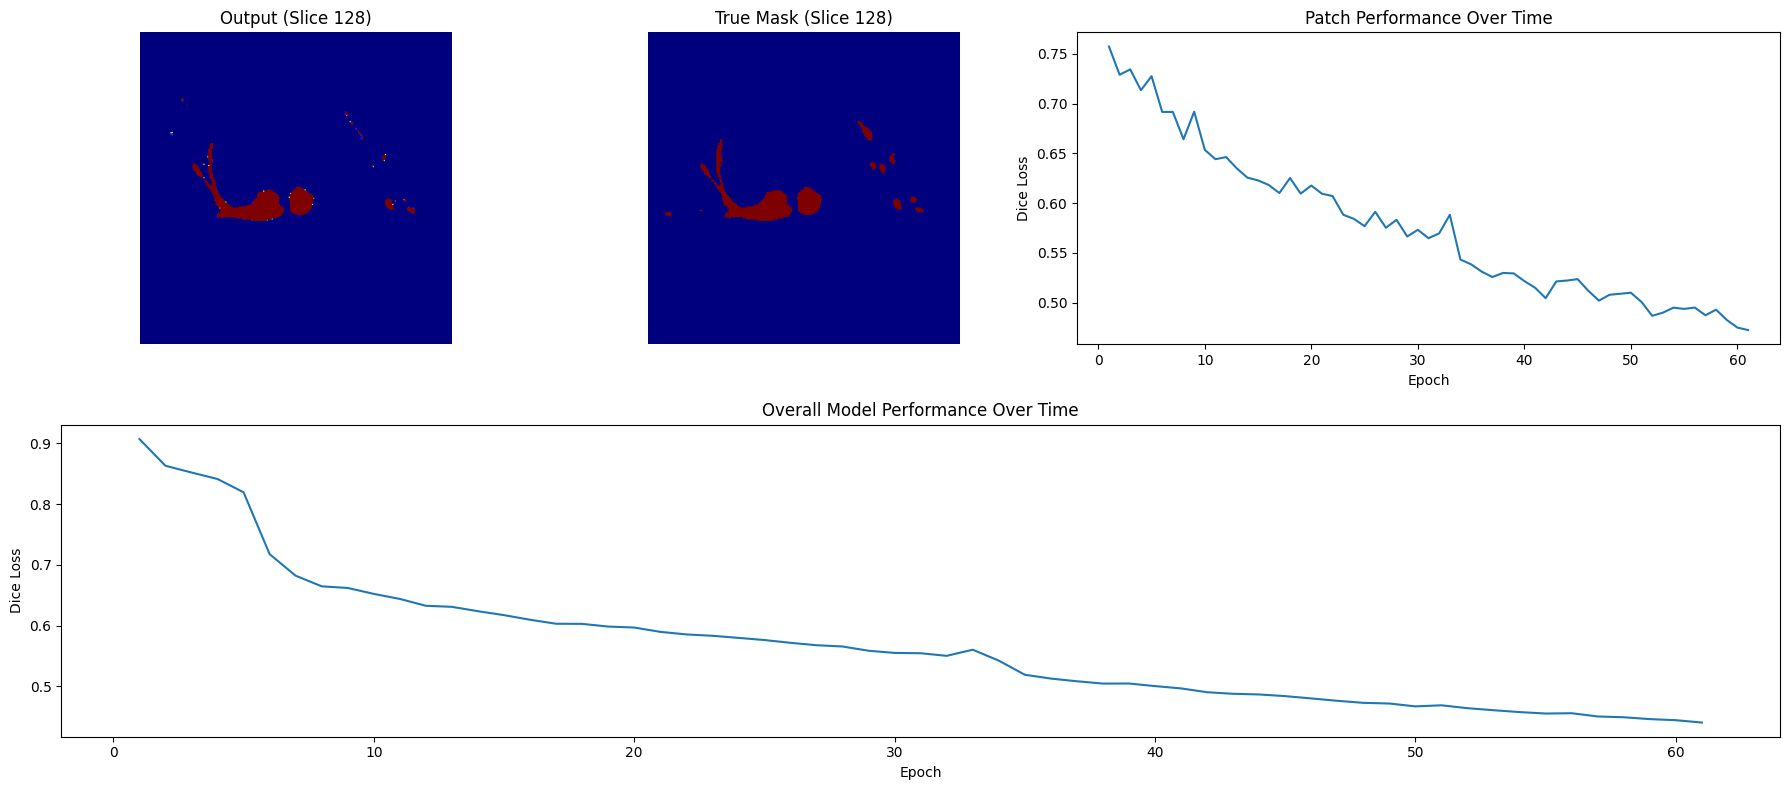

Checkpoint saved at epoch 61 to /content/drive/MyDrive/MyCheckpoints/model_epoch_61.pth


Epoch 71/1000: 100%|██████████| 100/100 [01:53<00:00,  1.14s/it]


Epoch [71/1000], Loss: 0.4128375178575516


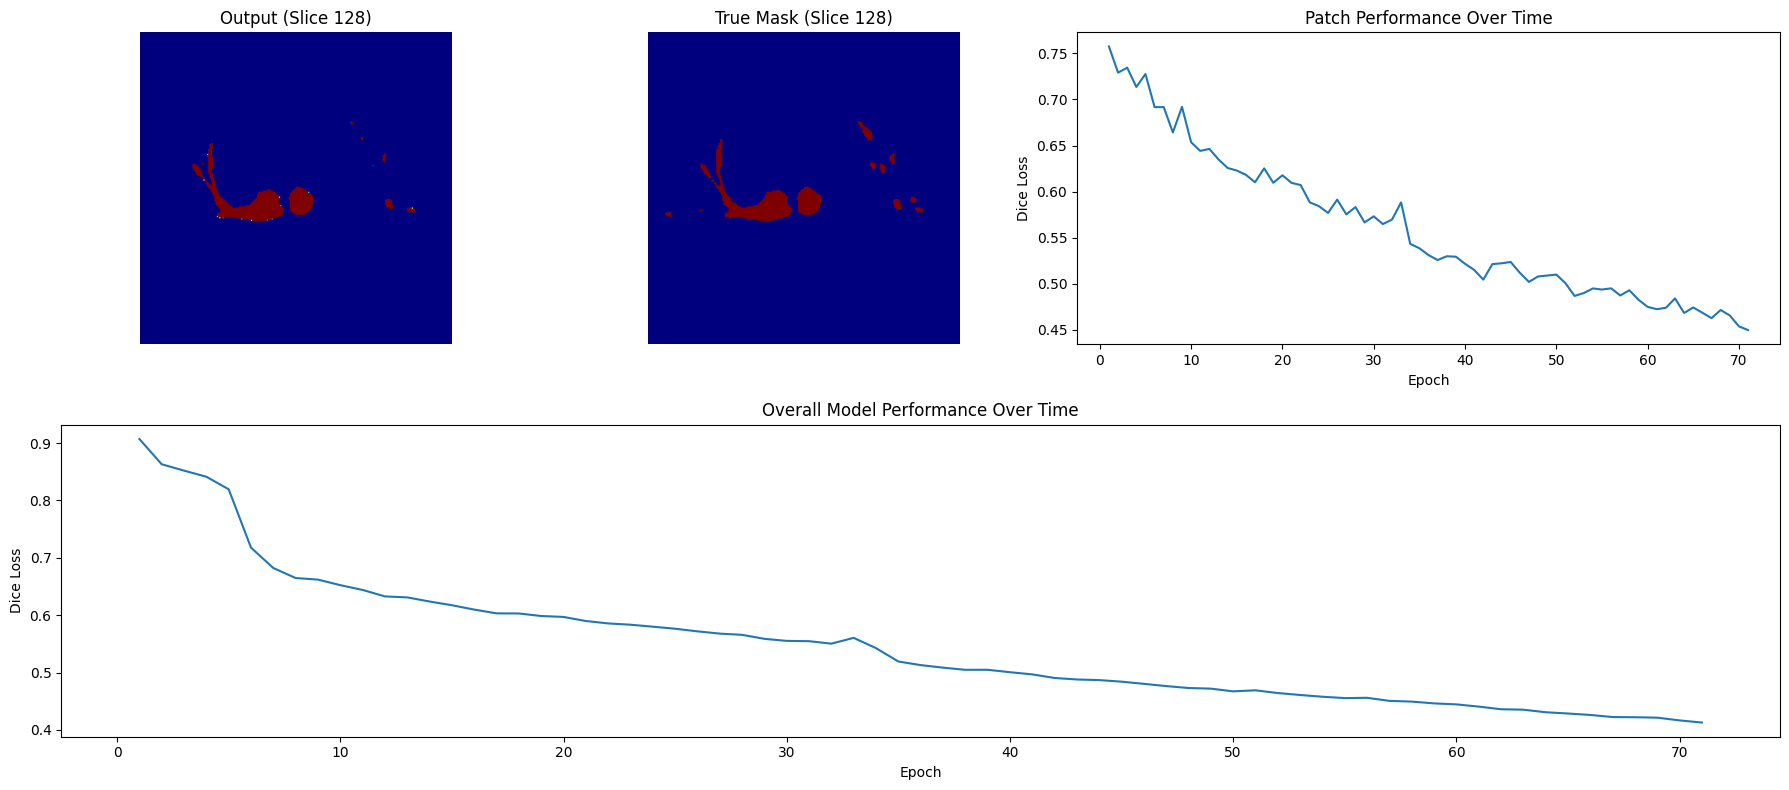

Checkpoint saved at epoch 71 to /content/drive/MyDrive/MyCheckpoints/model_epoch_71.pth


Epoch 81/1000: 100%|██████████| 100/100 [01:53<00:00,  1.14s/it]


Epoch [81/1000], Loss: 0.3907534182071686


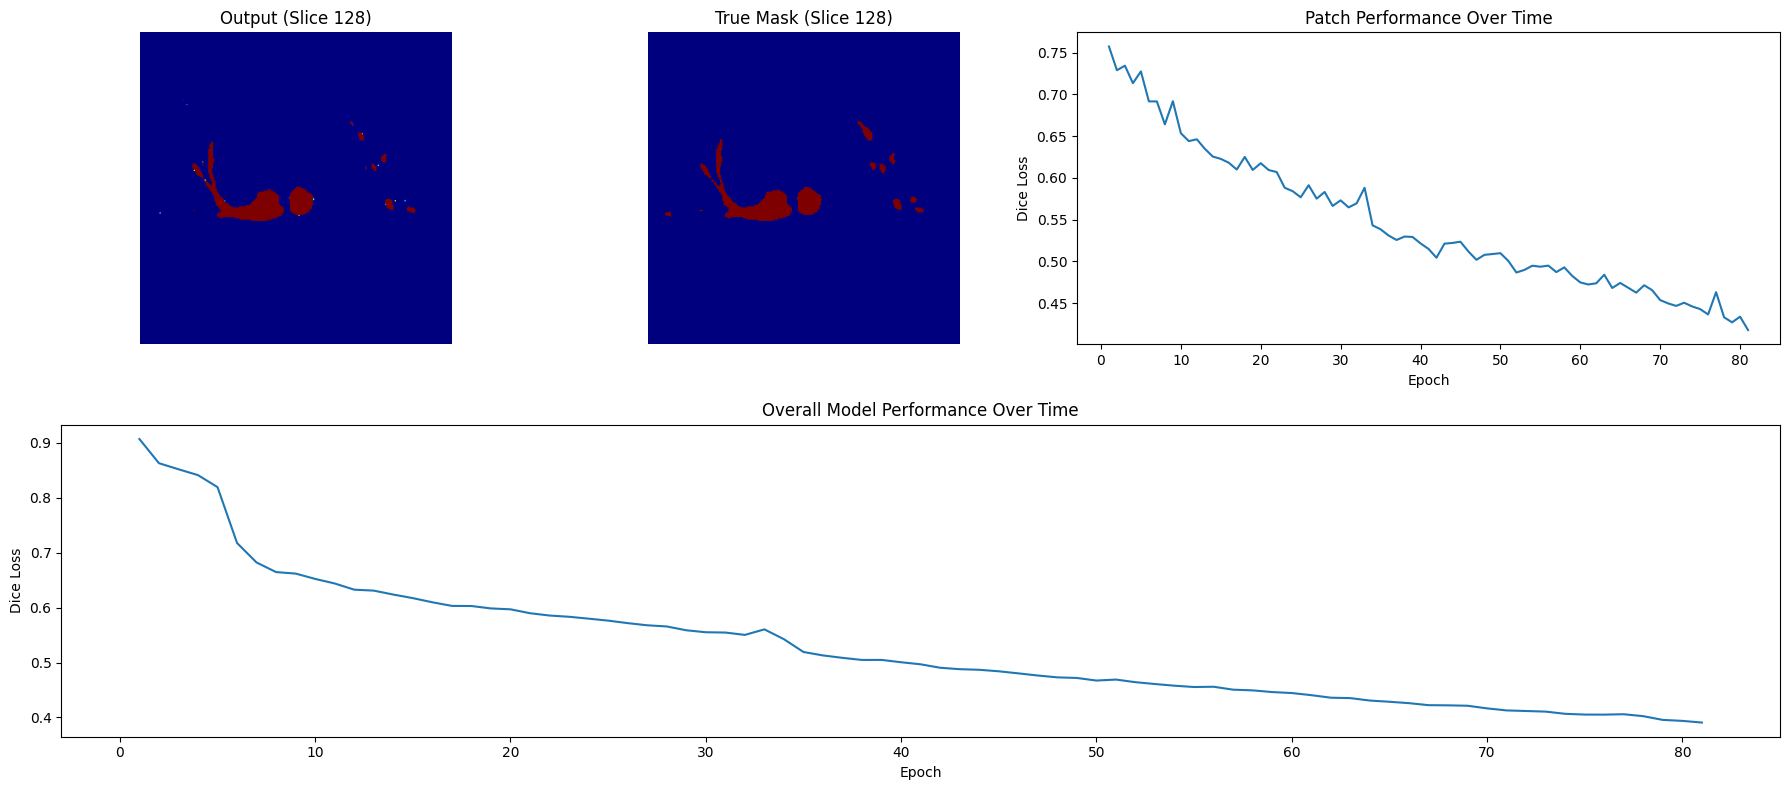

Checkpoint saved at epoch 81 to /content/drive/MyDrive/MyCheckpoints/model_epoch_81.pth


Epoch 91/1000: 100%|██████████| 100/100 [01:53<00:00,  1.13s/it]


Epoch [91/1000], Loss: 0.3683917725086212


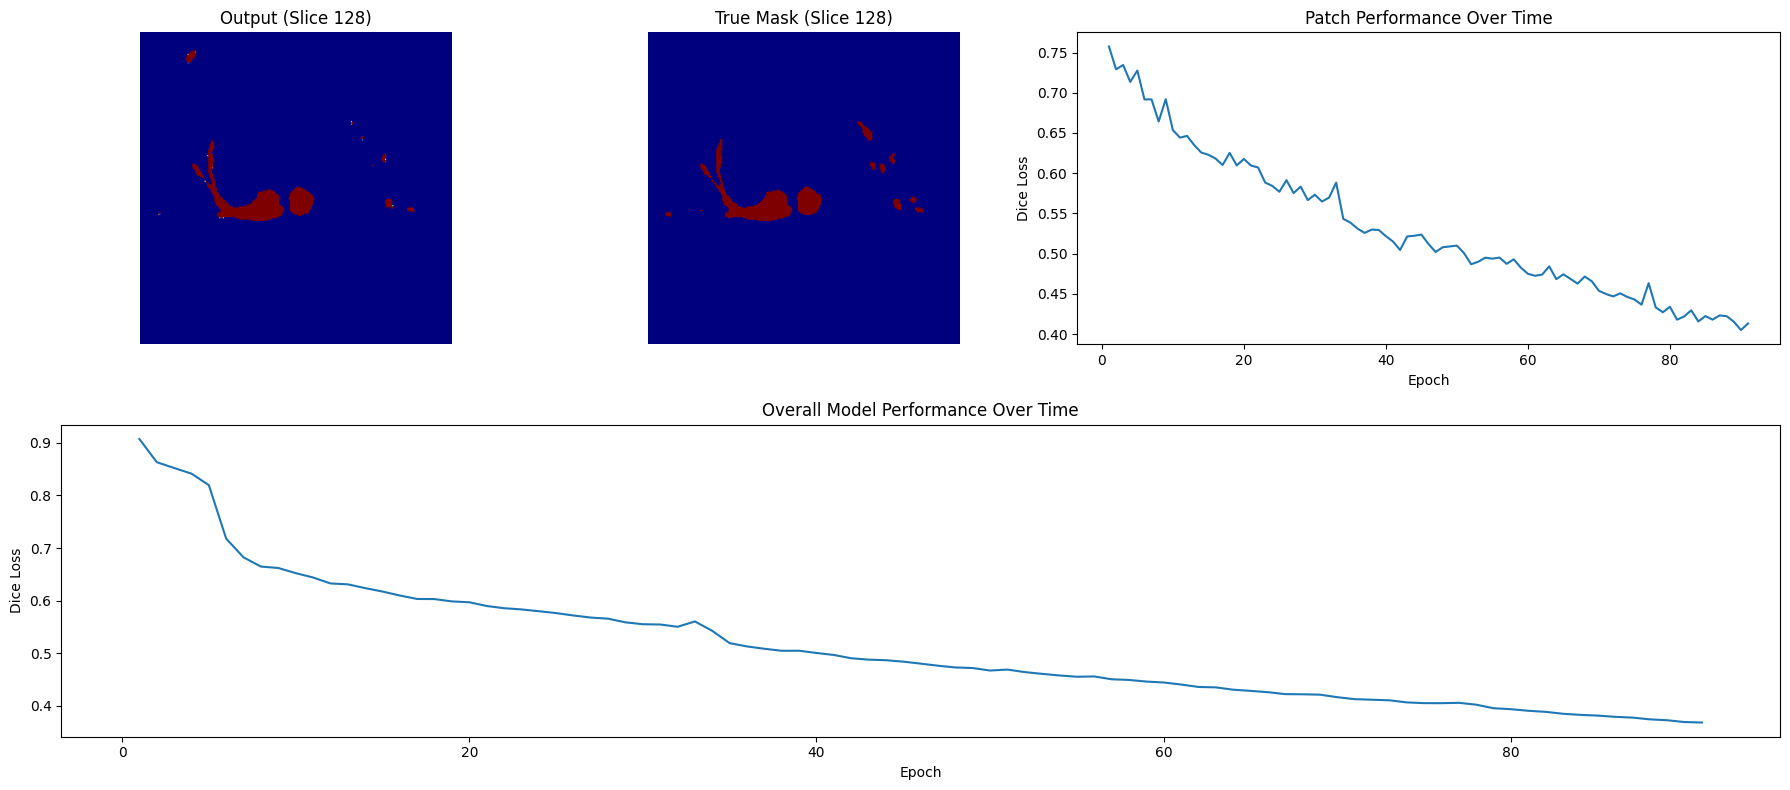

Checkpoint saved at epoch 91 to /content/drive/MyDrive/MyCheckpoints/model_epoch_91.pth


Epoch 97/1000:  42%|████▏     | 42/100 [00:45<00:59,  1.03s/it]

In [ ]:
# epochs till 90

## epochs till 300

<ipython-input-12-1c85b289e0c4>:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)
Epoch 1/1000: 100%|██████████| 100/100 [01:53<00:0

Epoch [1/1000], Loss: 0.3654346585273743


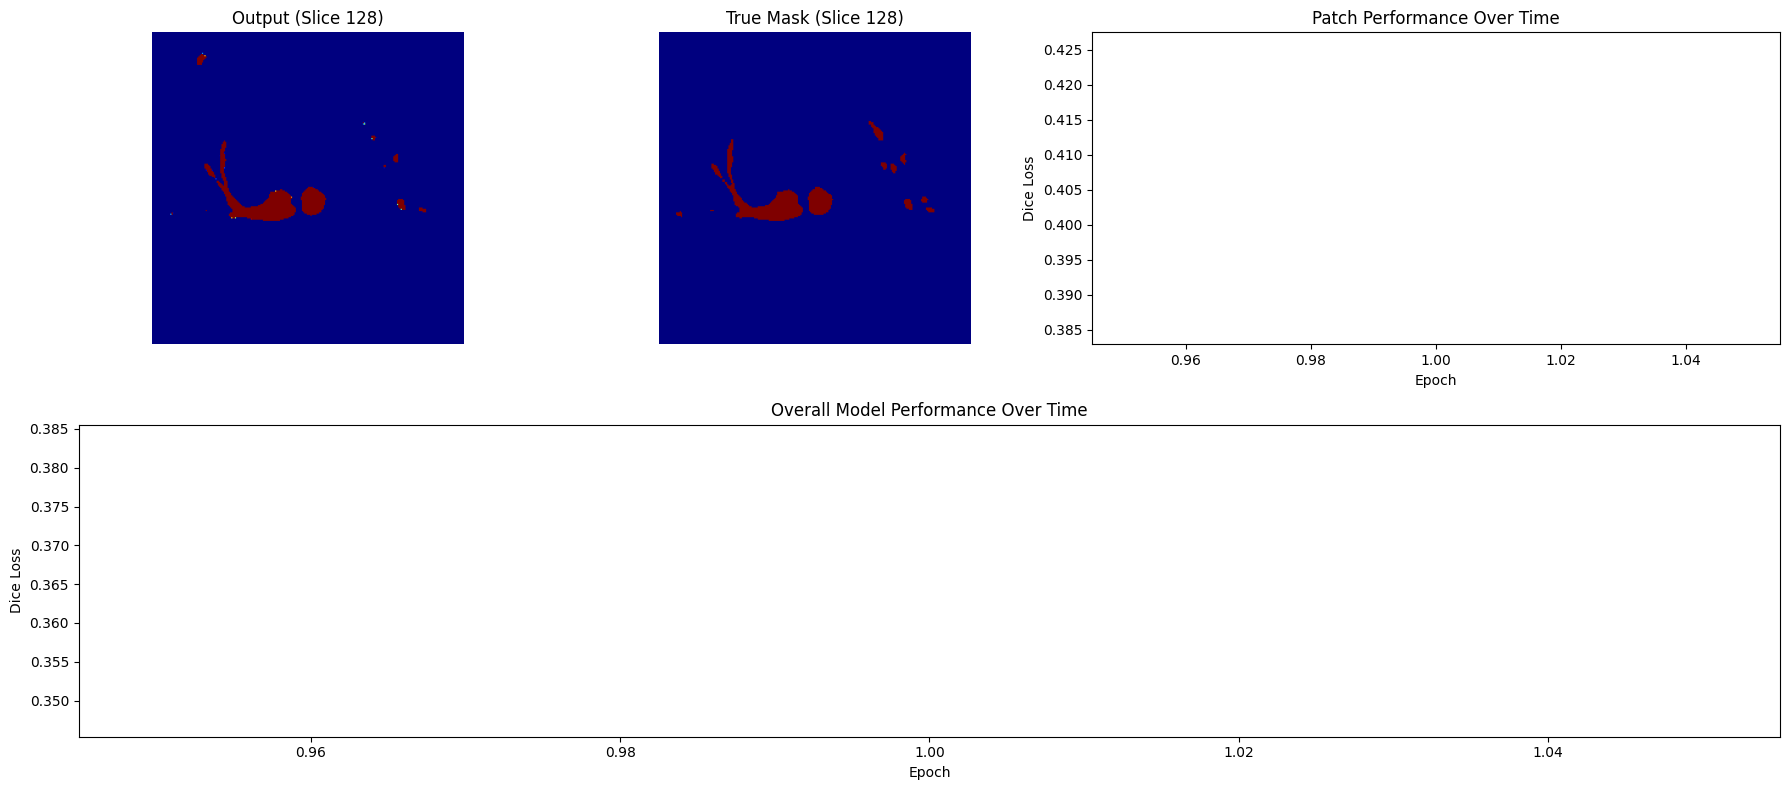

Checkpoint saved at epoch 1 to /content/drive/MyDrive/MyCheckpoints/model_epoch_1.pth


Epoch 11/1000: 100%|██████████| 100/100 [01:53<00:00,  1.13s/it]


Epoch [11/1000], Loss: 0.34700033366680144


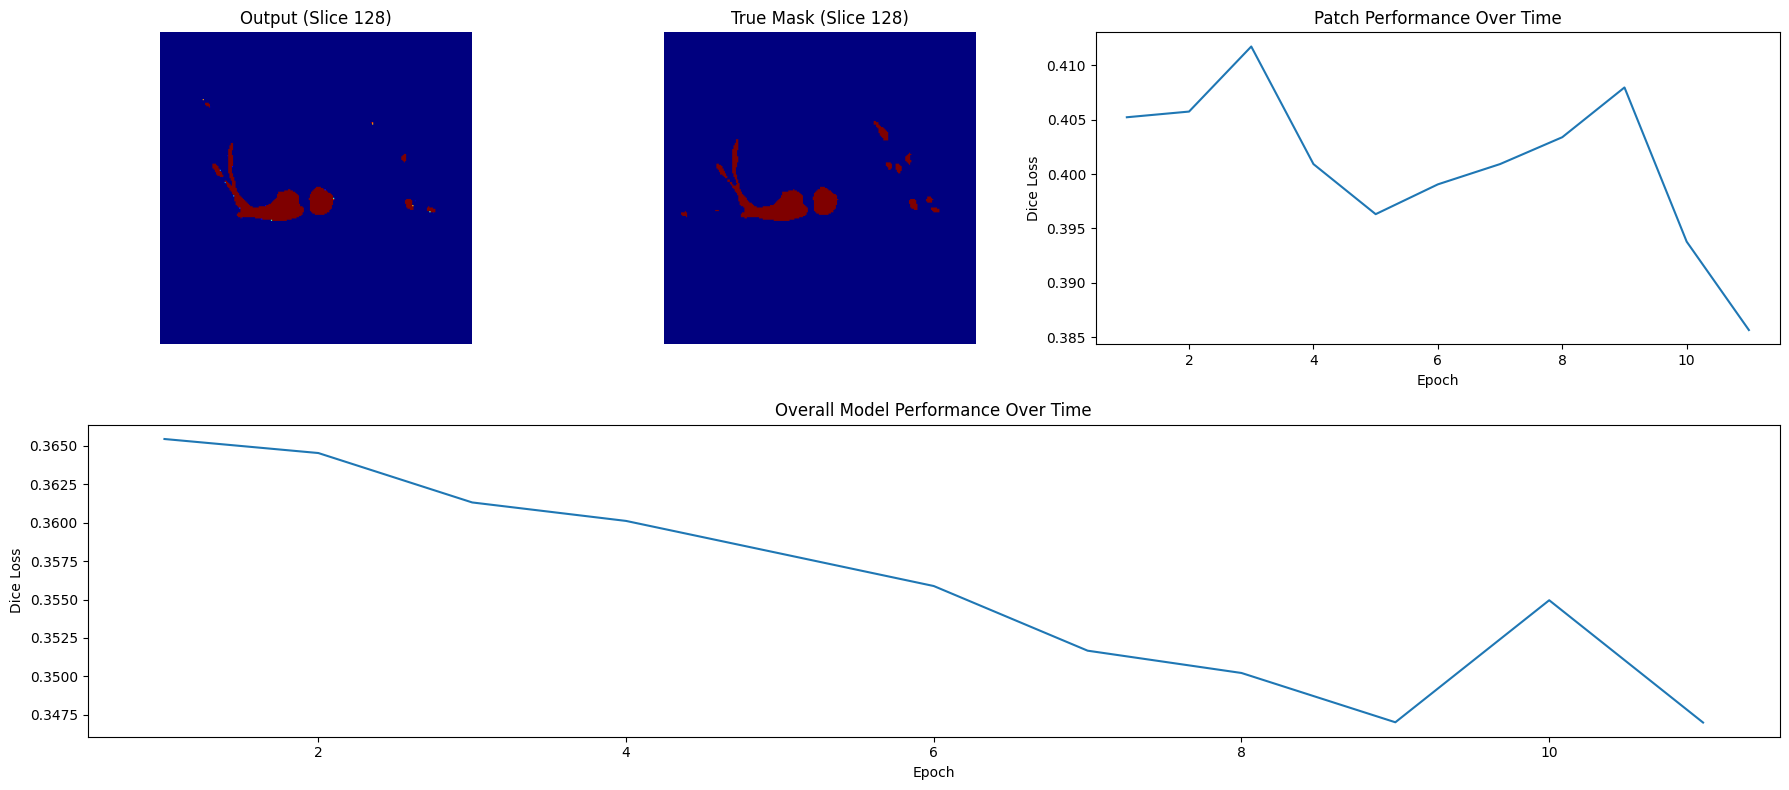

Checkpoint saved at epoch 11 to /content/drive/MyDrive/MyCheckpoints/model_epoch_11.pth


Epoch 21/1000: 100%|██████████| 100/100 [01:52<00:00,  1.13s/it]


Epoch [21/1000], Loss: 0.32196380972862243


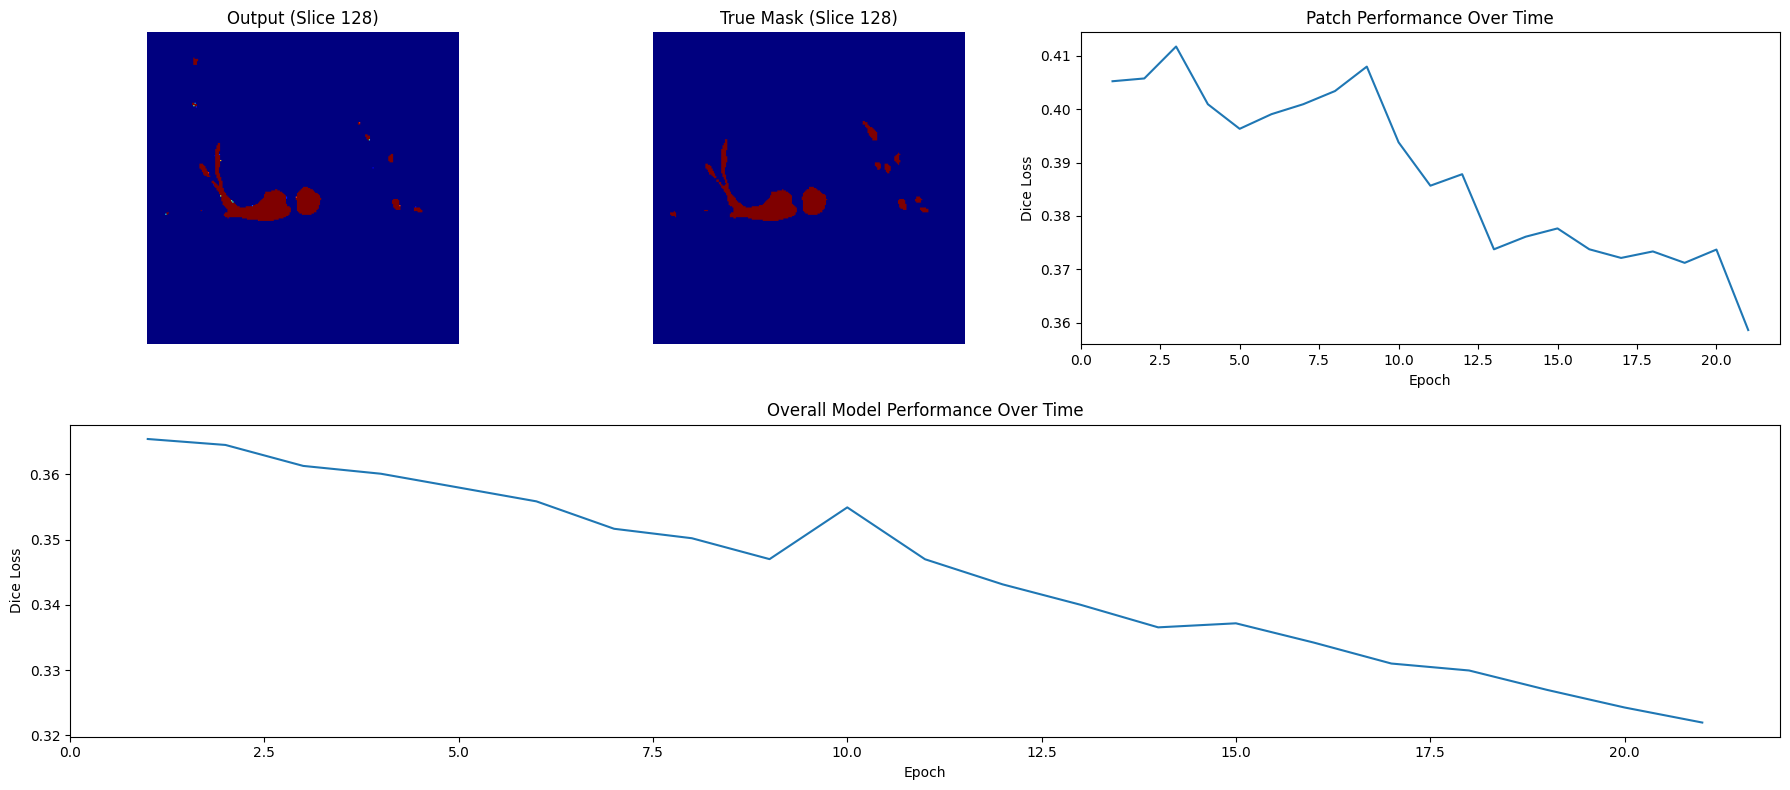

Checkpoint saved at epoch 21 to /content/drive/MyDrive/MyCheckpoints/model_epoch_21.pth


Epoch 31/1000: 100%|██████████| 100/100 [01:52<00:00,  1.13s/it]


Epoch [31/1000], Loss: 0.3020011329650879


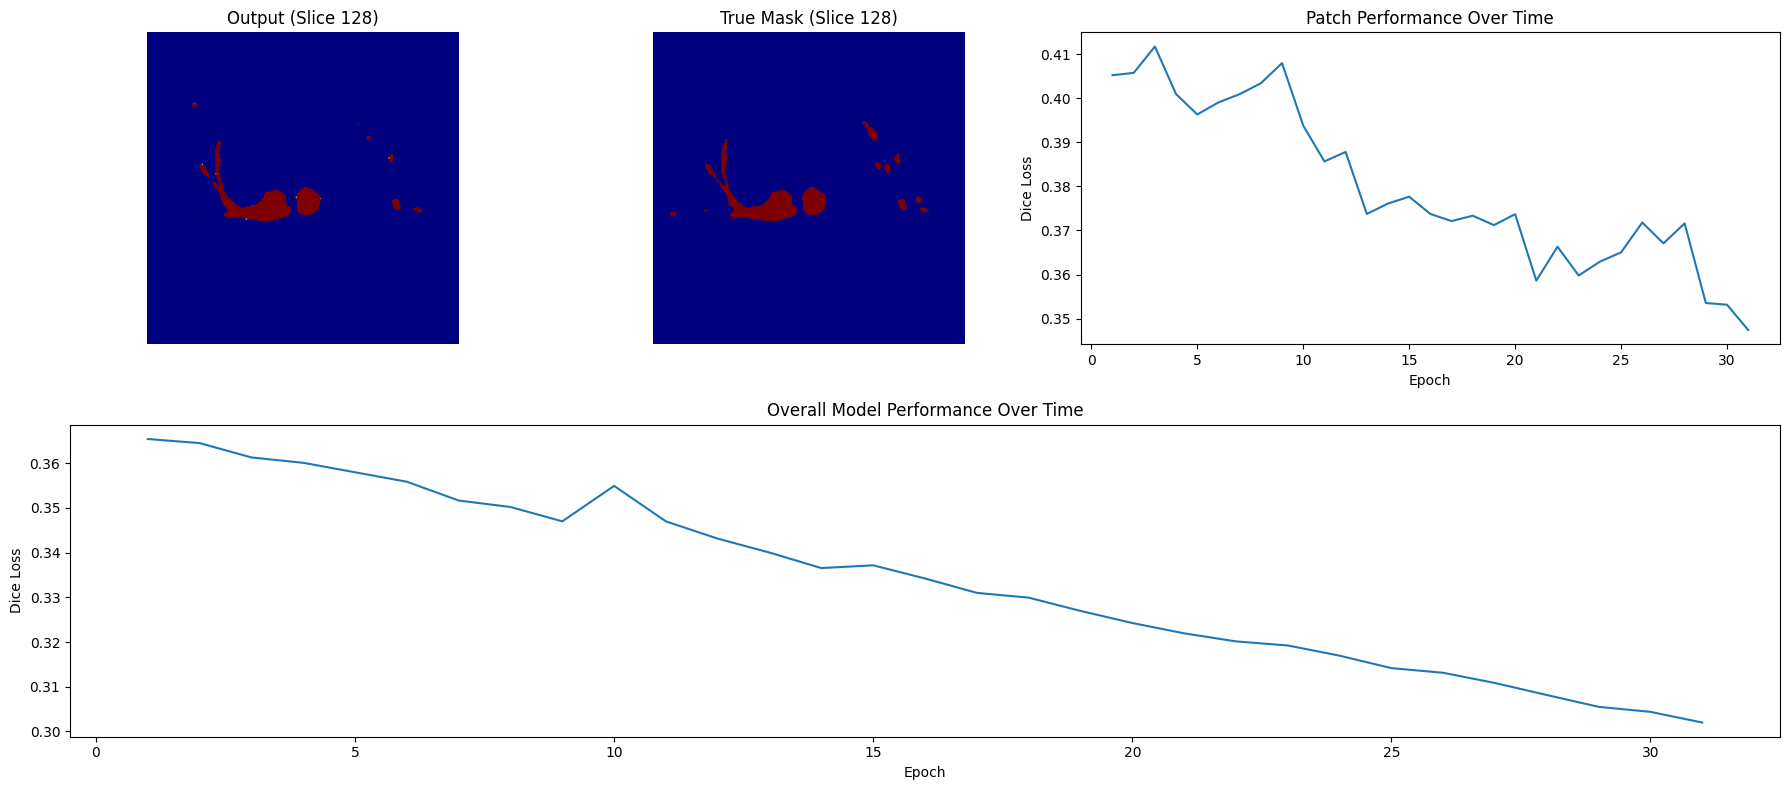

Checkpoint saved at epoch 31 to /content/drive/MyDrive/MyCheckpoints/model_epoch_31.pth


Epoch 41/1000: 100%|██████████| 100/100 [01:53<00:00,  1.13s/it]


Epoch [41/1000], Loss: 0.2939715391397476


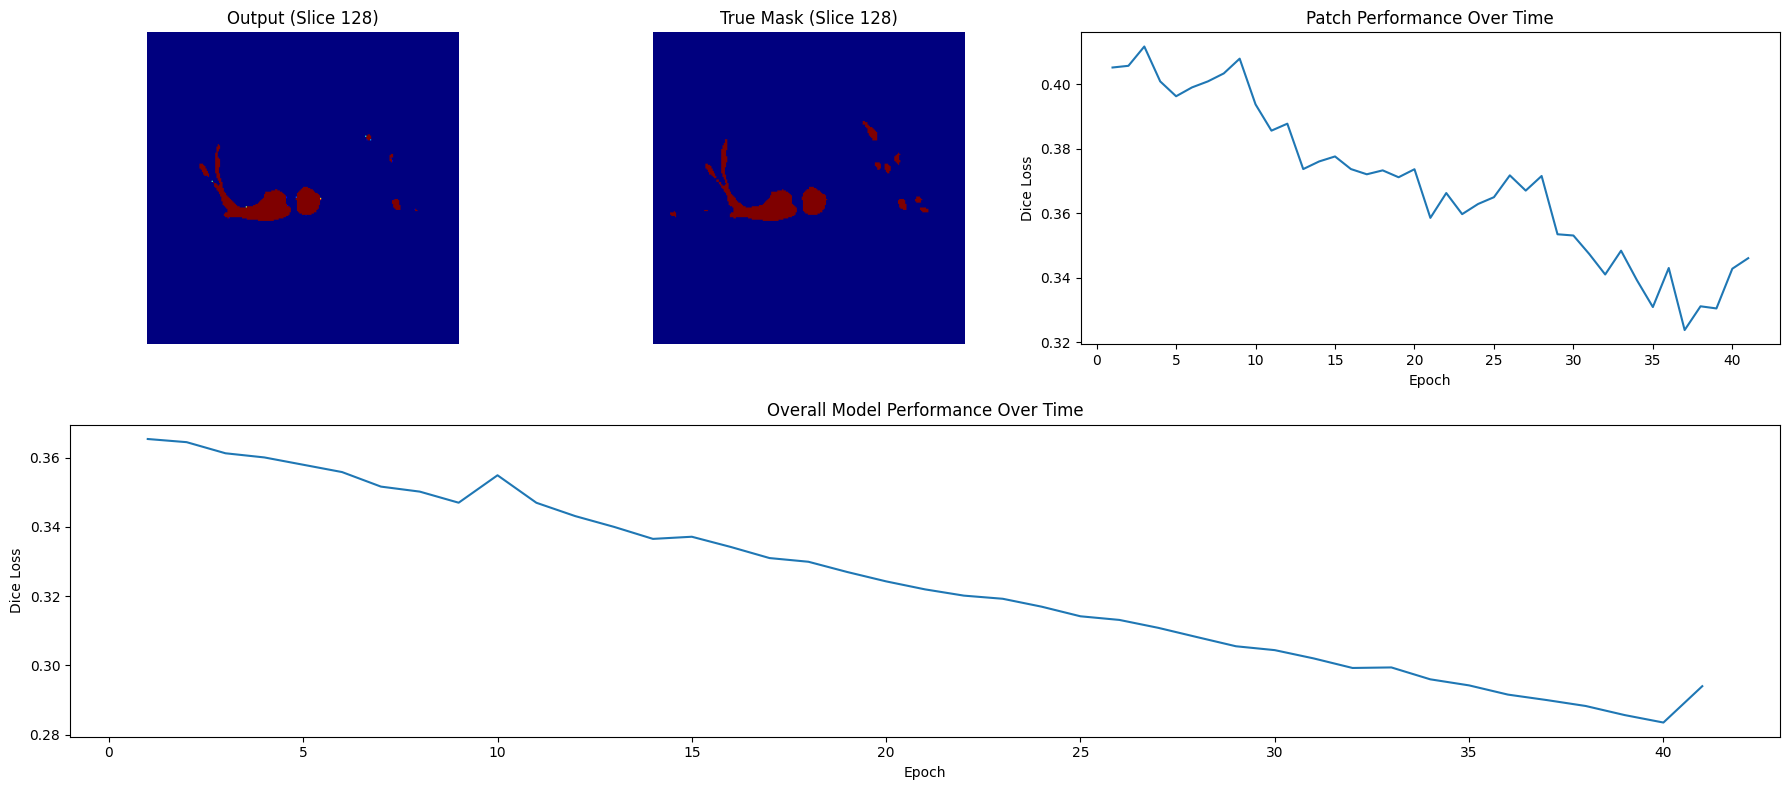

Checkpoint saved at epoch 41 to /content/drive/MyDrive/MyCheckpoints/model_epoch_41.pth


Epoch 51/1000: 100%|██████████| 100/100 [01:52<00:00,  1.13s/it]


Epoch [51/1000], Loss: 0.2648262369632721


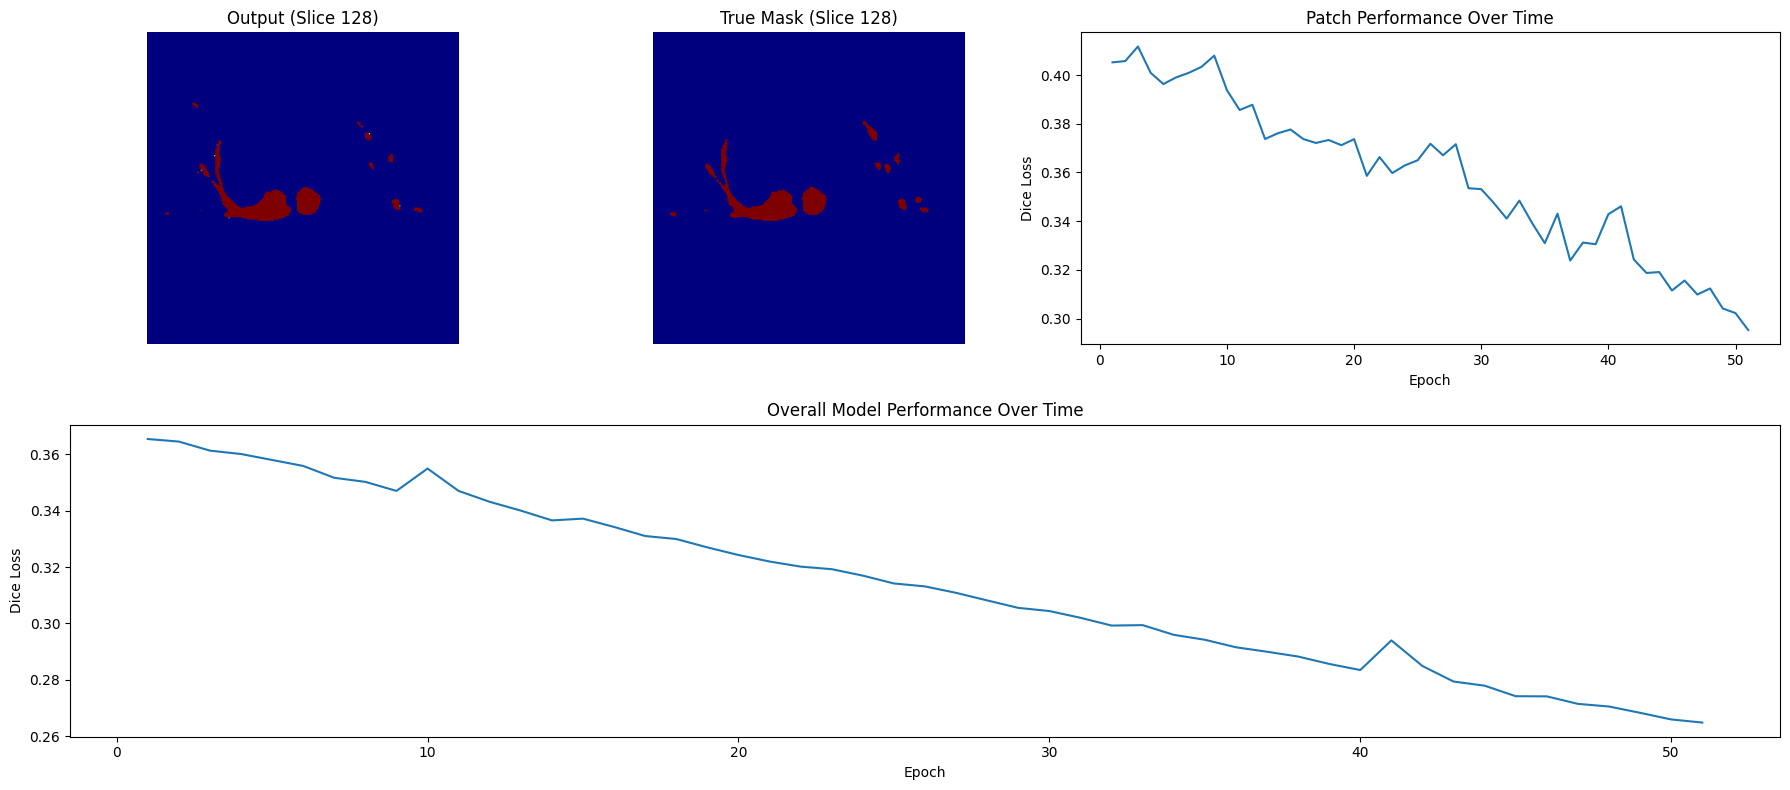

Checkpoint saved at epoch 51 to /content/drive/MyDrive/MyCheckpoints/model_epoch_51.pth


Epoch 61/1000: 100%|██████████| 100/100 [01:53<00:00,  1.13s/it]


Epoch [61/1000], Loss: 0.24657722651958466


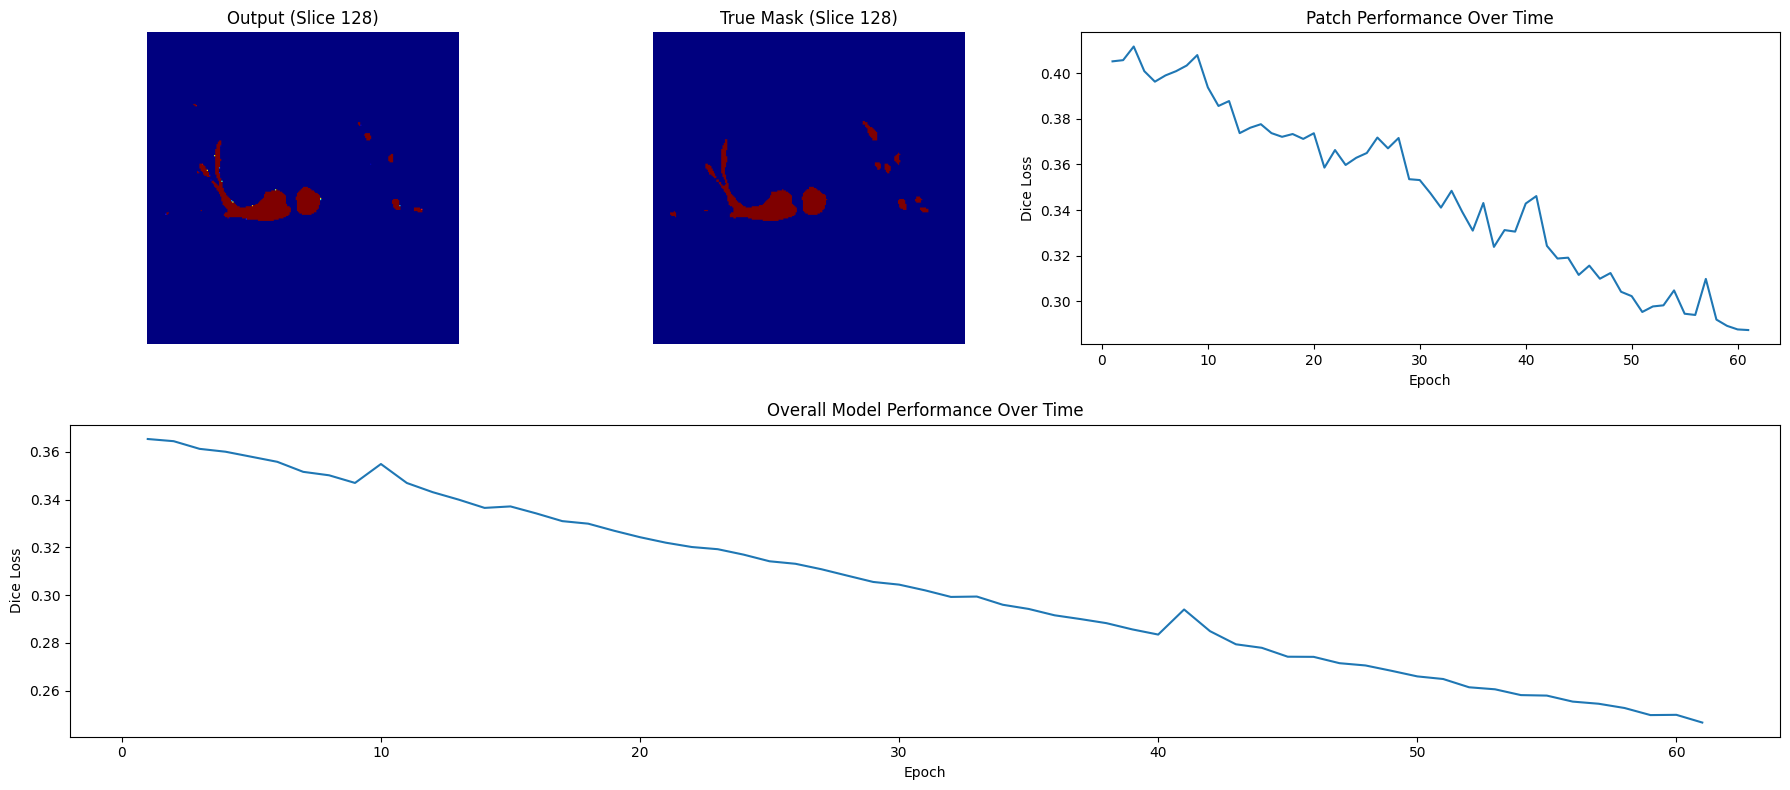

Checkpoint saved at epoch 61 to /content/drive/MyDrive/MyCheckpoints/model_epoch_61.pth


Epoch 71/1000: 100%|██████████| 100/100 [01:52<00:00,  1.13s/it]


Epoch [71/1000], Loss: 0.23116132736206055


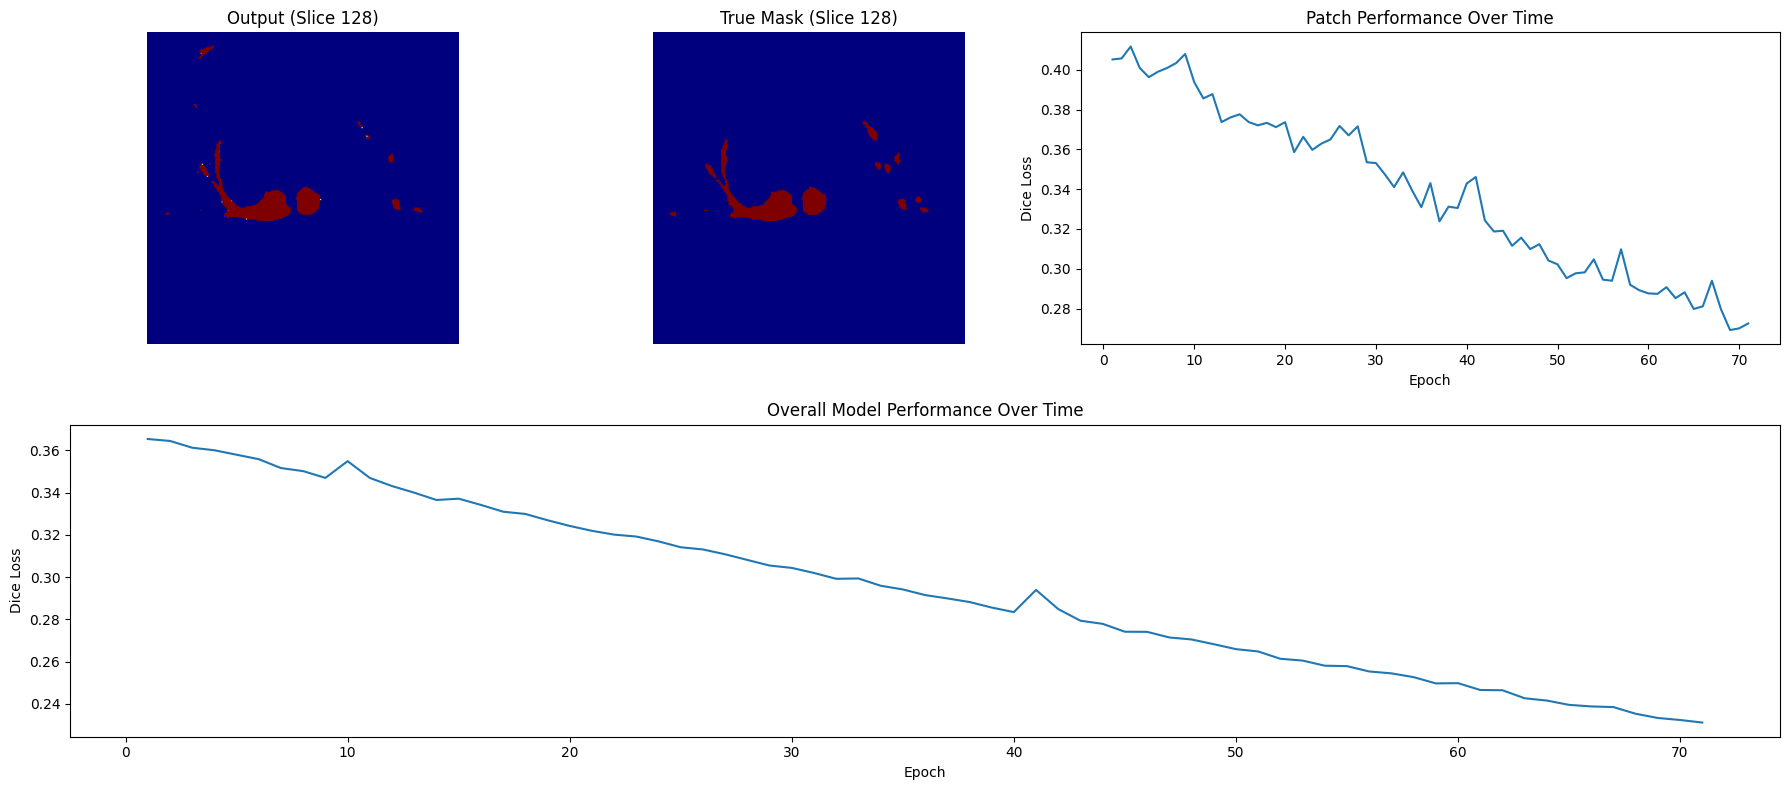

Checkpoint saved at epoch 71 to /content/drive/MyDrive/MyCheckpoints/model_epoch_71.pth


Epoch 81/1000: 100%|██████████| 100/100 [01:53<00:00,  1.13s/it]


Epoch [81/1000], Loss: 0.21660843789577483


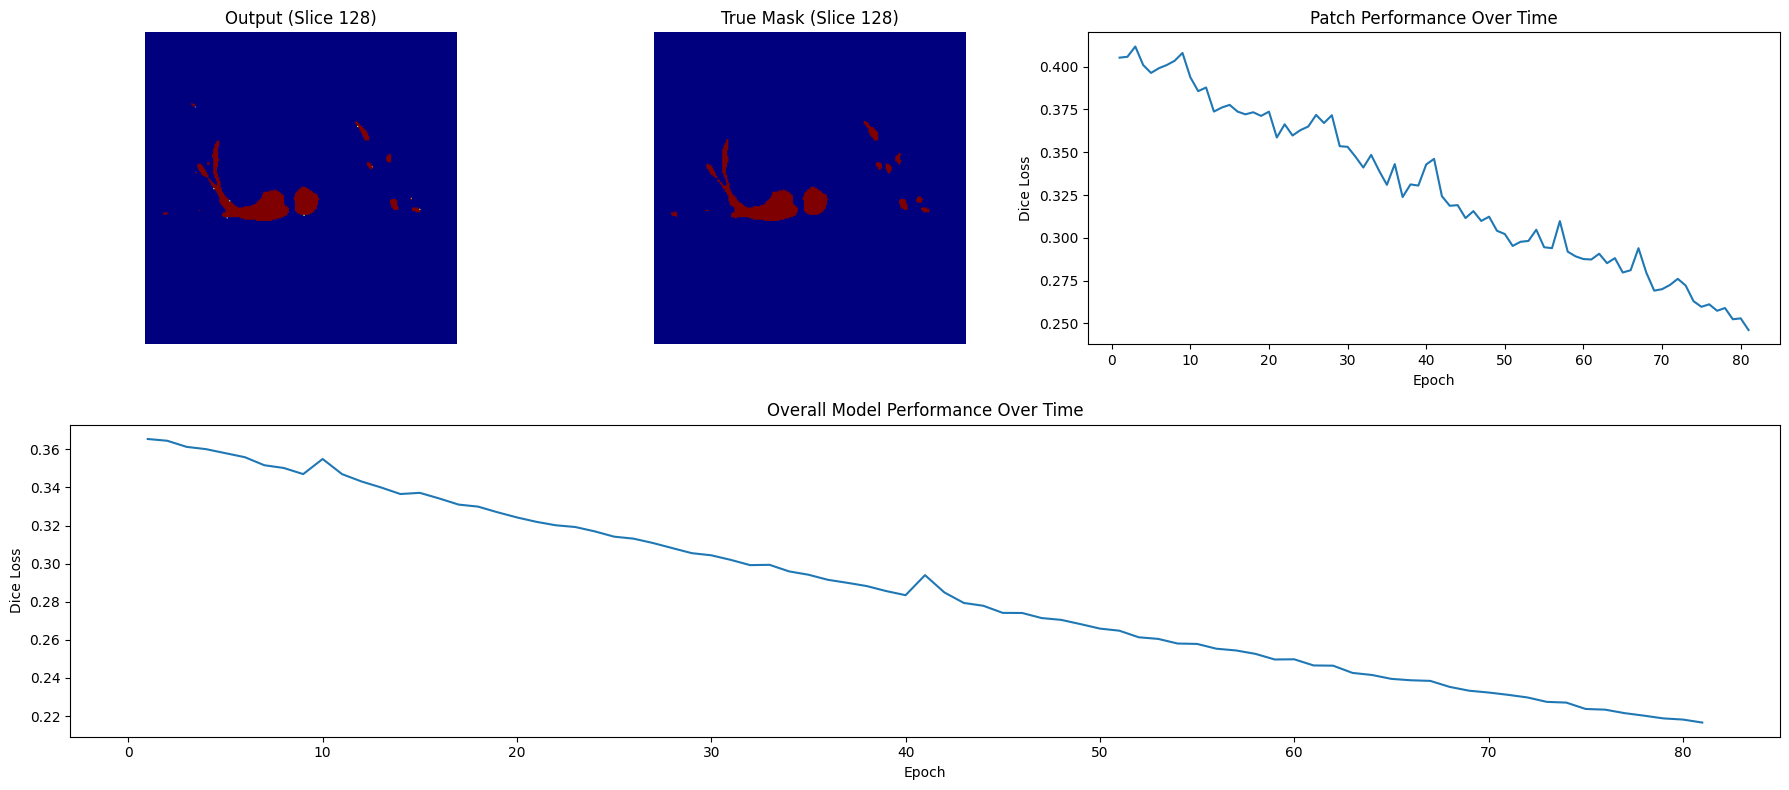

Checkpoint saved at epoch 81 to /content/drive/MyDrive/MyCheckpoints/model_epoch_81.pth


Epoch 91/1000: 100%|██████████| 100/100 [01:54<00:00,  1.14s/it]


Epoch [91/1000], Loss: 0.20428553521633147


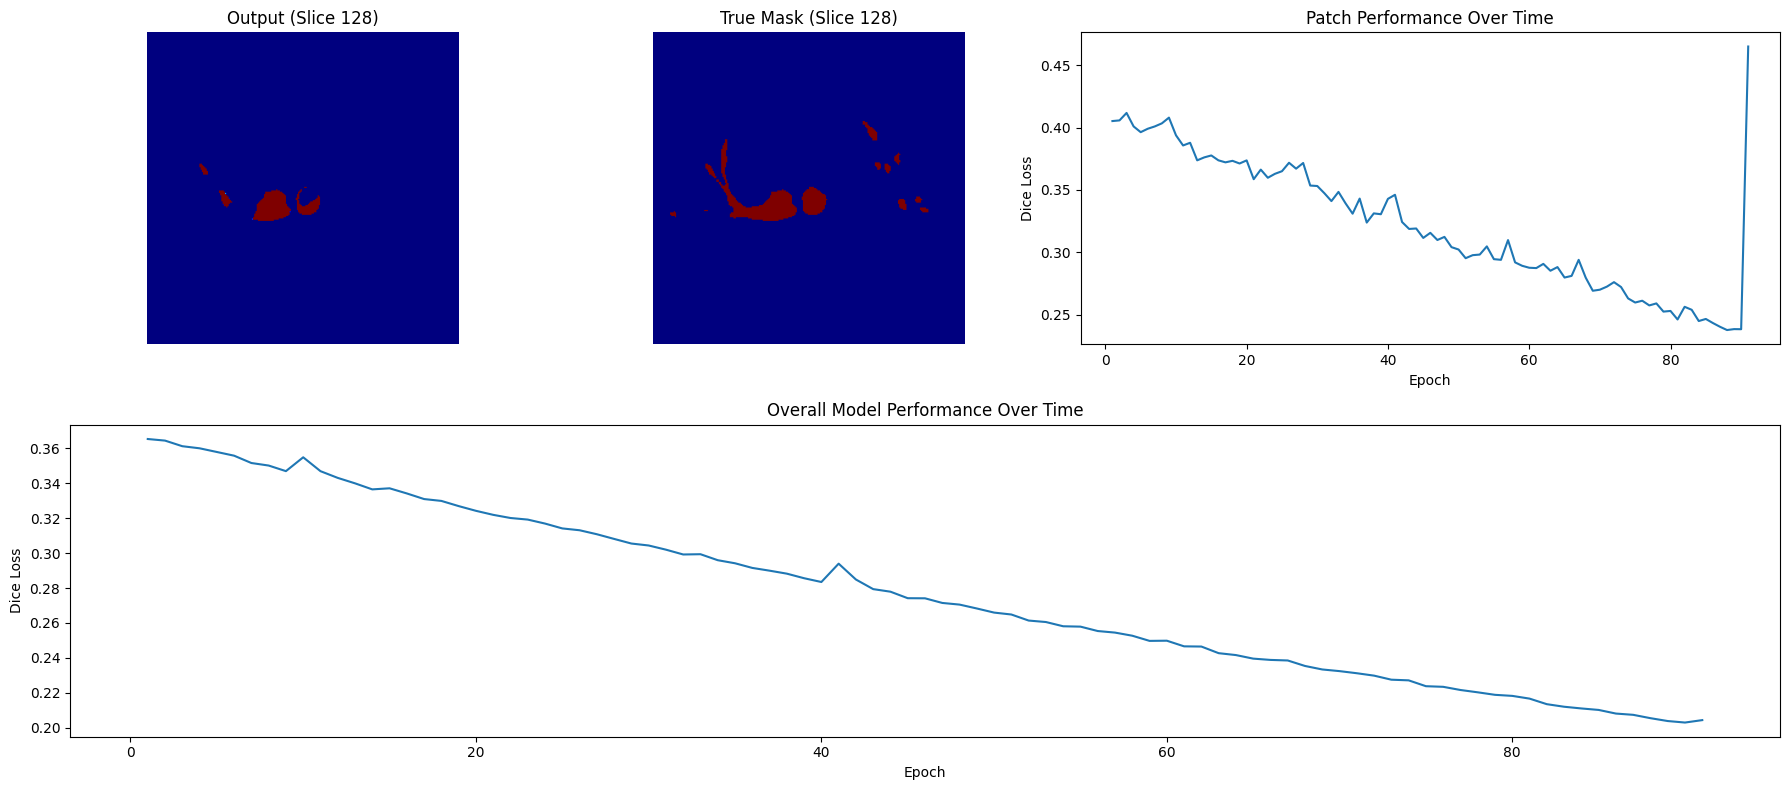

Checkpoint saved at epoch 91 to /content/drive/MyDrive/MyCheckpoints/model_epoch_91.pth


Epoch 101/1000: 100%|██████████| 100/100 [01:53<00:00,  1.14s/it]


Epoch [101/1000], Loss: 0.18896163165569305


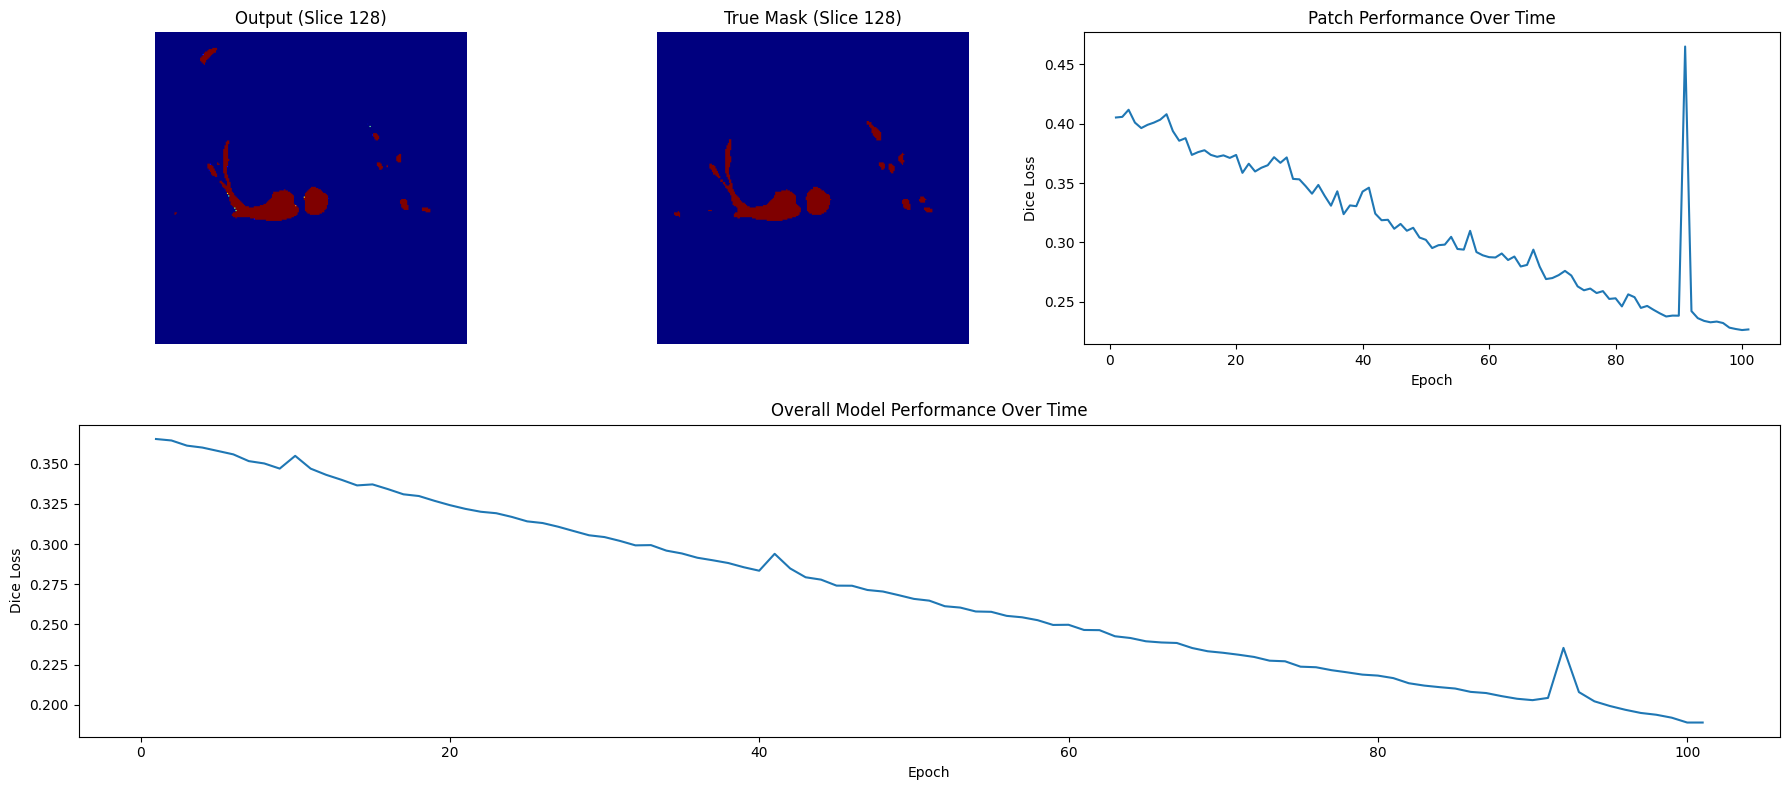

Checkpoint saved at epoch 101 to /content/drive/MyDrive/MyCheckpoints/model_epoch_101.pth


Epoch 111/1000: 100%|██████████| 100/100 [01:53<00:00,  1.14s/it]


Epoch [111/1000], Loss: 0.17531716644763948


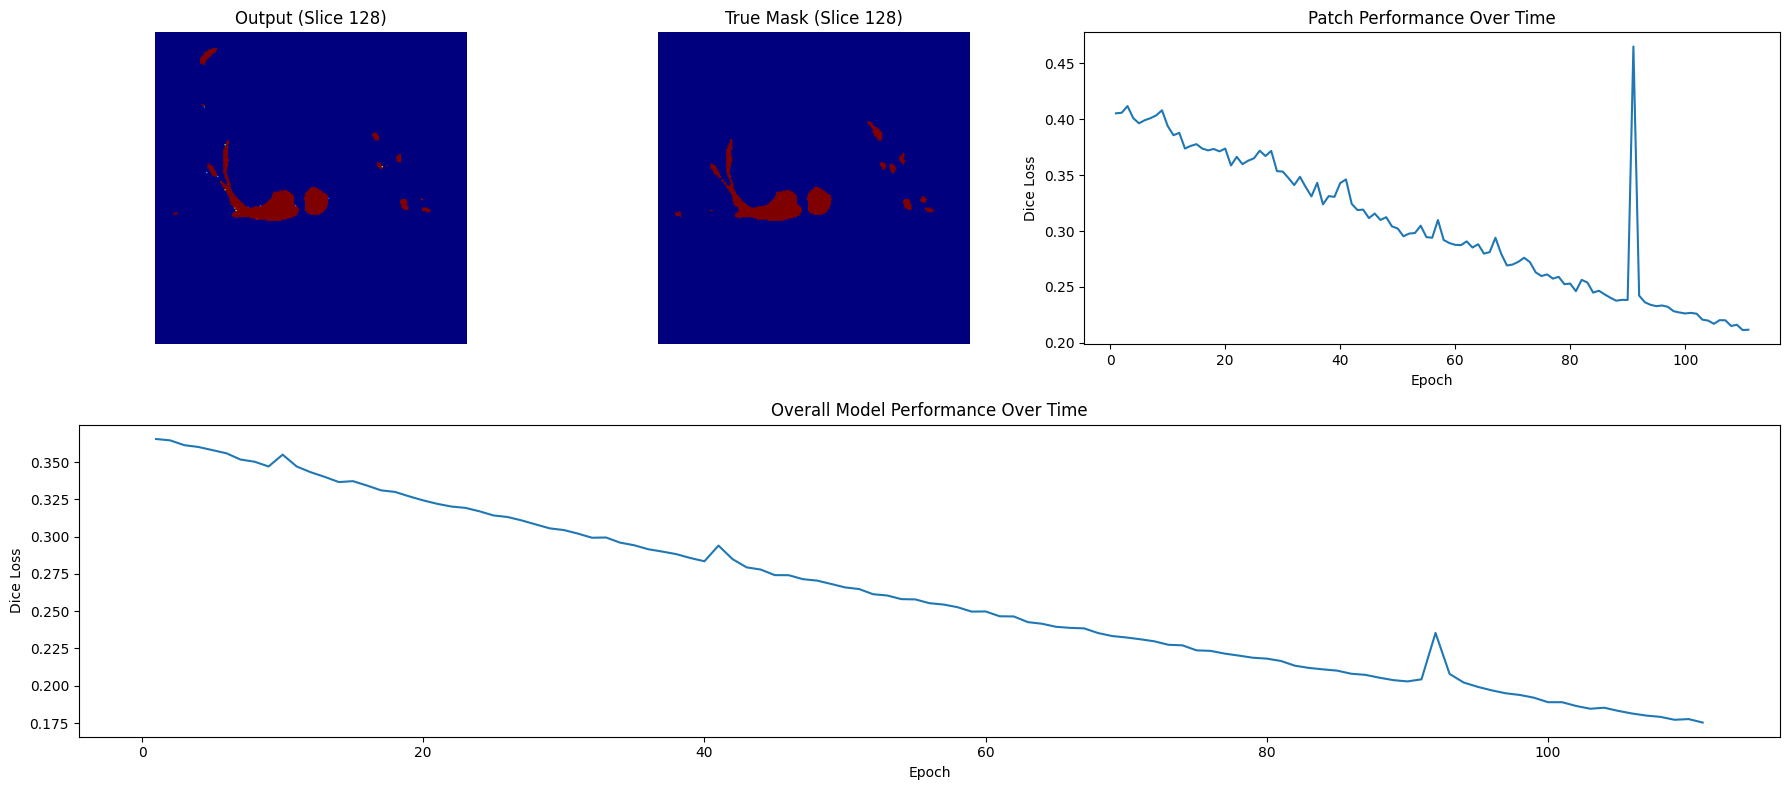

Checkpoint saved at epoch 111 to /content/drive/MyDrive/MyCheckpoints/model_epoch_111.pth


Epoch 121/1000: 100%|██████████| 100/100 [01:53<00:00,  1.13s/it]


Epoch [121/1000], Loss: 0.16415819883346558


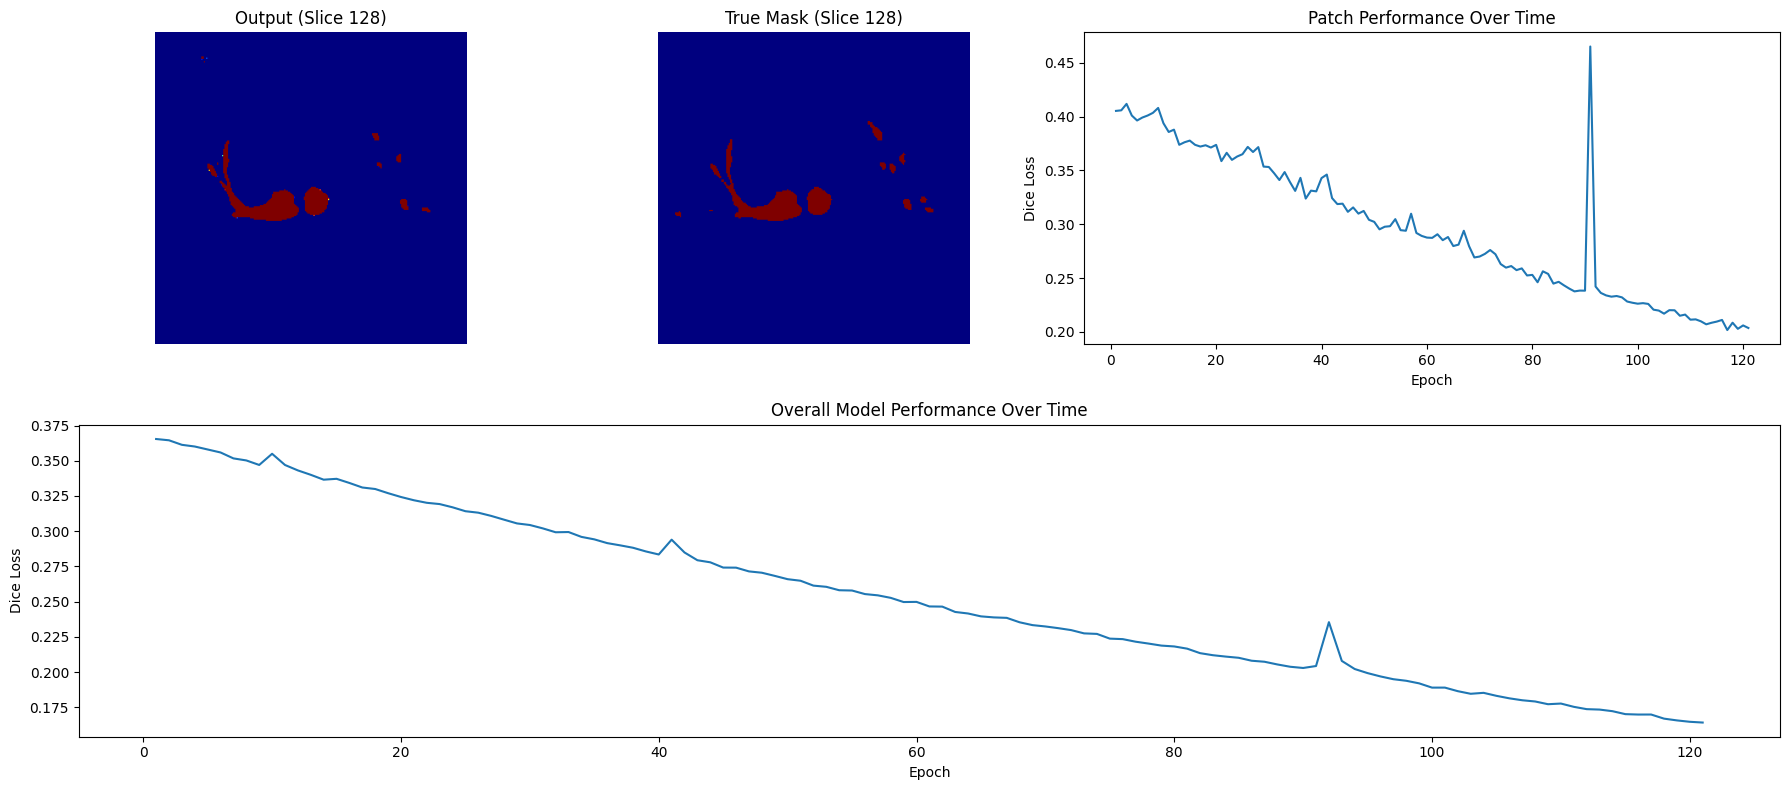

Checkpoint saved at epoch 121 to /content/drive/MyDrive/MyCheckpoints/model_epoch_121.pth


Epoch 131/1000: 100%|██████████| 100/100 [01:52<00:00,  1.13s/it]


Epoch [131/1000], Loss: 0.1532023388147354


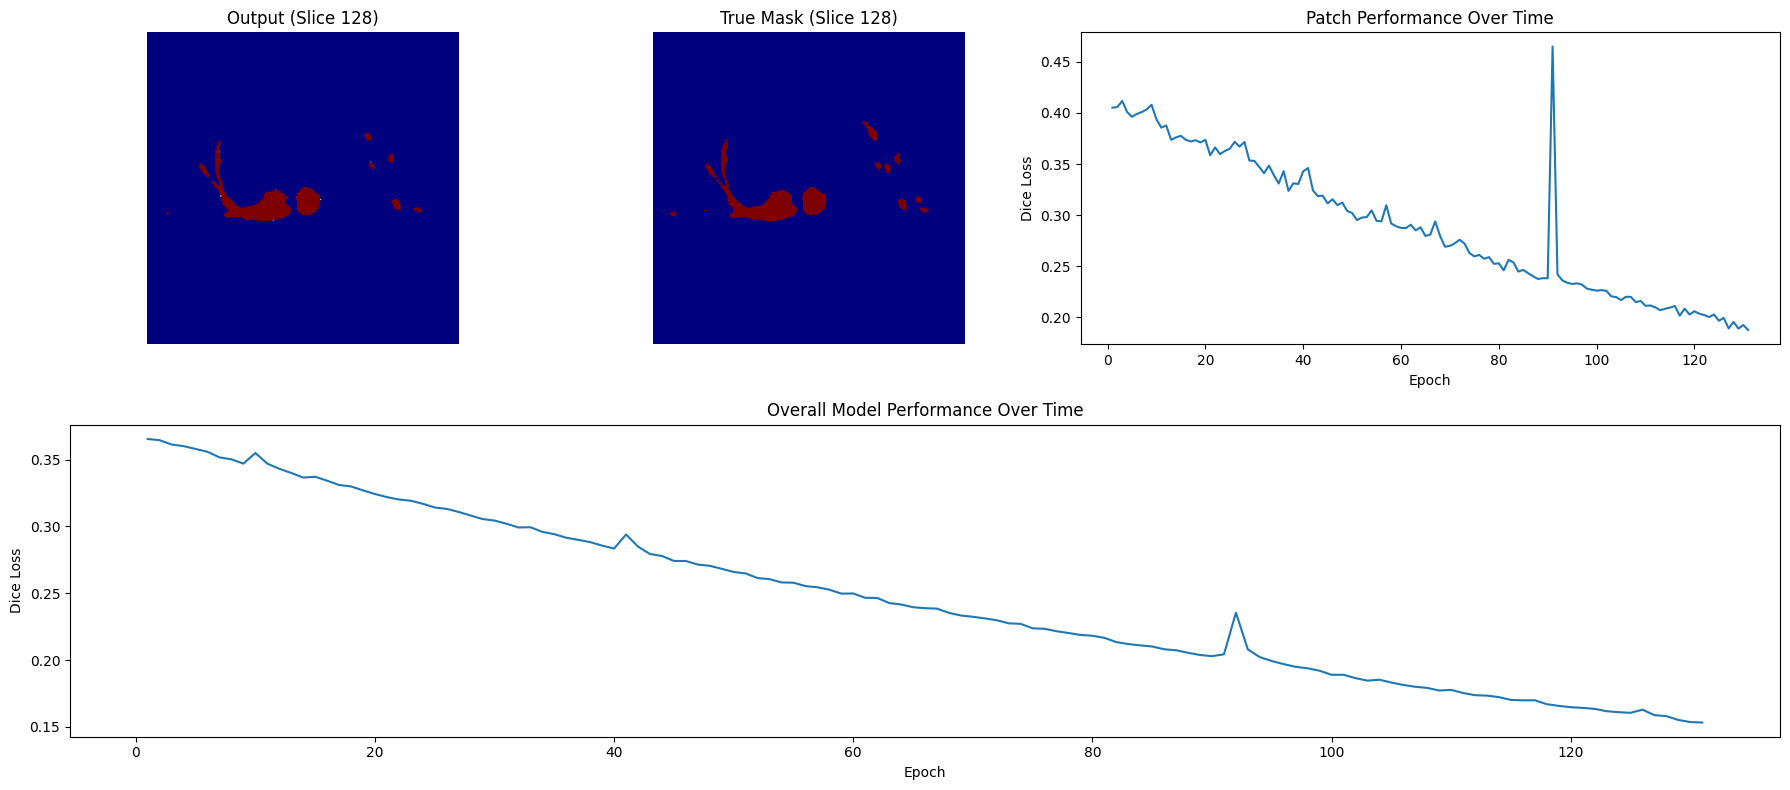

Checkpoint saved at epoch 131 to /content/drive/MyDrive/MyCheckpoints/model_epoch_131.pth


Epoch 141/1000: 100%|██████████| 100/100 [01:51<00:00,  1.12s/it]


Epoch [141/1000], Loss: 0.14356626212596893


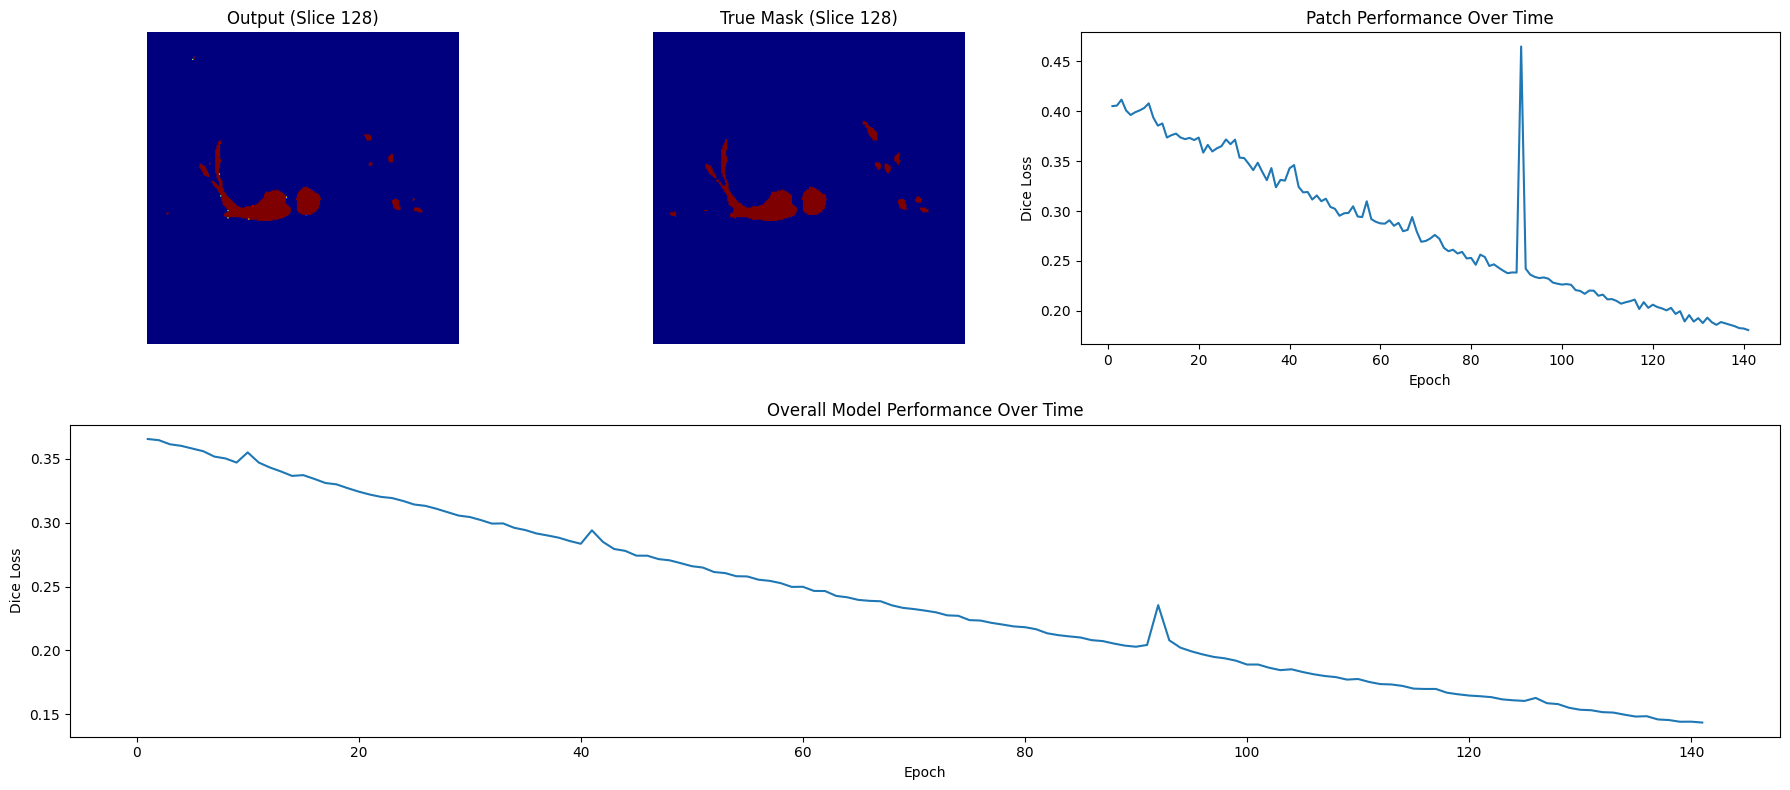

Checkpoint saved at epoch 141 to /content/drive/MyDrive/MyCheckpoints/model_epoch_141.pth


Epoch 151/1000: 100%|██████████| 100/100 [01:52<00:00,  1.13s/it]


Epoch [151/1000], Loss: 0.13276571571826934


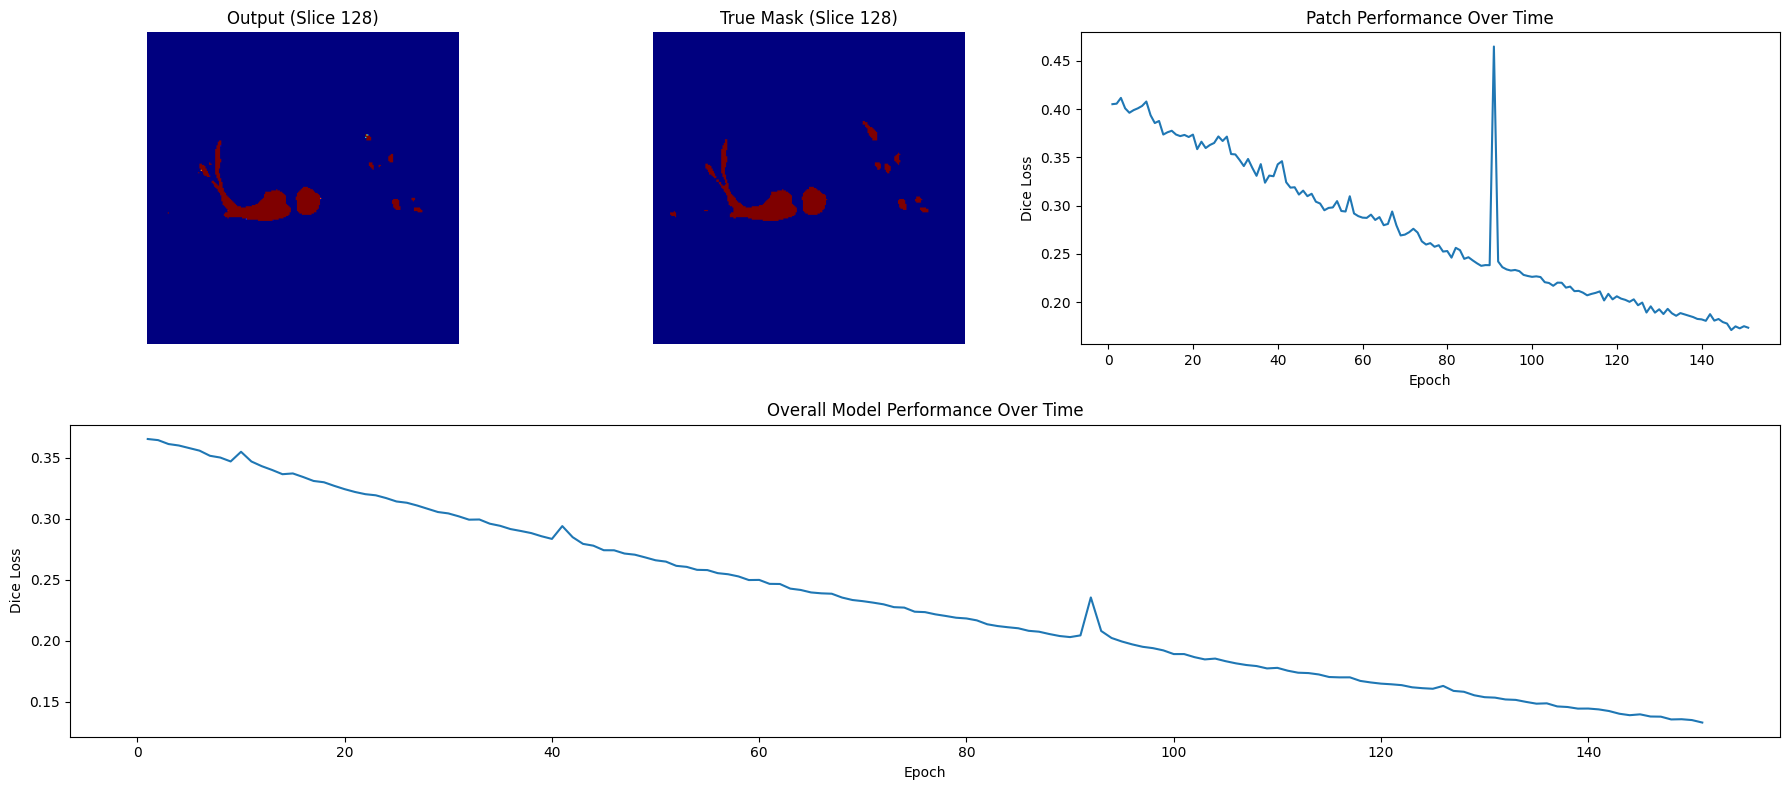

Checkpoint saved at epoch 151 to /content/drive/MyDrive/MyCheckpoints/model_epoch_151.pth


Epoch 161/1000: 100%|██████████| 100/100 [01:52<00:00,  1.12s/it]


Epoch [161/1000], Loss: 0.12485552489757538


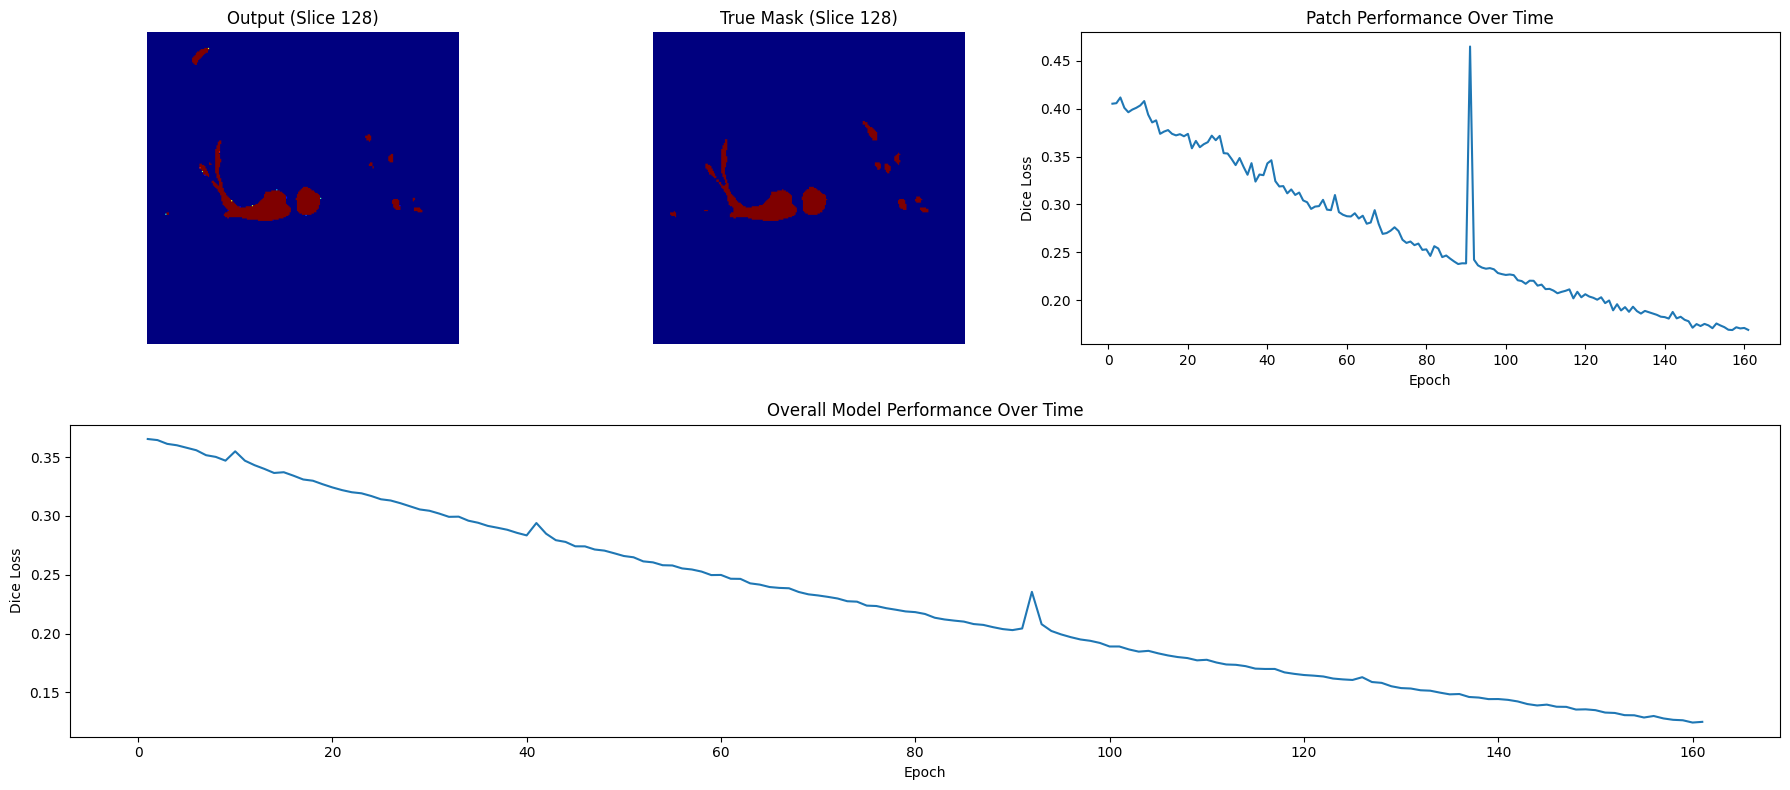

Checkpoint saved at epoch 161 to /content/drive/MyDrive/MyCheckpoints/model_epoch_161.pth


Epoch 171/1000: 100%|██████████| 100/100 [01:52<00:00,  1.13s/it]


Epoch [171/1000], Loss: 0.11707971453666687


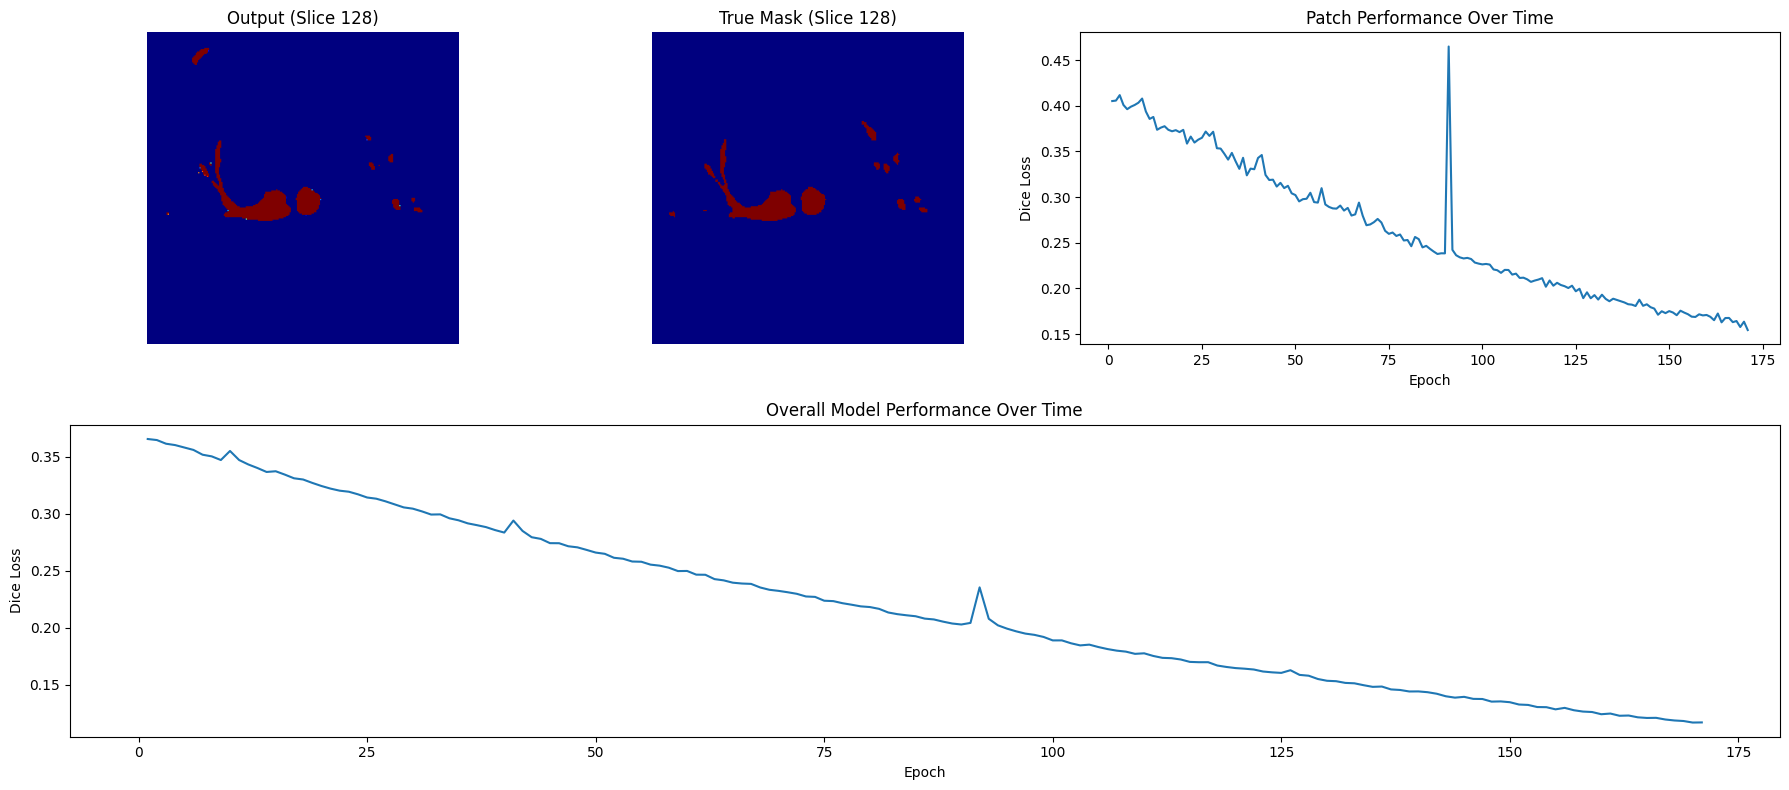

Checkpoint saved at epoch 171 to /content/drive/MyDrive/MyCheckpoints/model_epoch_171.pth


Epoch 181/1000: 100%|██████████| 100/100 [01:52<00:00,  1.13s/it]


Epoch [181/1000], Loss: 0.10953669548034668


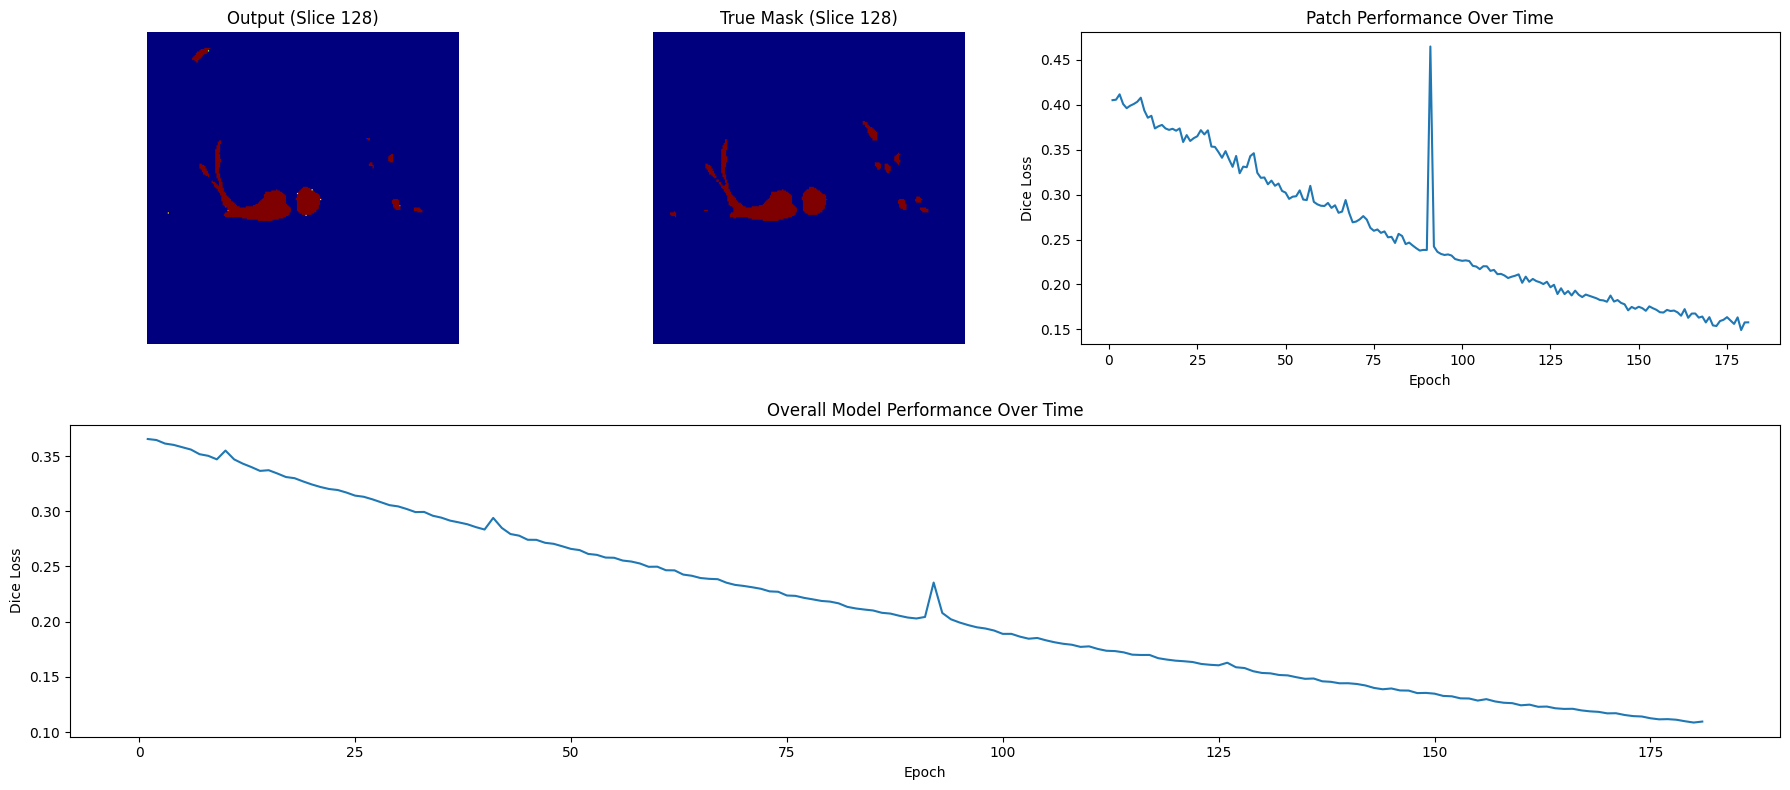

Checkpoint saved at epoch 181 to /content/drive/MyDrive/MyCheckpoints/model_epoch_181.pth


Epoch 191/1000: 100%|██████████| 100/100 [01:52<00:00,  1.12s/it]


Epoch [191/1000], Loss: 0.10290950417518616


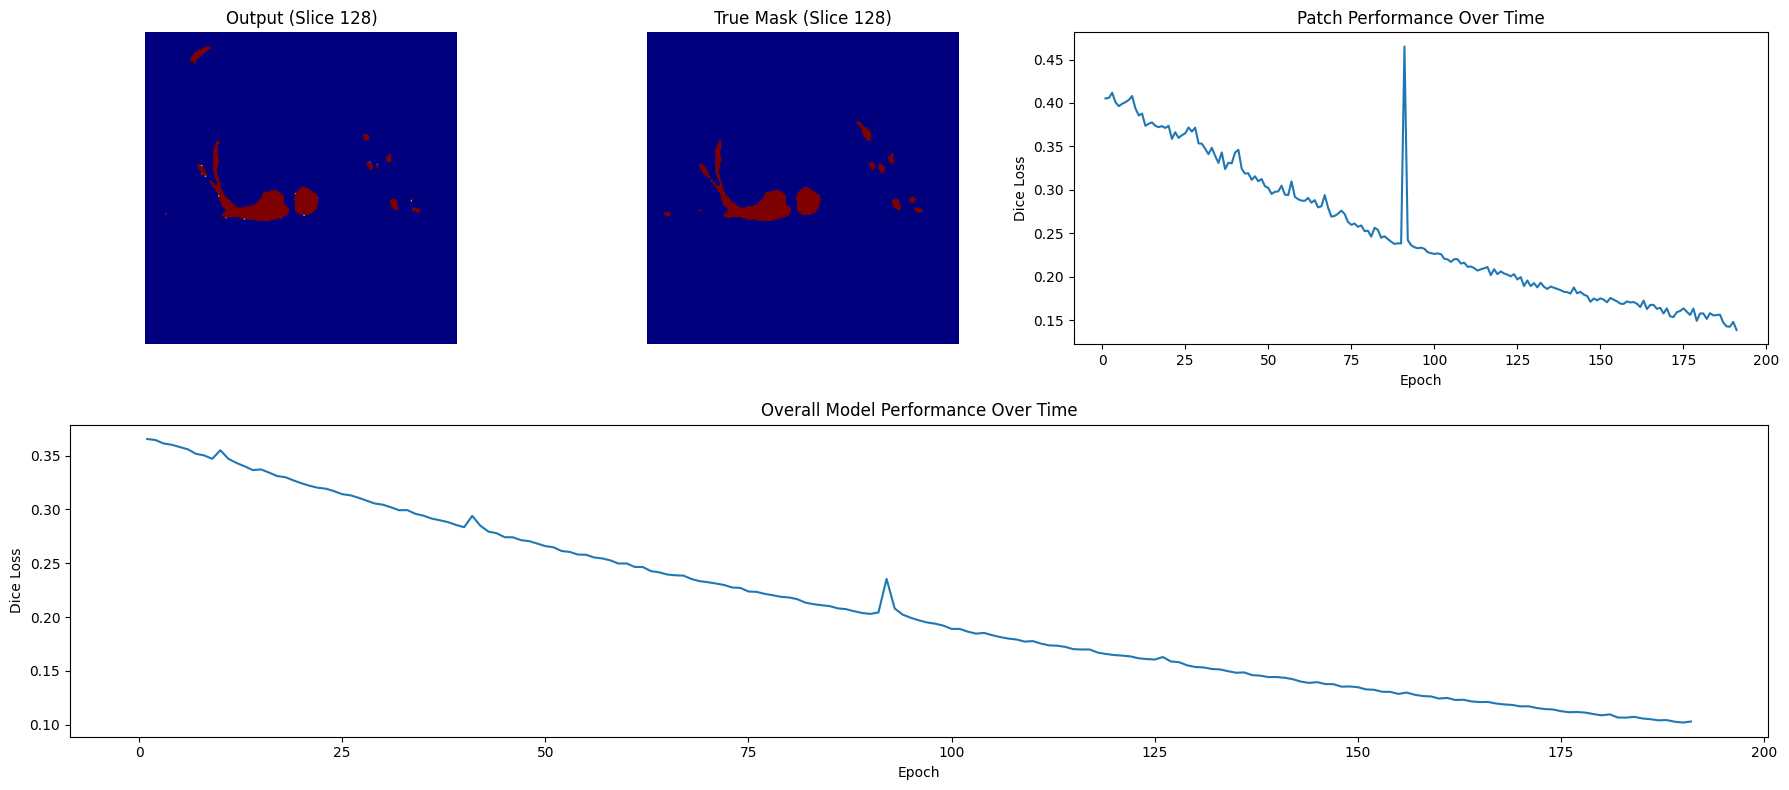

Checkpoint saved at epoch 191 to /content/drive/MyDrive/MyCheckpoints/model_epoch_191.pth


Epoch 201/1000: 100%|██████████| 100/100 [01:52<00:00,  1.12s/it]


Epoch [201/1000], Loss: 0.09511855244636536


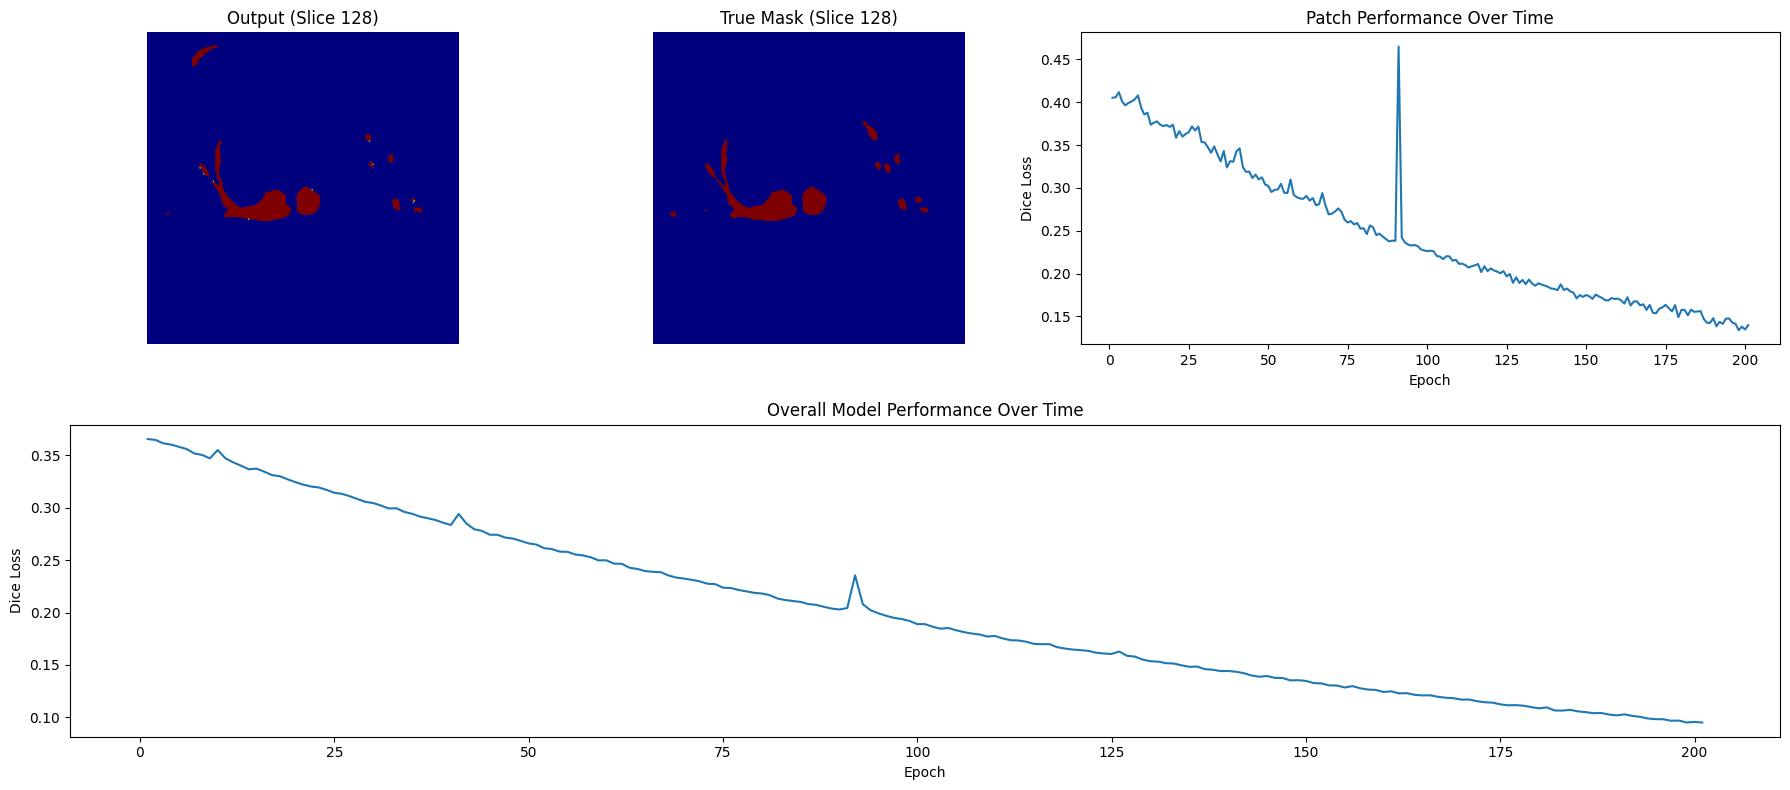

Checkpoint saved at epoch 201 to /content/drive/MyDrive/MyCheckpoints/model_epoch_201.pth


Epoch 211/1000: 100%|██████████| 100/100 [01:52<00:00,  1.13s/it]


Epoch [211/1000], Loss: 0.08947377026081085


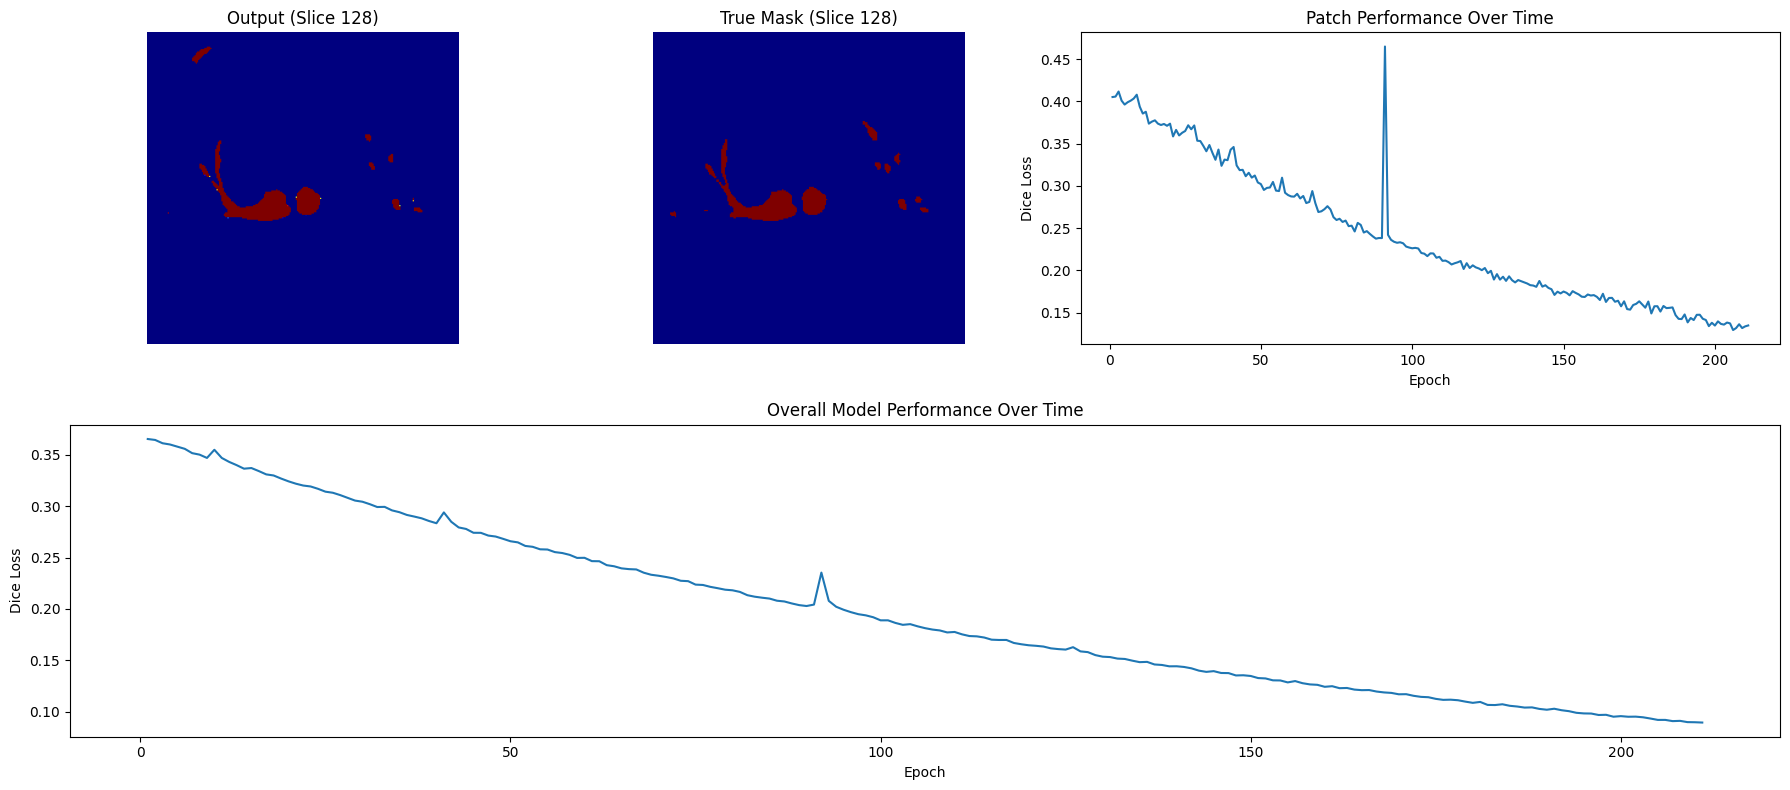

Checkpoint saved at epoch 211 to /content/drive/MyDrive/MyCheckpoints/model_epoch_211.pth


Epoch 214/1000:  64%|██████▍   | 64/100 [01:10<00:35,  1.00it/s]

In [ ]:
# epochs till 300

## epochs till 400

<ipython-input-13-aaca5dd2af48>:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)
Epoch 1/1000: 100%|██████████| 100/100 [02:02<00:0

Epoch [1/1000], Loss: 0.08745328307151795


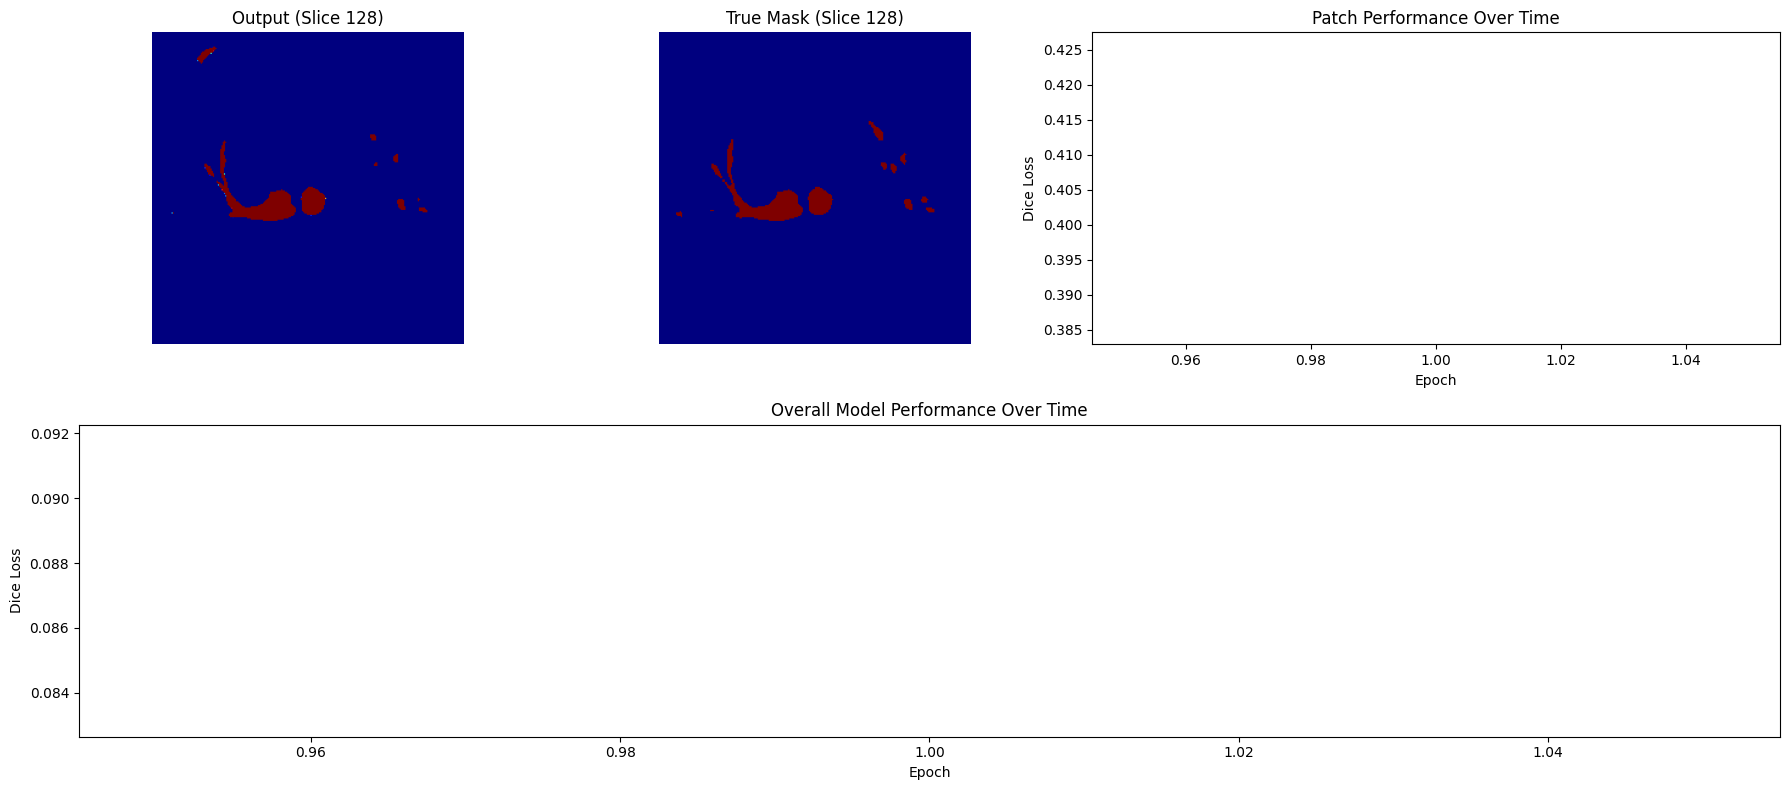

Checkpoint saved at epoch 1 to /content/drive/MyDrive/MyCheckpoints/model_epoch_1.pth


Epoch 11/1000: 100%|██████████| 100/100 [01:54<00:00,  1.15s/it]


Epoch [11/1000], Loss: 0.08328510224819183


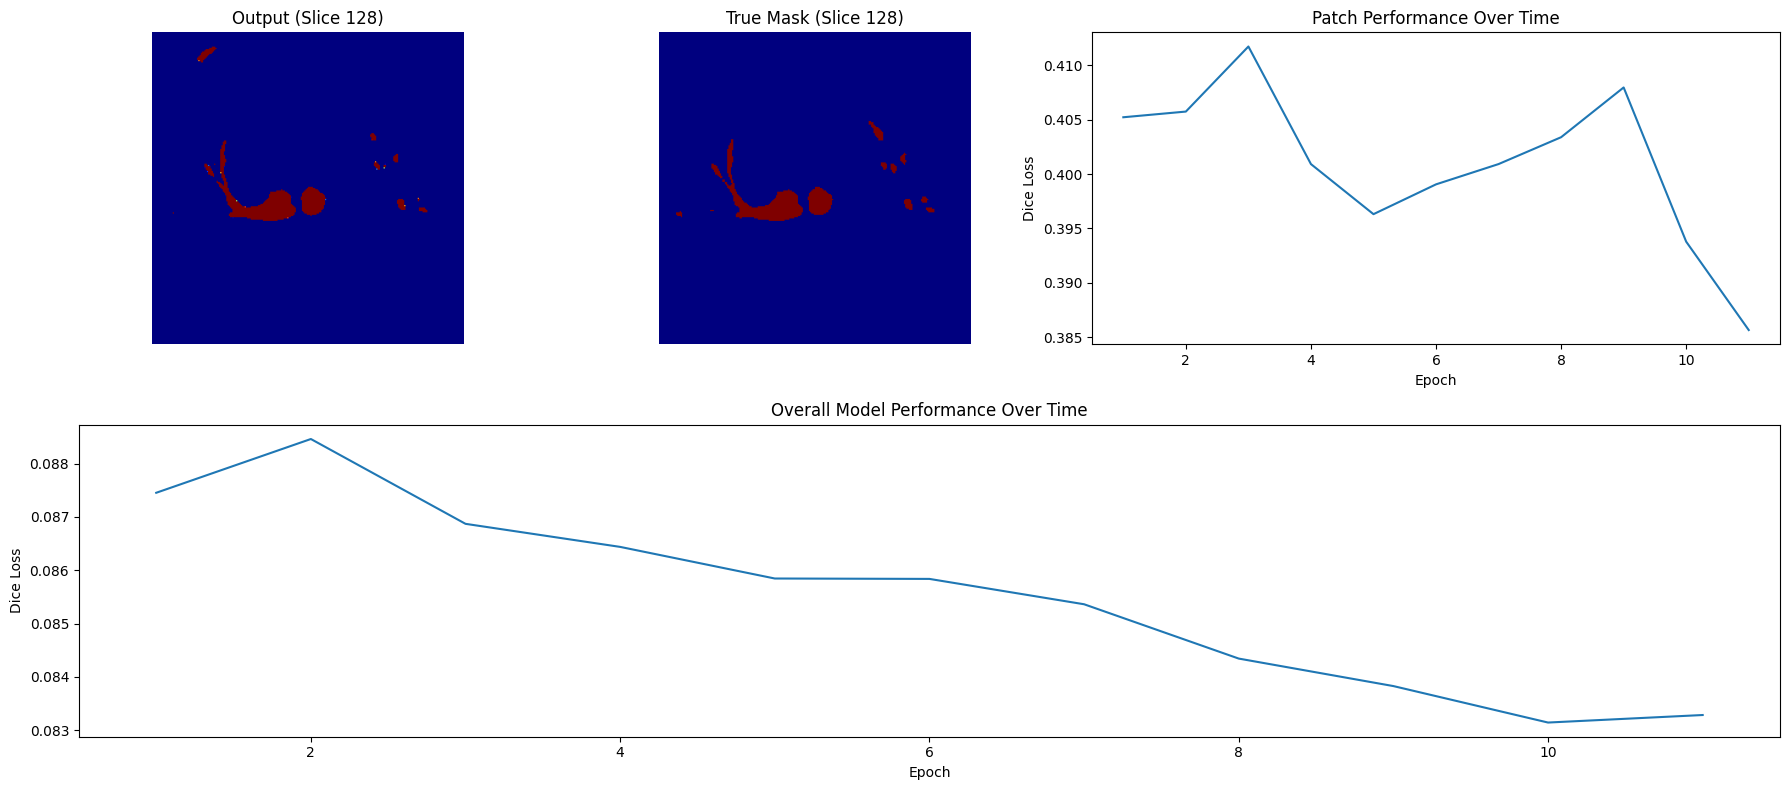

Checkpoint saved at epoch 11 to /content/drive/MyDrive/MyCheckpoints/model_epoch_11.pth


Epoch 21/1000: 100%|██████████| 100/100 [01:53<00:00,  1.14s/it]


Epoch [21/1000], Loss: 0.07779434621334076


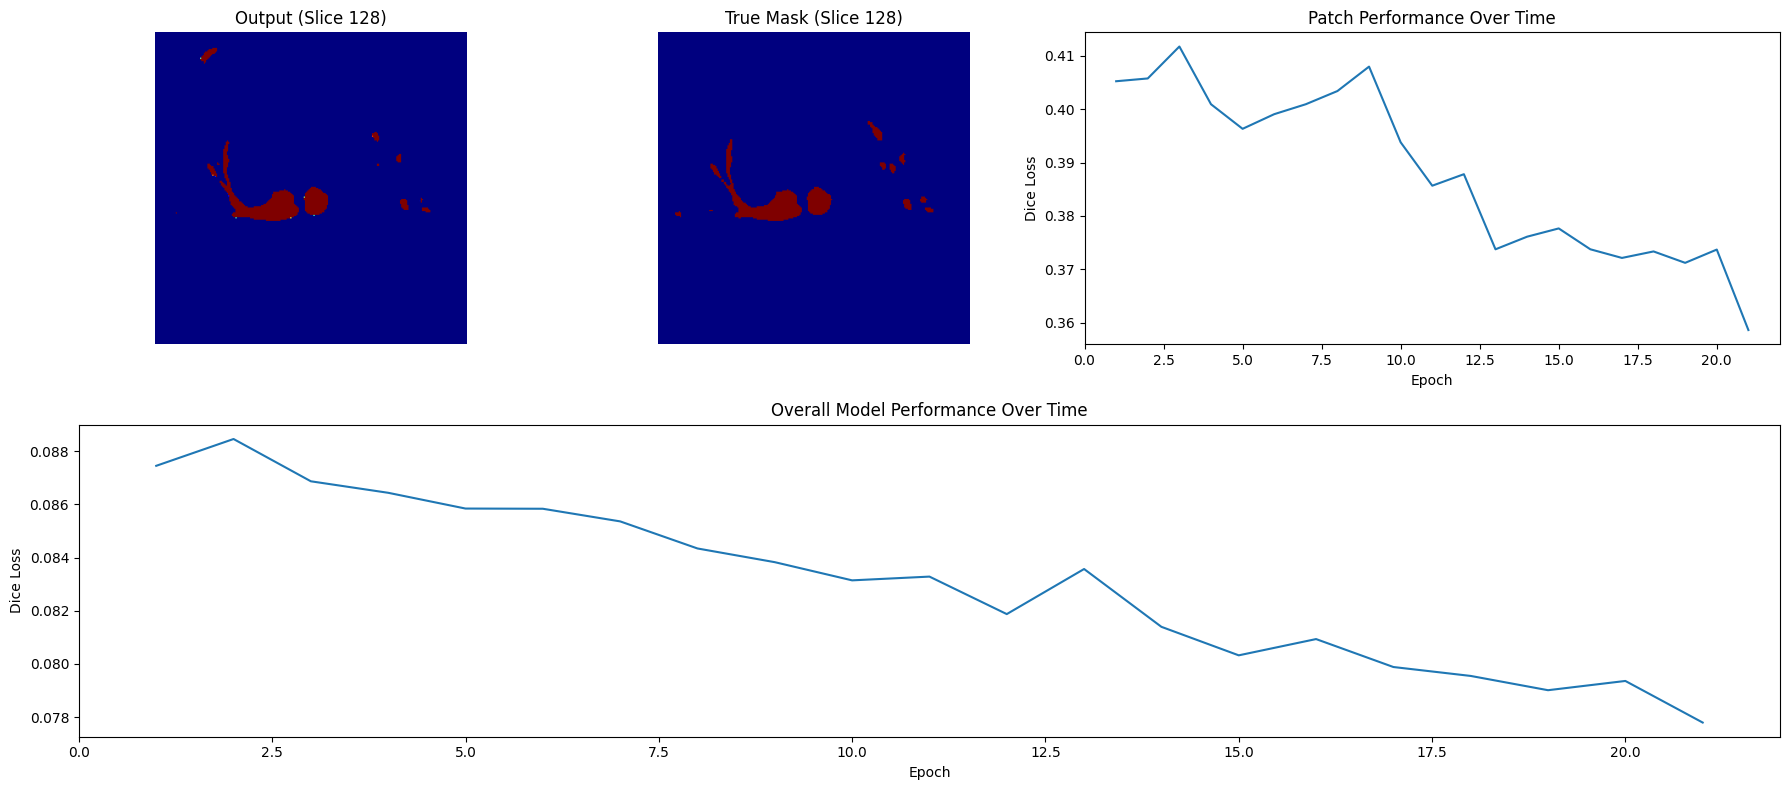

Checkpoint saved at epoch 21 to /content/drive/MyDrive/MyCheckpoints/model_epoch_21.pth


Epoch 31/1000: 100%|██████████| 100/100 [01:53<00:00,  1.13s/it]


Epoch [31/1000], Loss: 0.07302077412605286


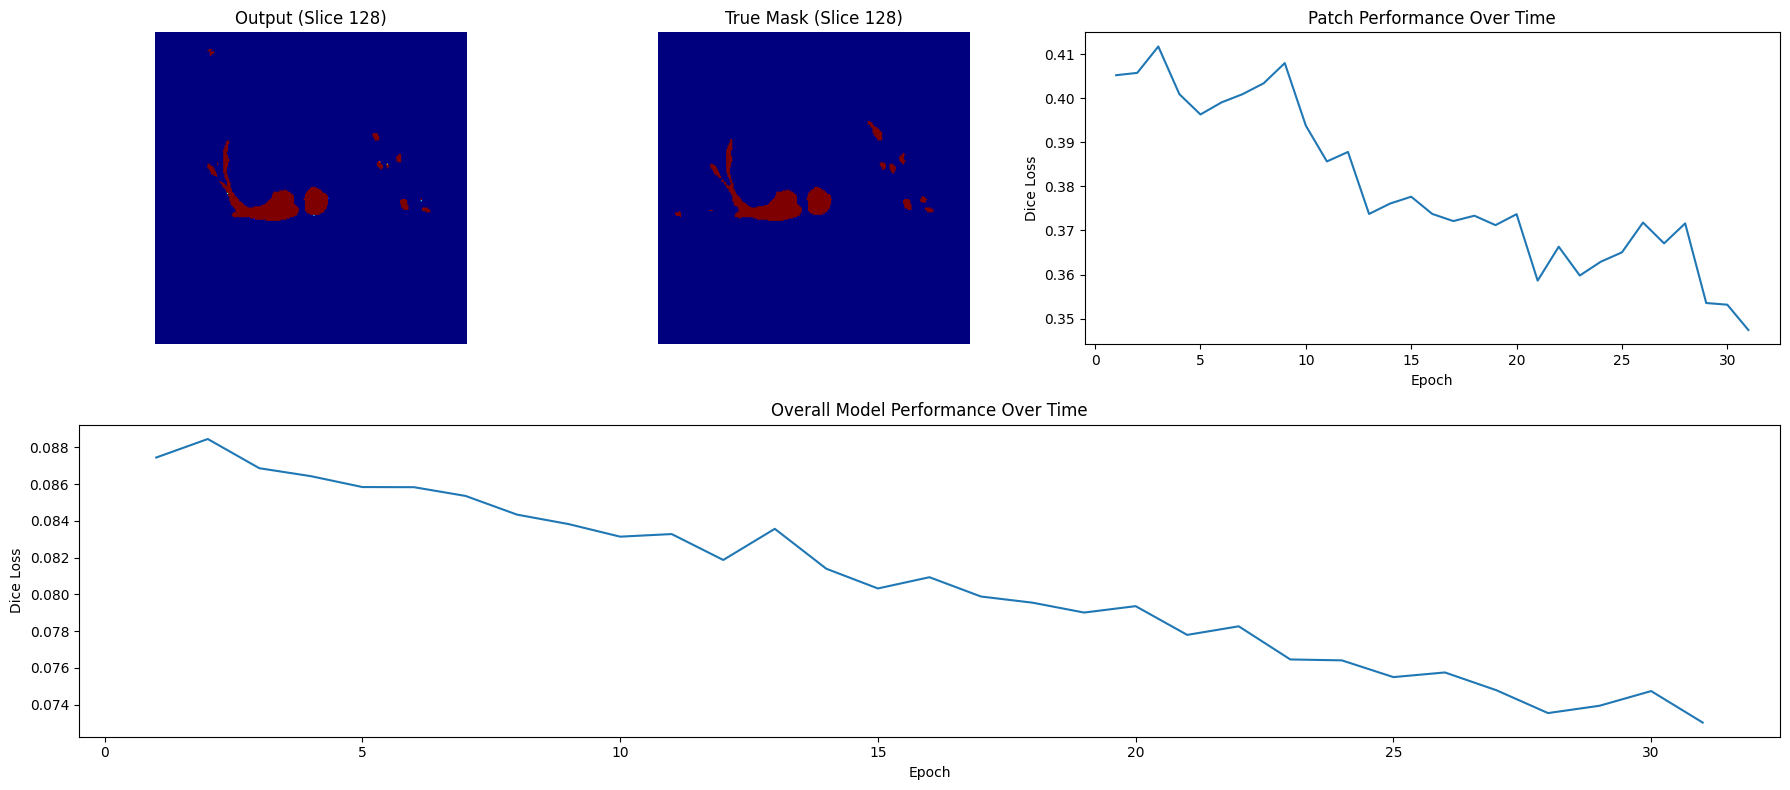

Checkpoint saved at epoch 31 to /content/drive/MyDrive/MyCheckpoints/model_epoch_31.pth


Epoch 41/1000: 100%|██████████| 100/100 [01:53<00:00,  1.13s/it]


Epoch [41/1000], Loss: 0.06921006500720978


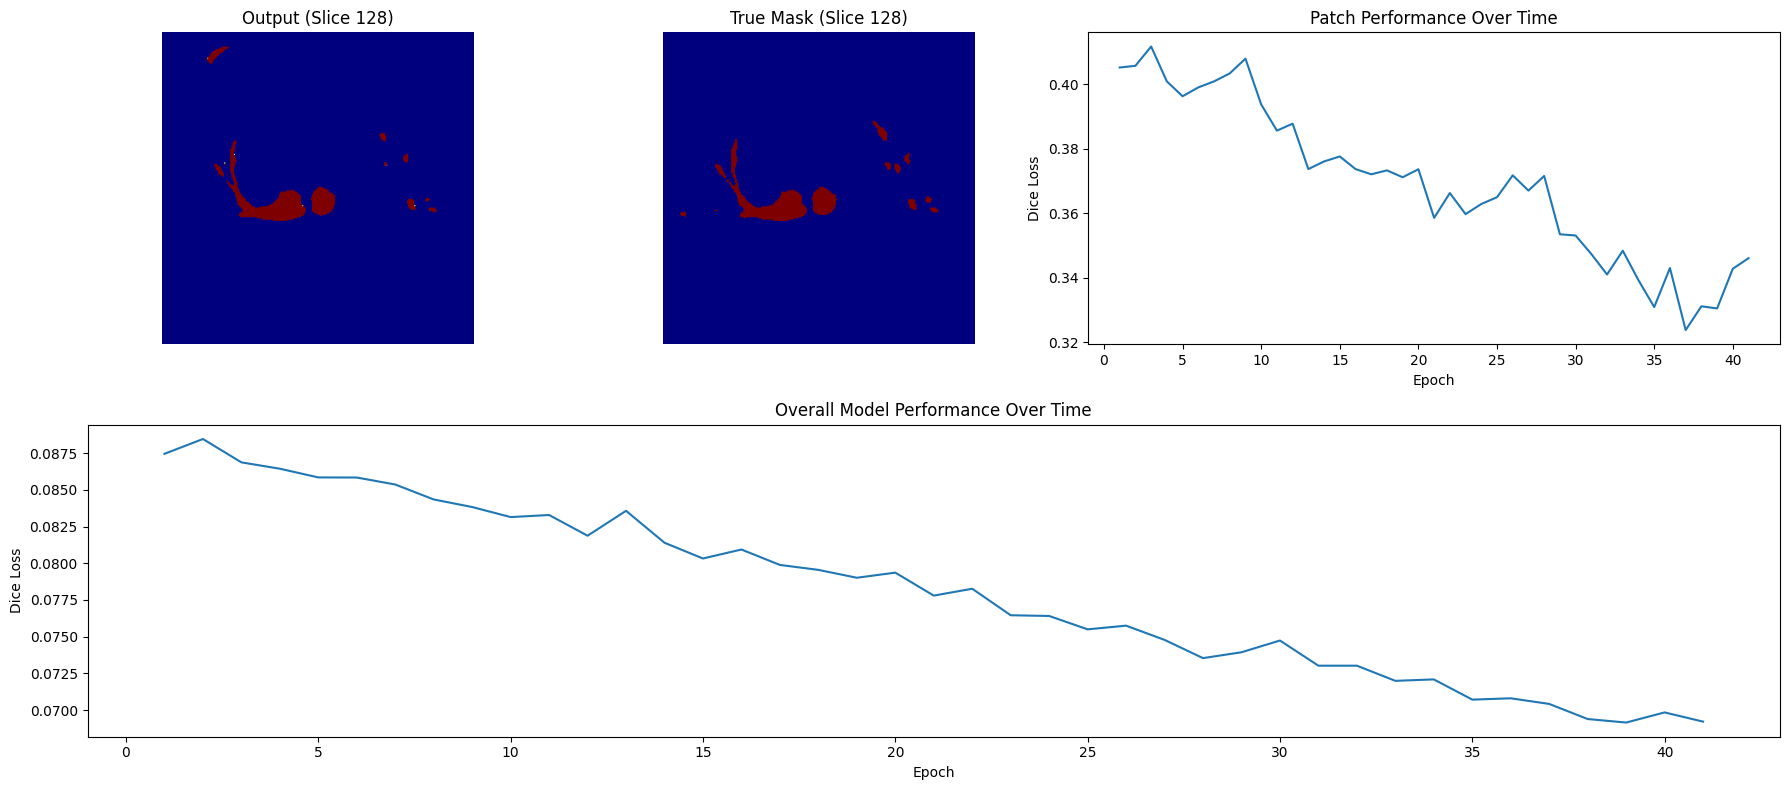

Checkpoint saved at epoch 41 to /content/drive/MyDrive/MyCheckpoints/model_epoch_41.pth


Epoch 51/1000: 100%|██████████| 100/100 [01:52<00:00,  1.13s/it]


Epoch [51/1000], Loss: 0.06520882964134217


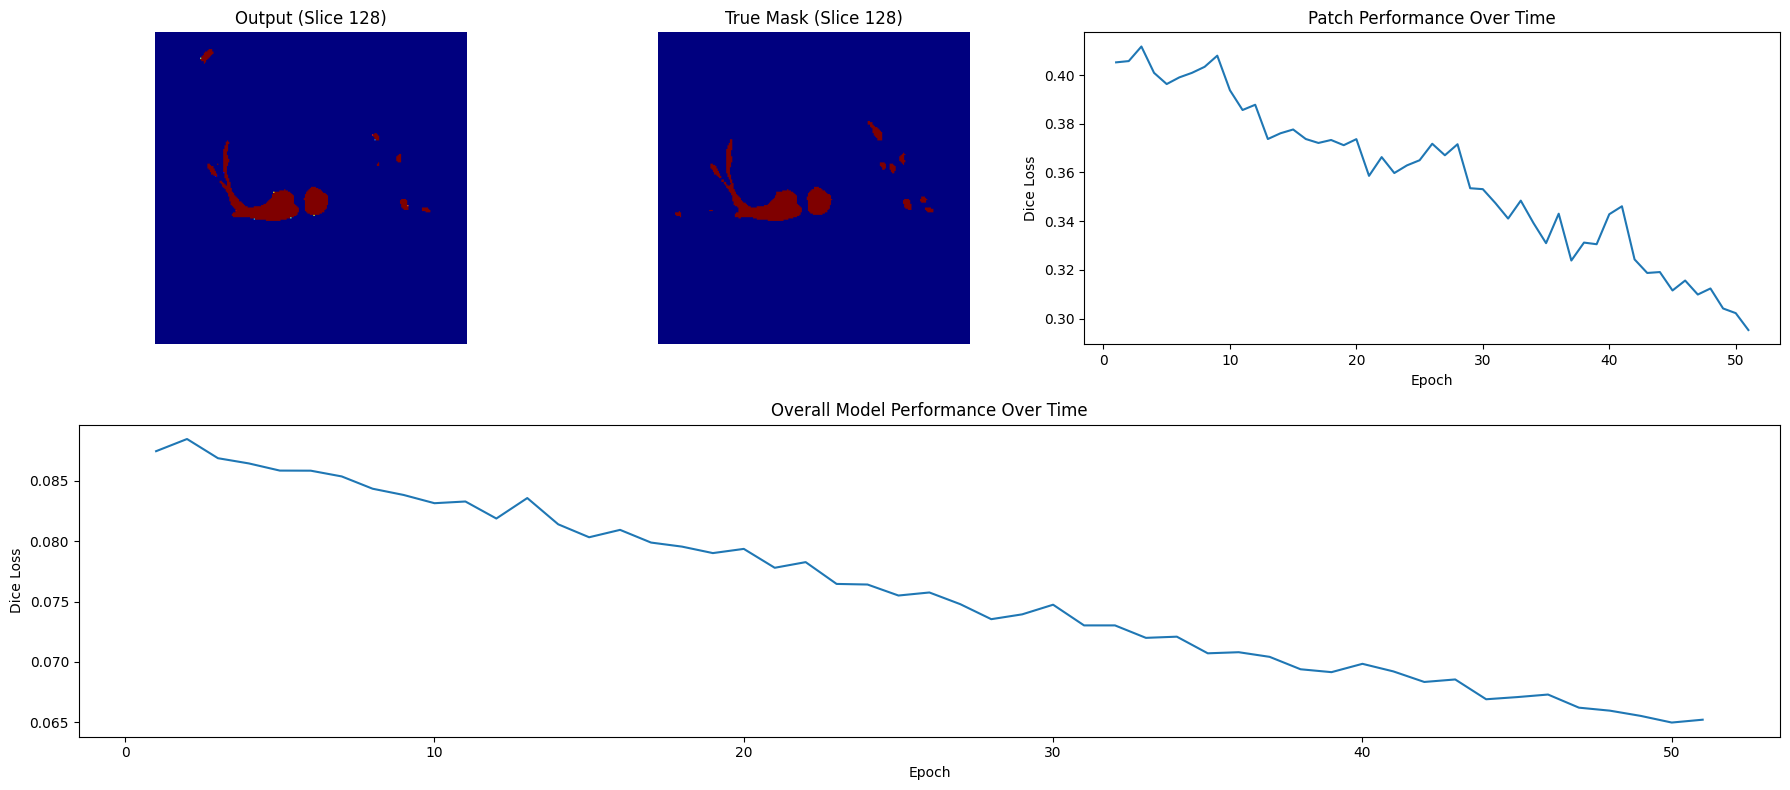

Checkpoint saved at epoch 51 to /content/drive/MyDrive/MyCheckpoints/model_epoch_51.pth


Epoch 61/1000: 100%|██████████| 100/100 [01:53<00:00,  1.13s/it]


Epoch [61/1000], Loss: 0.06104502856731415


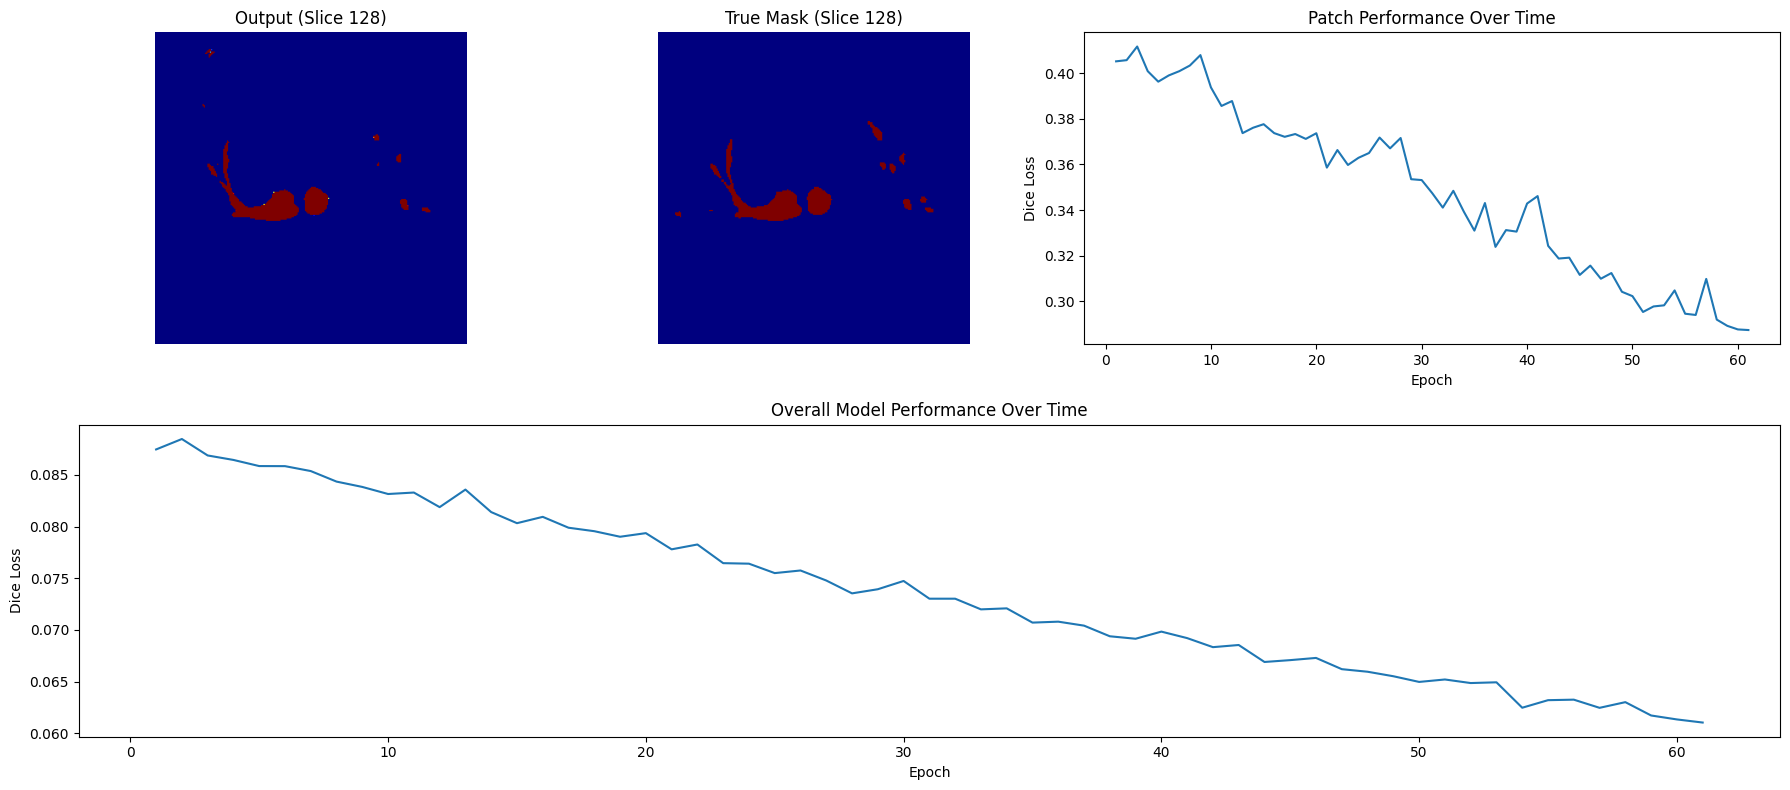

Checkpoint saved at epoch 61 to /content/drive/MyDrive/MyCheckpoints/model_epoch_61.pth


Epoch 71/1000: 100%|██████████| 100/100 [01:53<00:00,  1.13s/it]


Epoch [71/1000], Loss: 0.05798594057559967


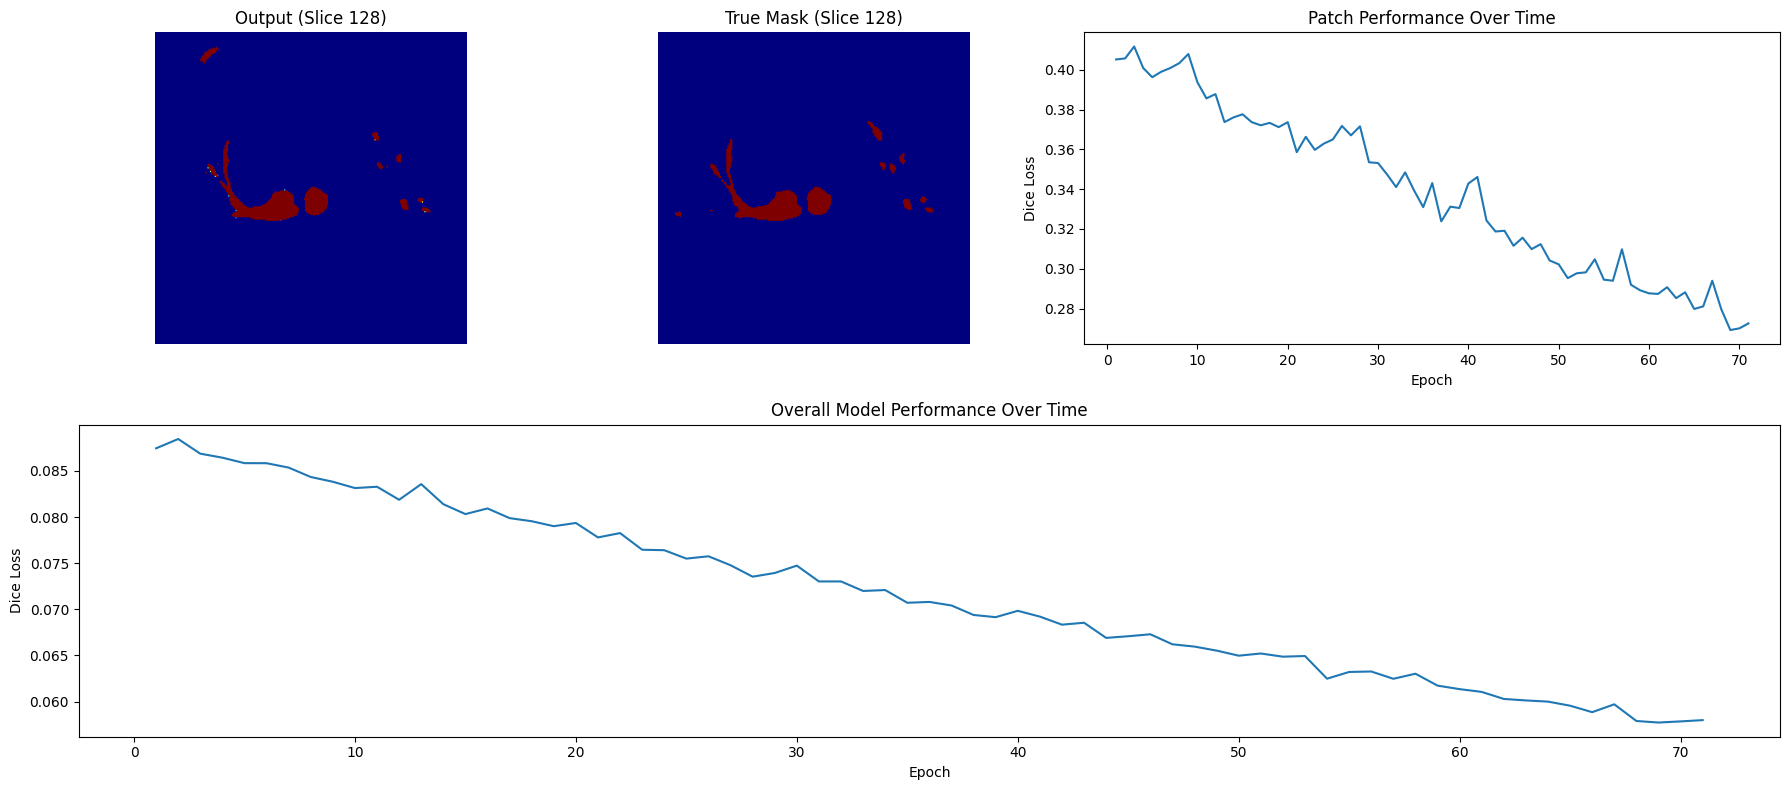

Checkpoint saved at epoch 71 to /content/drive/MyDrive/MyCheckpoints/model_epoch_71.pth


Epoch 81/1000: 100%|██████████| 100/100 [01:52<00:00,  1.13s/it]


Epoch [81/1000], Loss: 0.05474615216255188


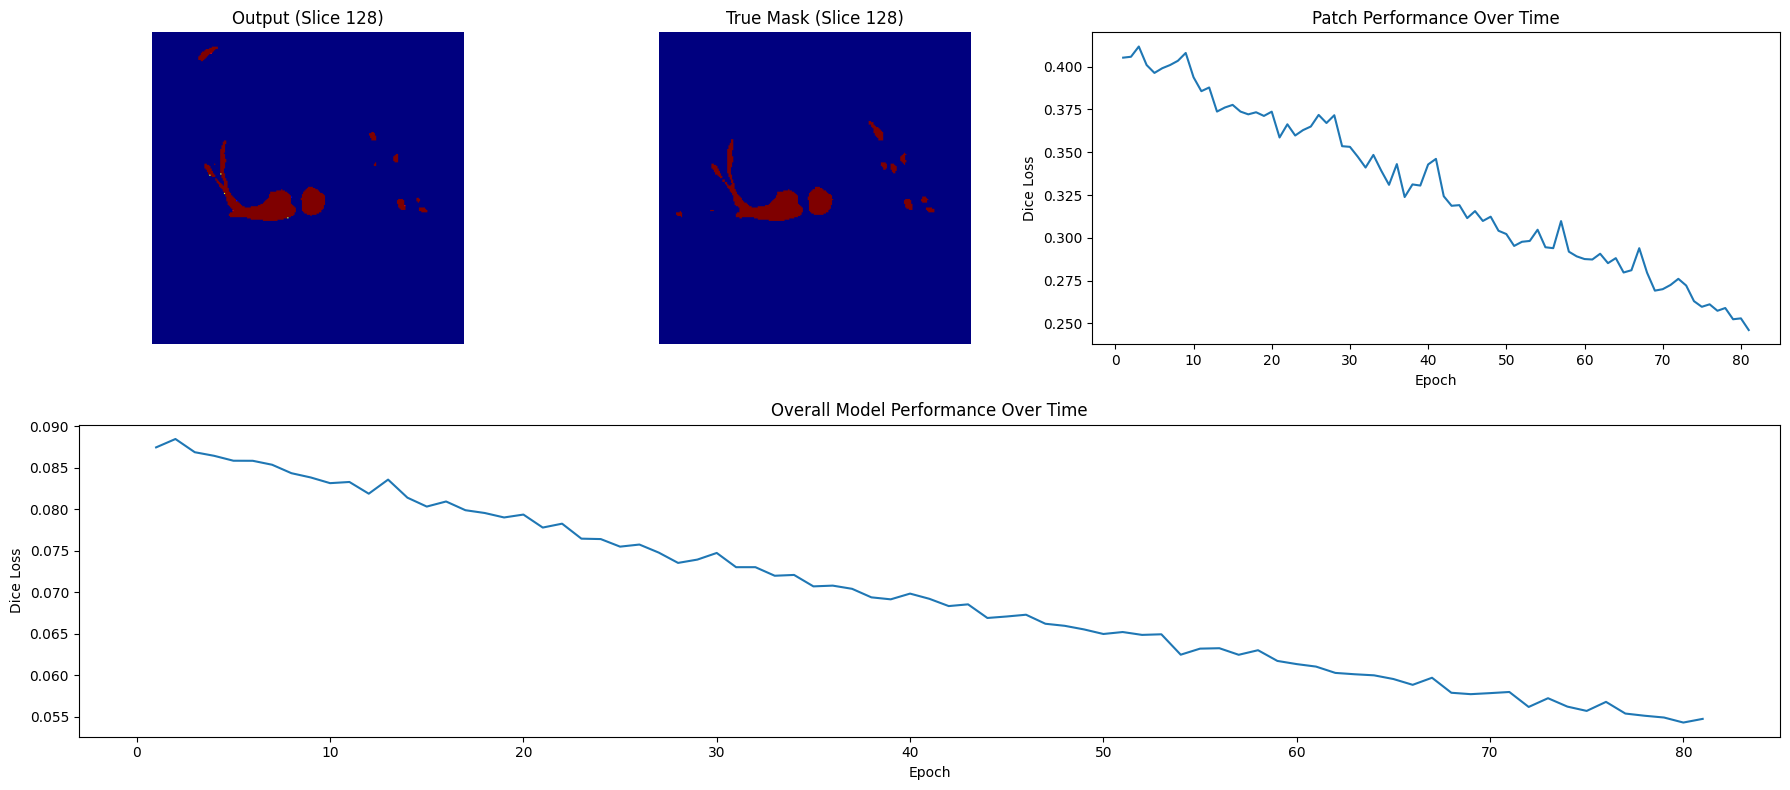

Checkpoint saved at epoch 81 to /content/drive/MyDrive/MyCheckpoints/model_epoch_81.pth


Epoch 91/1000: 100%|██████████| 100/100 [01:53<00:00,  1.13s/it]


Epoch [91/1000], Loss: 0.05089503288269043


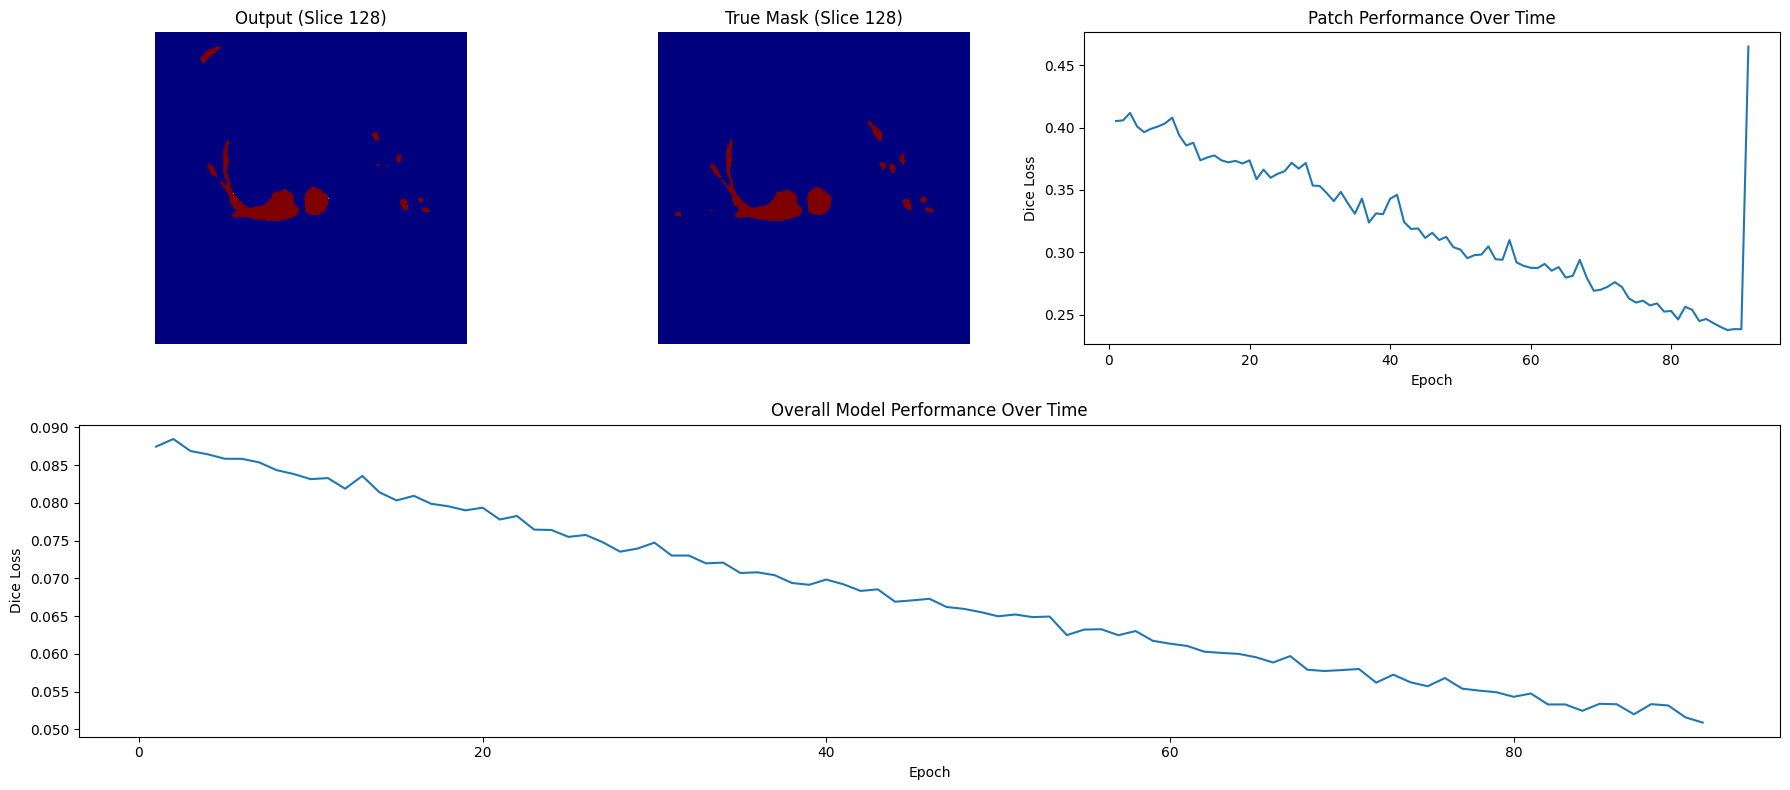

Checkpoint saved at epoch 91 to /content/drive/MyDrive/MyCheckpoints/model_epoch_91.pth


Epoch 101/1000: 100%|██████████| 100/100 [01:52<00:00,  1.13s/it]


Epoch [101/1000], Loss: 0.04898422062397003


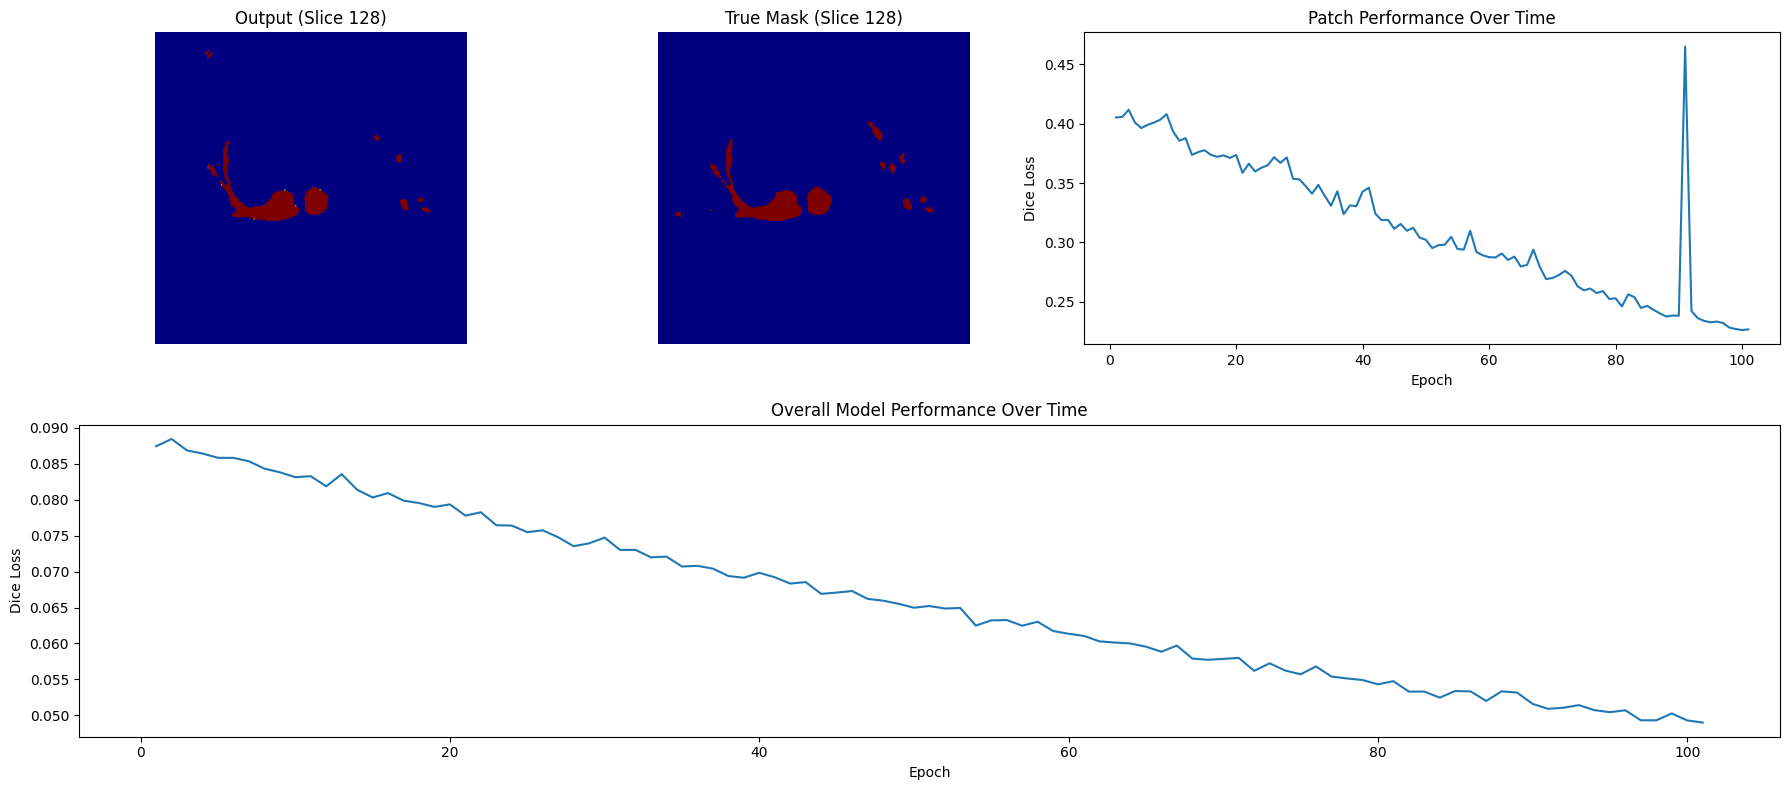

Checkpoint saved at epoch 101 to /content/drive/MyDrive/MyCheckpoints/model_epoch_101.pth


Epoch 111/1000:  17%|█▋        | 17/100 [00:17<01:27,  1.06s/it]

## final epochs

<ipython-input-13-1bdfbbbc1906>:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)
Epoch 1/1000: 100%|██████████| 100/100 [02:02<00:0

Epoch [1/1000], Loss: 0.04885827243328095


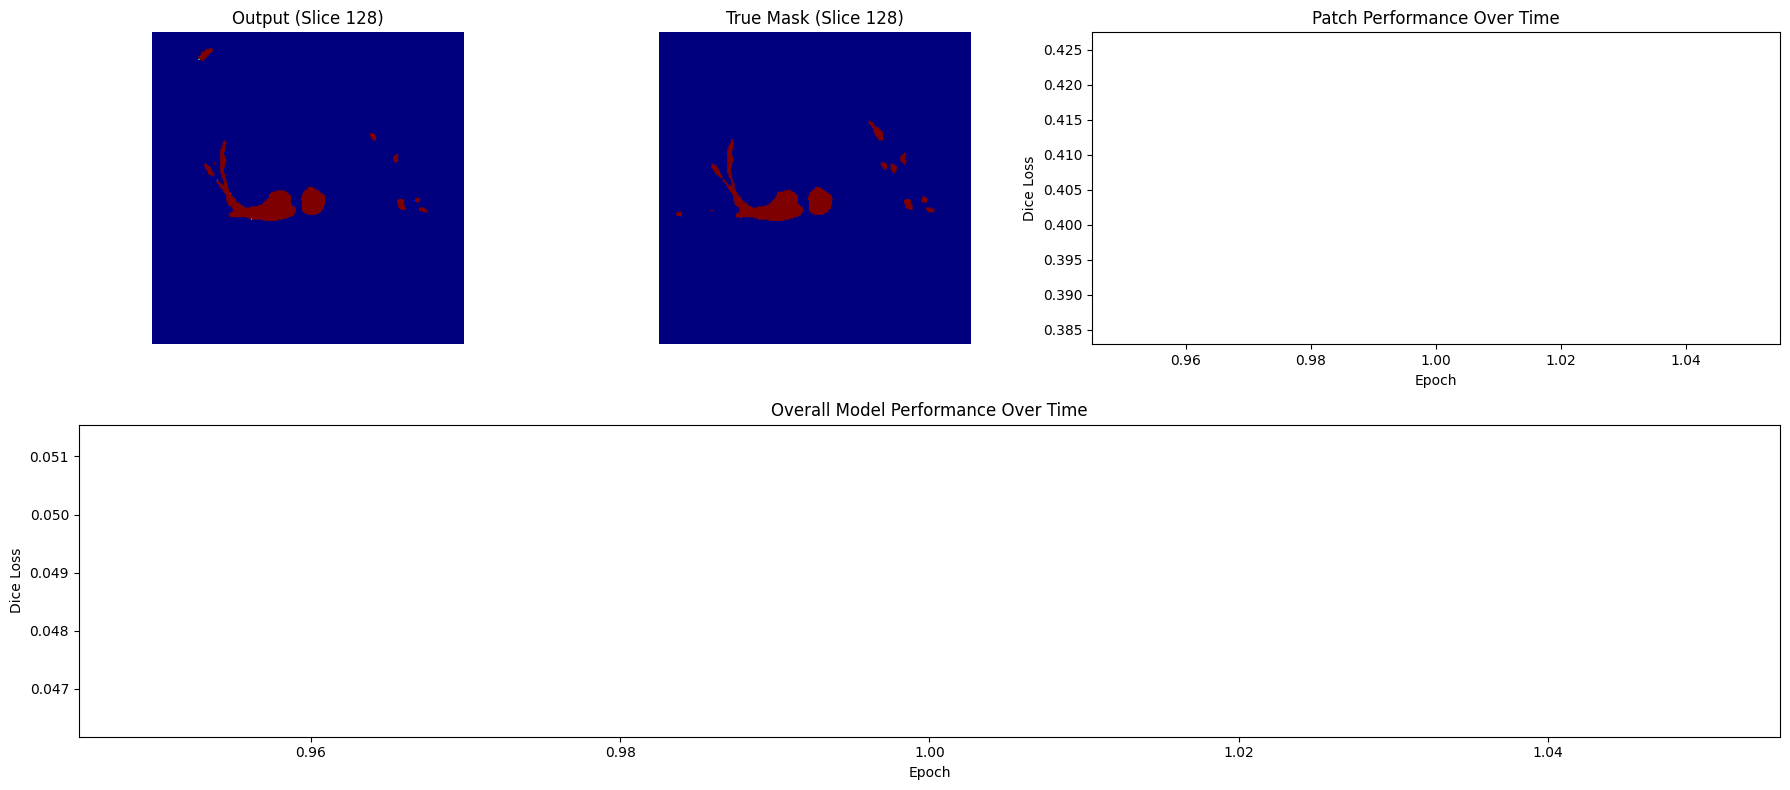

Checkpoint saved at epoch 1 to /content/drive/MyDrive/MyCheckpoints/model_epoch_1.pth


Epoch 11/1000: 100%|██████████| 100/100 [01:54<00:00,  1.14s/it]


Epoch [11/1000], Loss: 0.04583530008792877


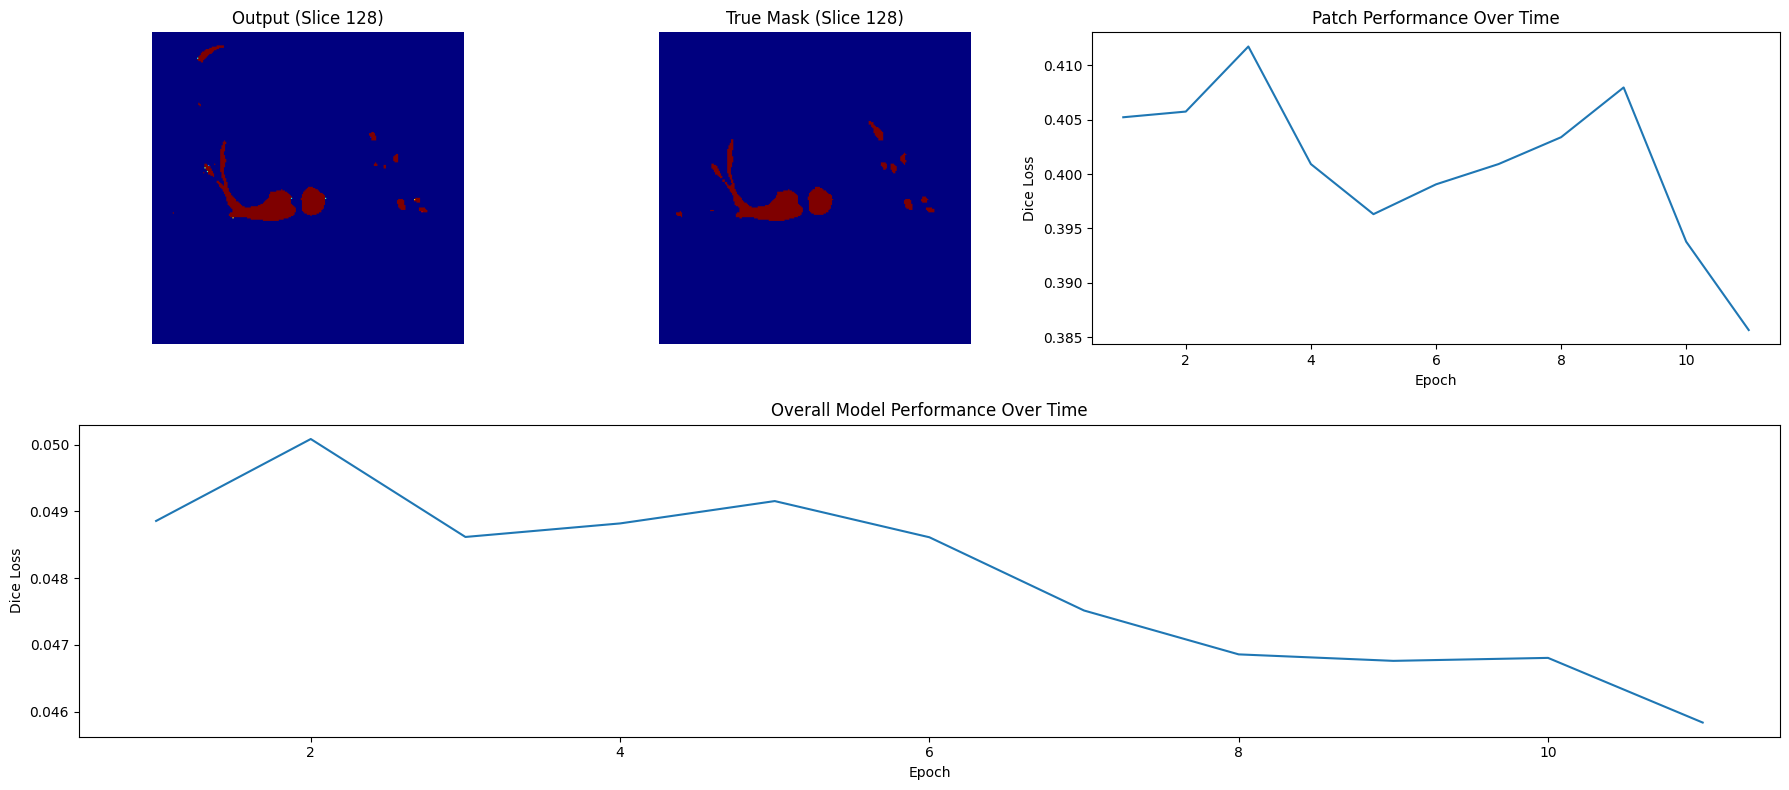

Checkpoint saved at epoch 11 to /content/drive/MyDrive/MyCheckpoints/model_epoch_11.pth


Epoch 21/1000: 100%|██████████| 100/100 [01:53<00:00,  1.14s/it]


Epoch [21/1000], Loss: 0.043534143567085265


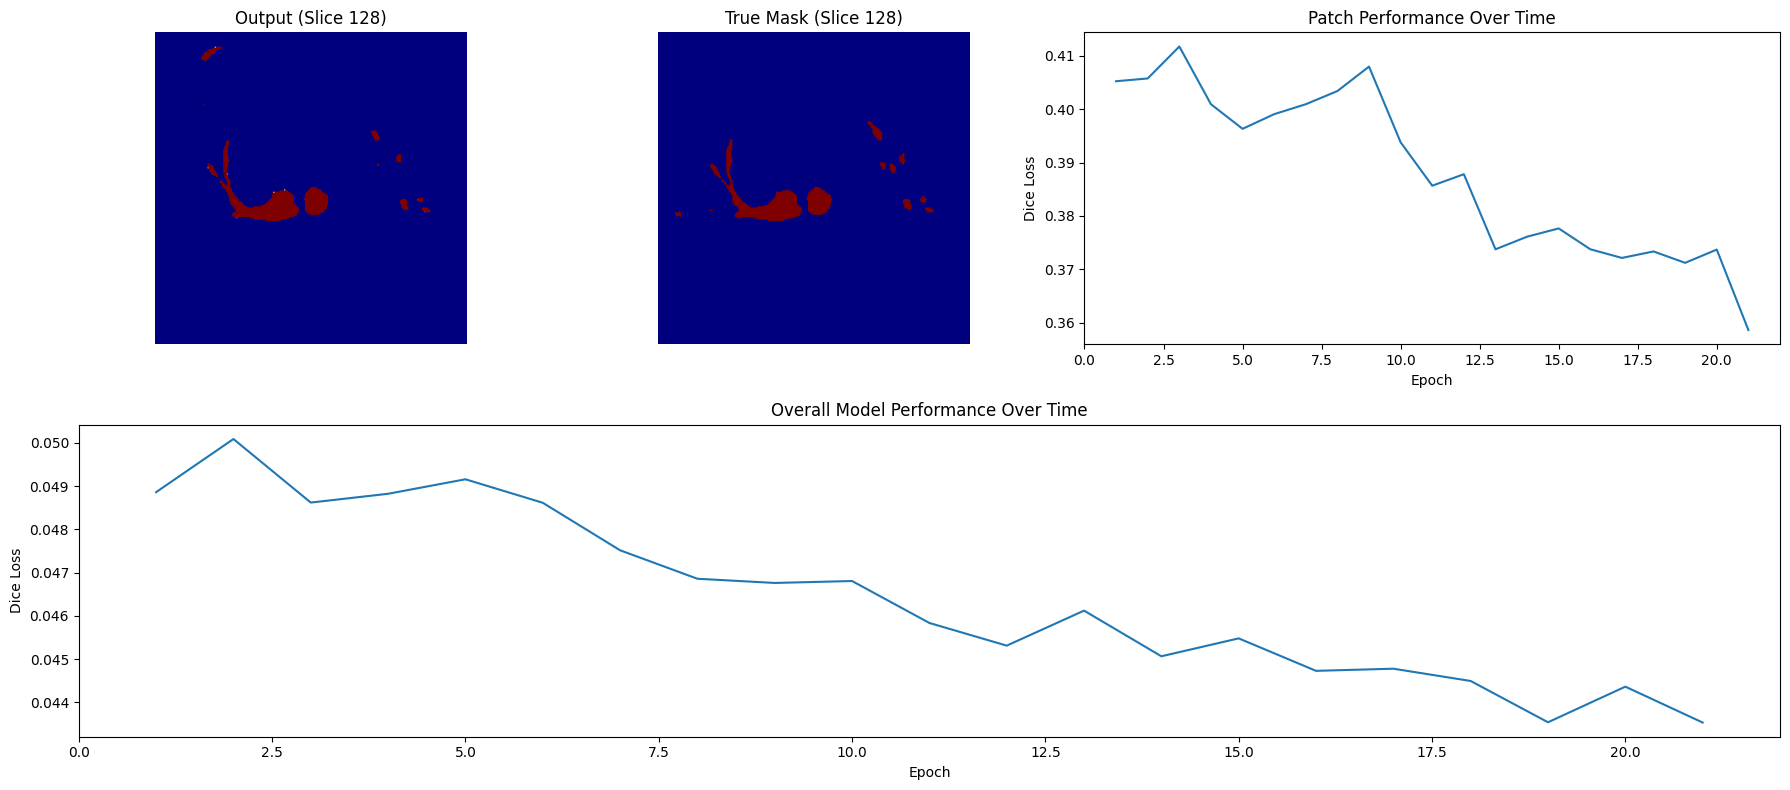

Checkpoint saved at epoch 21 to /content/drive/MyDrive/MyCheckpoints/model_epoch_21.pth


Epoch 31/1000: 100%|██████████| 100/100 [01:53<00:00,  1.13s/it]


Epoch [31/1000], Loss: 0.04259392082691193


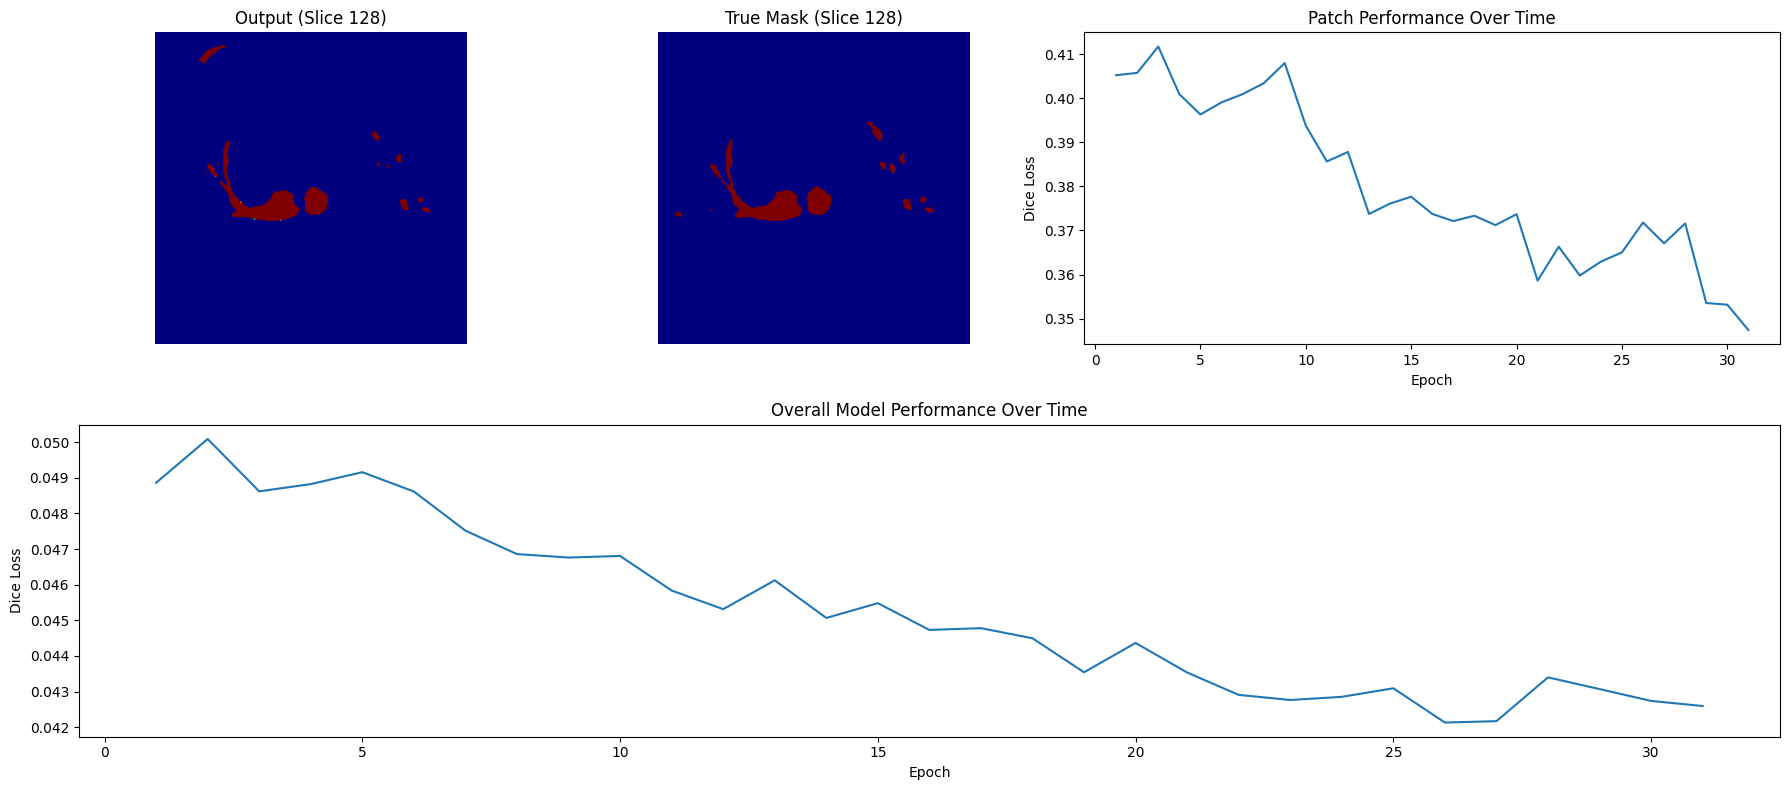

Checkpoint saved at epoch 31 to /content/drive/MyDrive/MyCheckpoints/model_epoch_31.pth


Epoch 41/1000: 100%|██████████| 100/100 [01:53<00:00,  1.13s/it]


Epoch [41/1000], Loss: 0.04005489826202393


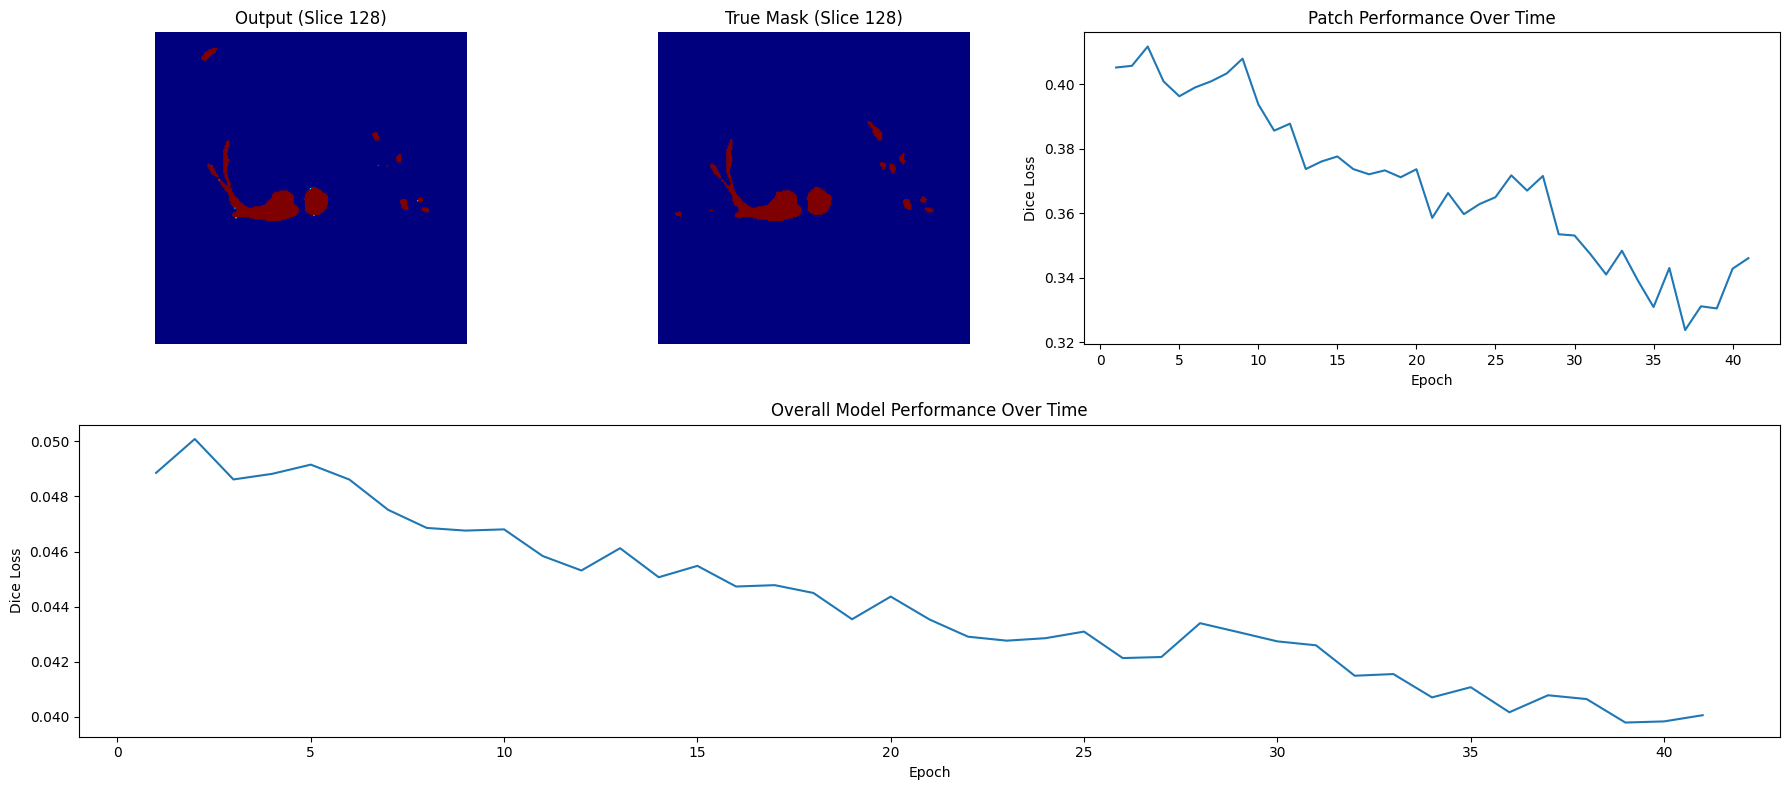

Checkpoint saved at epoch 41 to /content/drive/MyDrive/MyCheckpoints/model_epoch_41.pth


Epoch 51/1000: 100%|██████████| 100/100 [01:53<00:00,  1.13s/it]


Epoch [51/1000], Loss: 0.037619388103485106


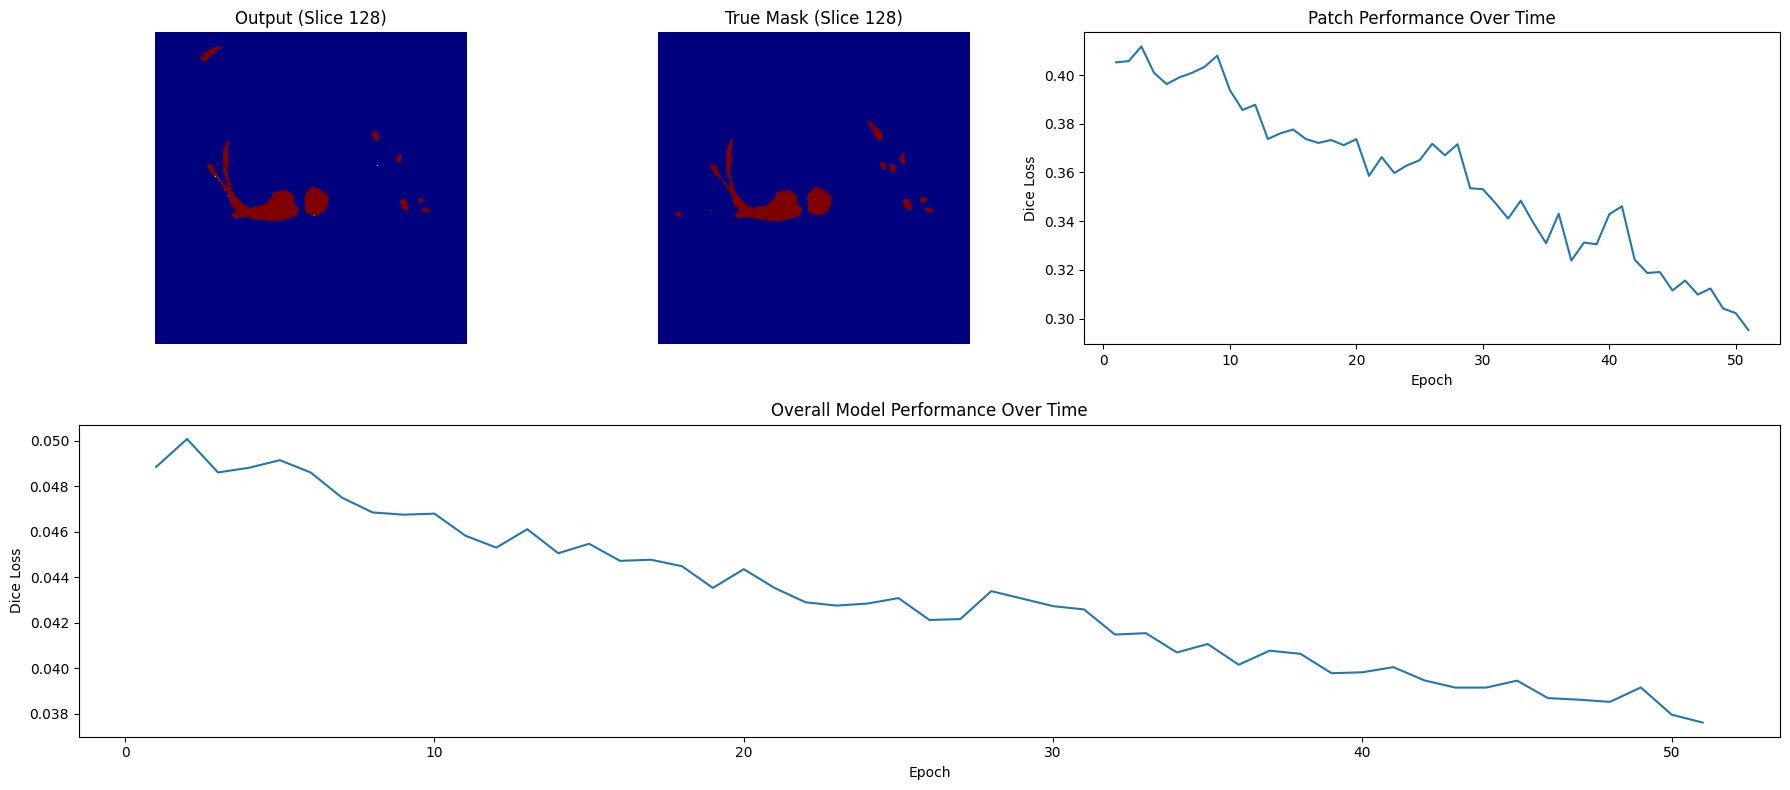

Checkpoint saved at epoch 51 to /content/drive/MyDrive/MyCheckpoints/model_epoch_51.pth


Epoch 61/1000: 100%|██████████| 100/100 [01:52<00:00,  1.13s/it]


Epoch [61/1000], Loss: 0.03730395078659057


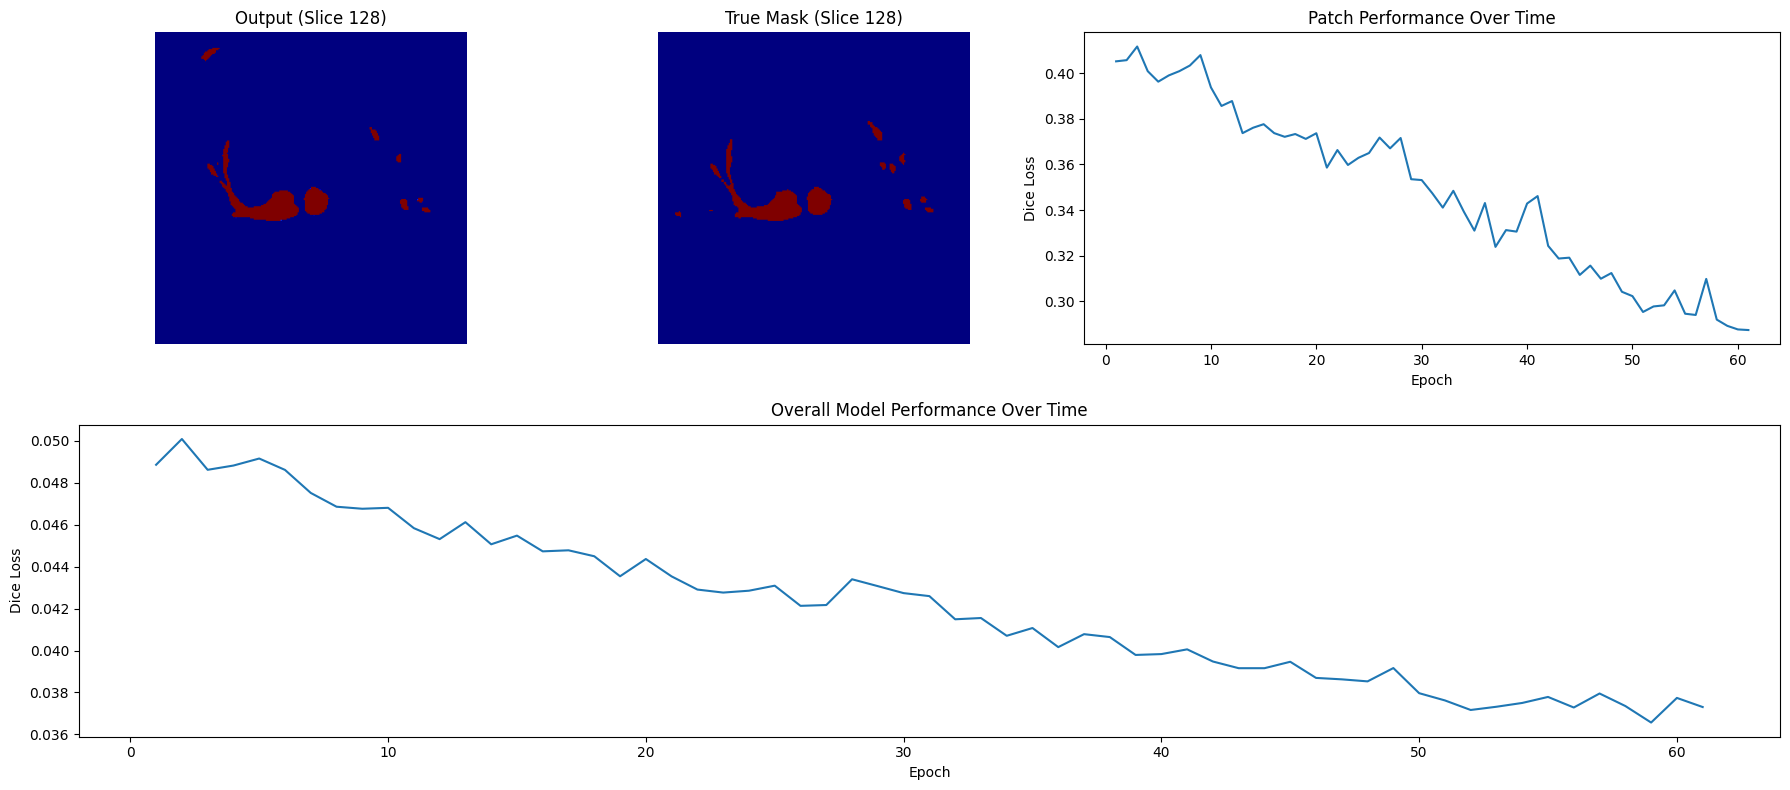

Checkpoint saved at epoch 61 to /content/drive/MyDrive/MyCheckpoints/model_epoch_61.pth


Epoch 71/1000: 100%|██████████| 100/100 [01:53<00:00,  1.13s/it]


Epoch [71/1000], Loss: 0.0352044016122818


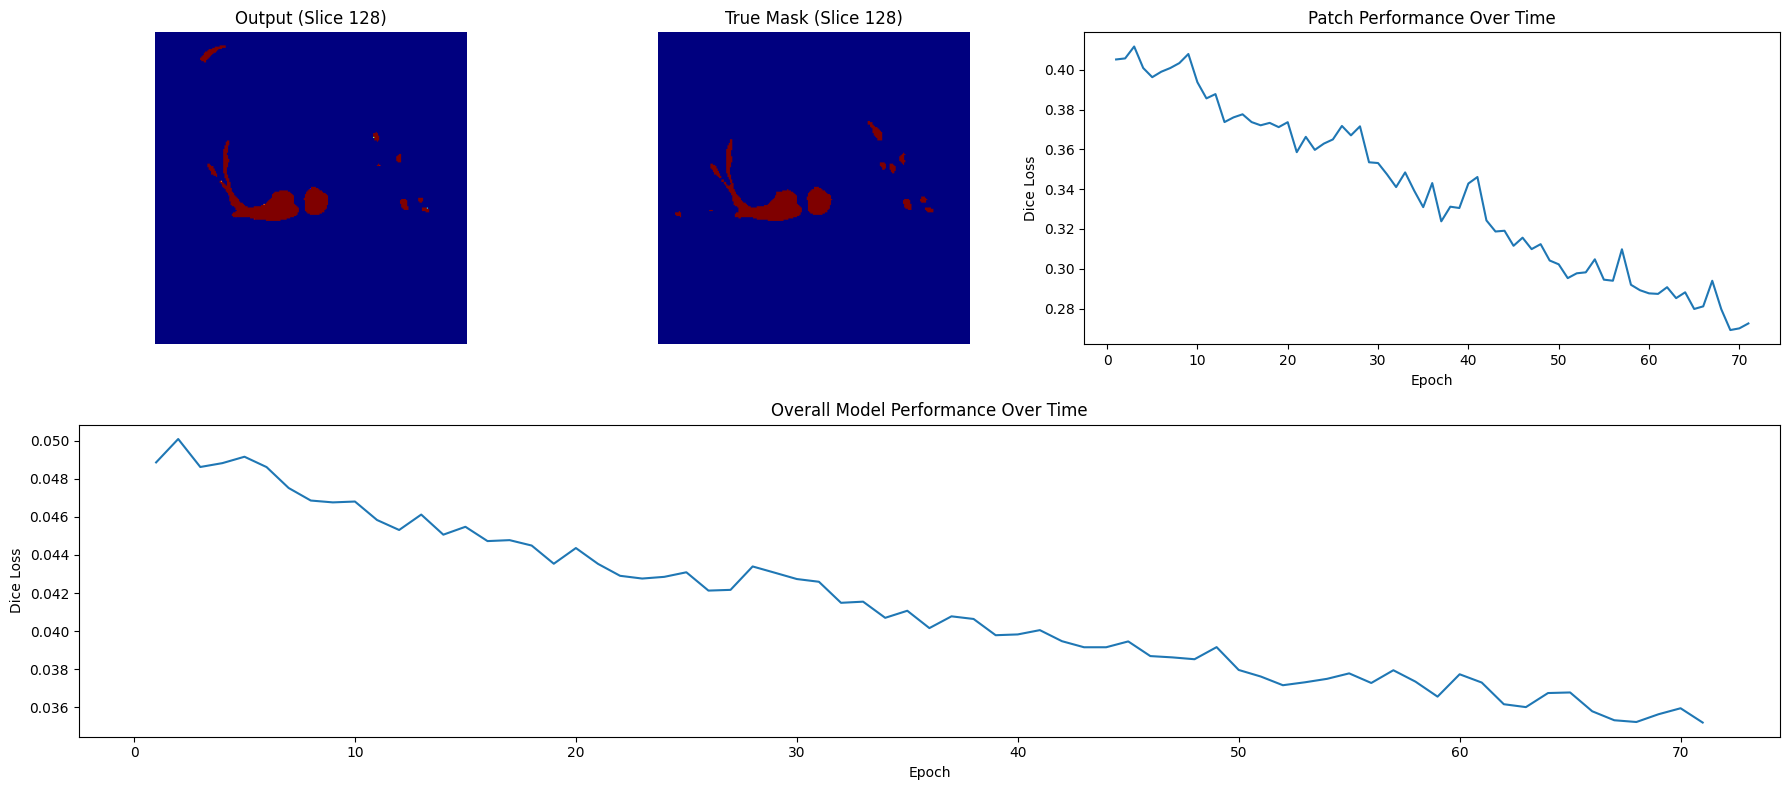

Checkpoint saved at epoch 71 to /content/drive/MyDrive/MyCheckpoints/model_epoch_71.pth


Epoch 81/1000: 100%|██████████| 100/100 [01:53<00:00,  1.13s/it]


Epoch [81/1000], Loss: 0.033740482330322265


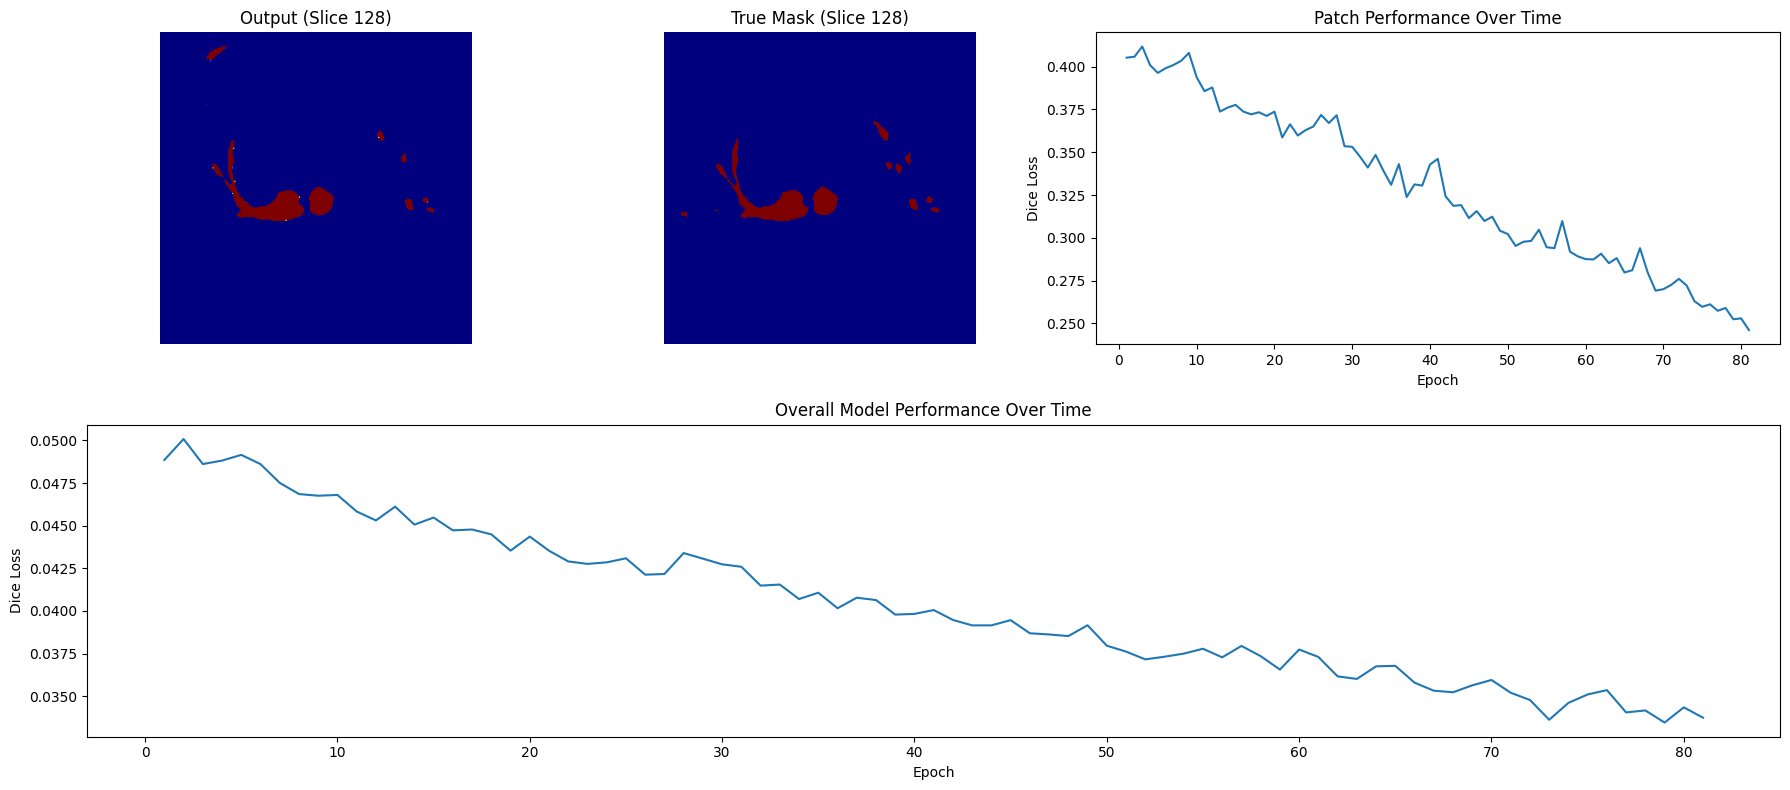

Checkpoint saved at epoch 81 to /content/drive/MyDrive/MyCheckpoints/model_epoch_81.pth


Epoch 91/1000: 100%|██████████| 100/100 [01:52<00:00,  1.13s/it]


Epoch [91/1000], Loss: 0.03283649027347565


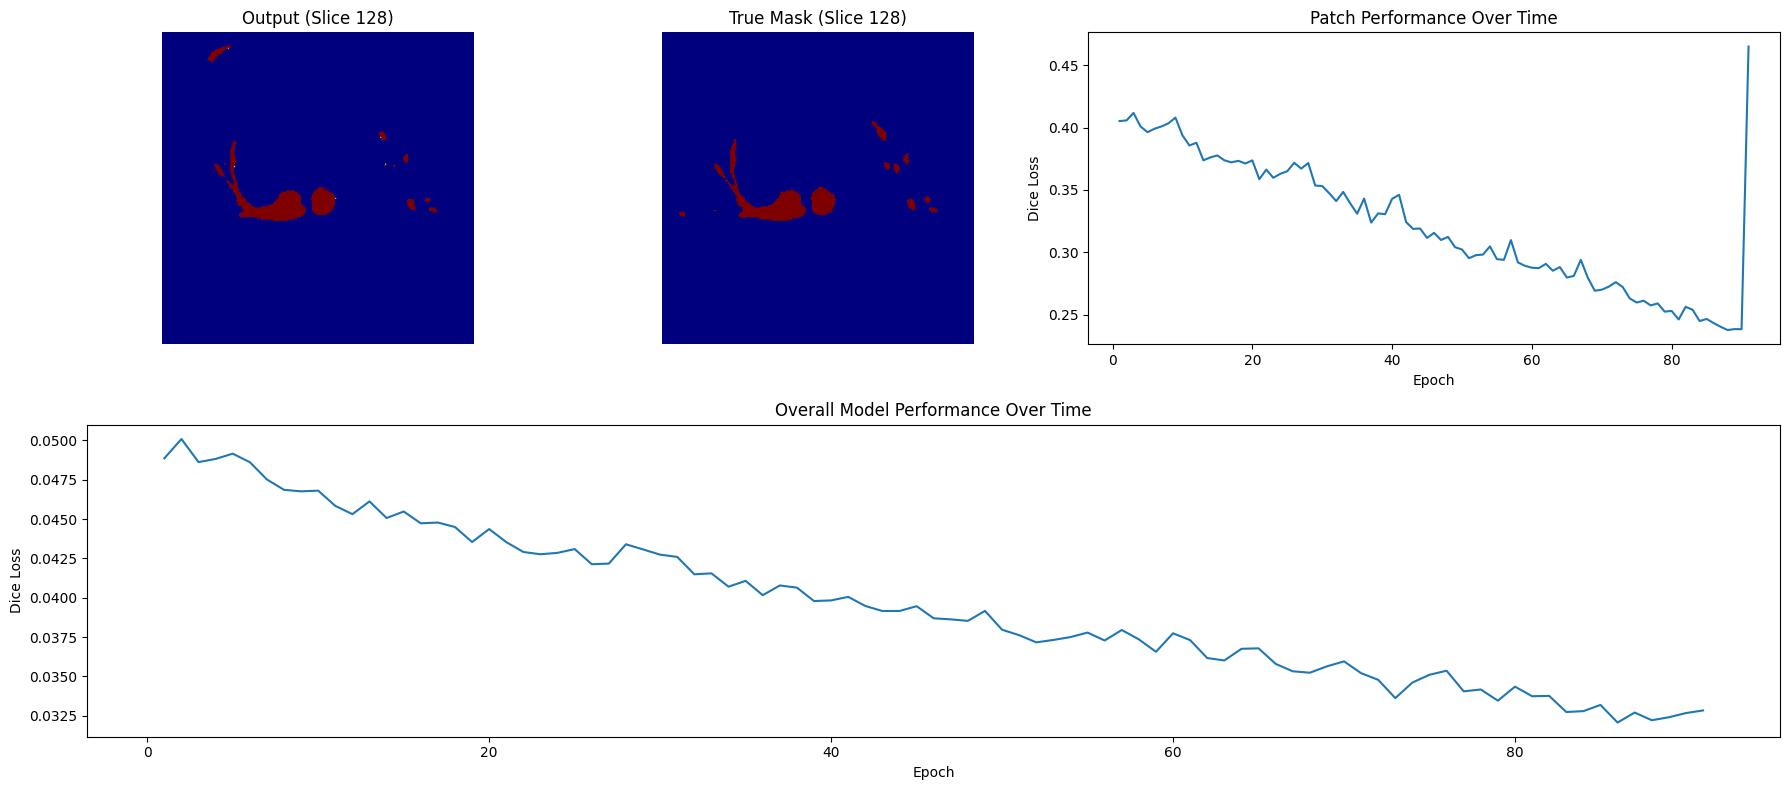

Checkpoint saved at epoch 91 to /content/drive/MyDrive/MyCheckpoints/model_epoch_91.pth


Epoch 101/1000: 100%|██████████| 100/100 [01:52<00:00,  1.13s/it]


Epoch [101/1000], Loss: 0.03218811571598053


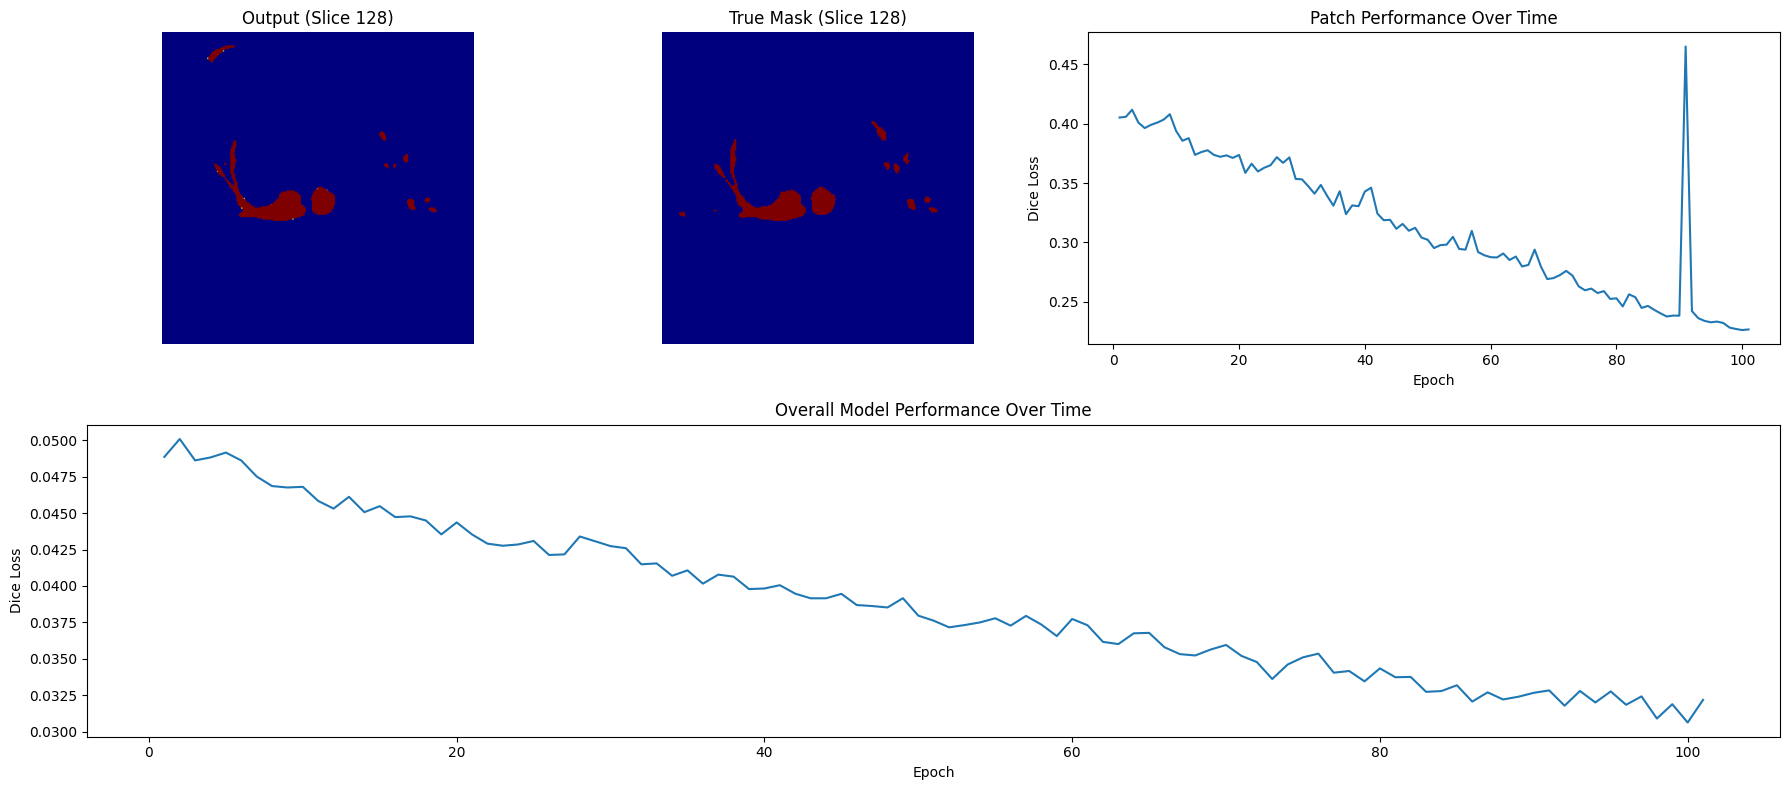

Checkpoint saved at epoch 101 to /content/drive/MyDrive/MyCheckpoints/model_epoch_101.pth


Epoch 111/1000: 100%|██████████| 100/100 [01:52<00:00,  1.13s/it]


Epoch [111/1000], Loss: 0.030326654314994813


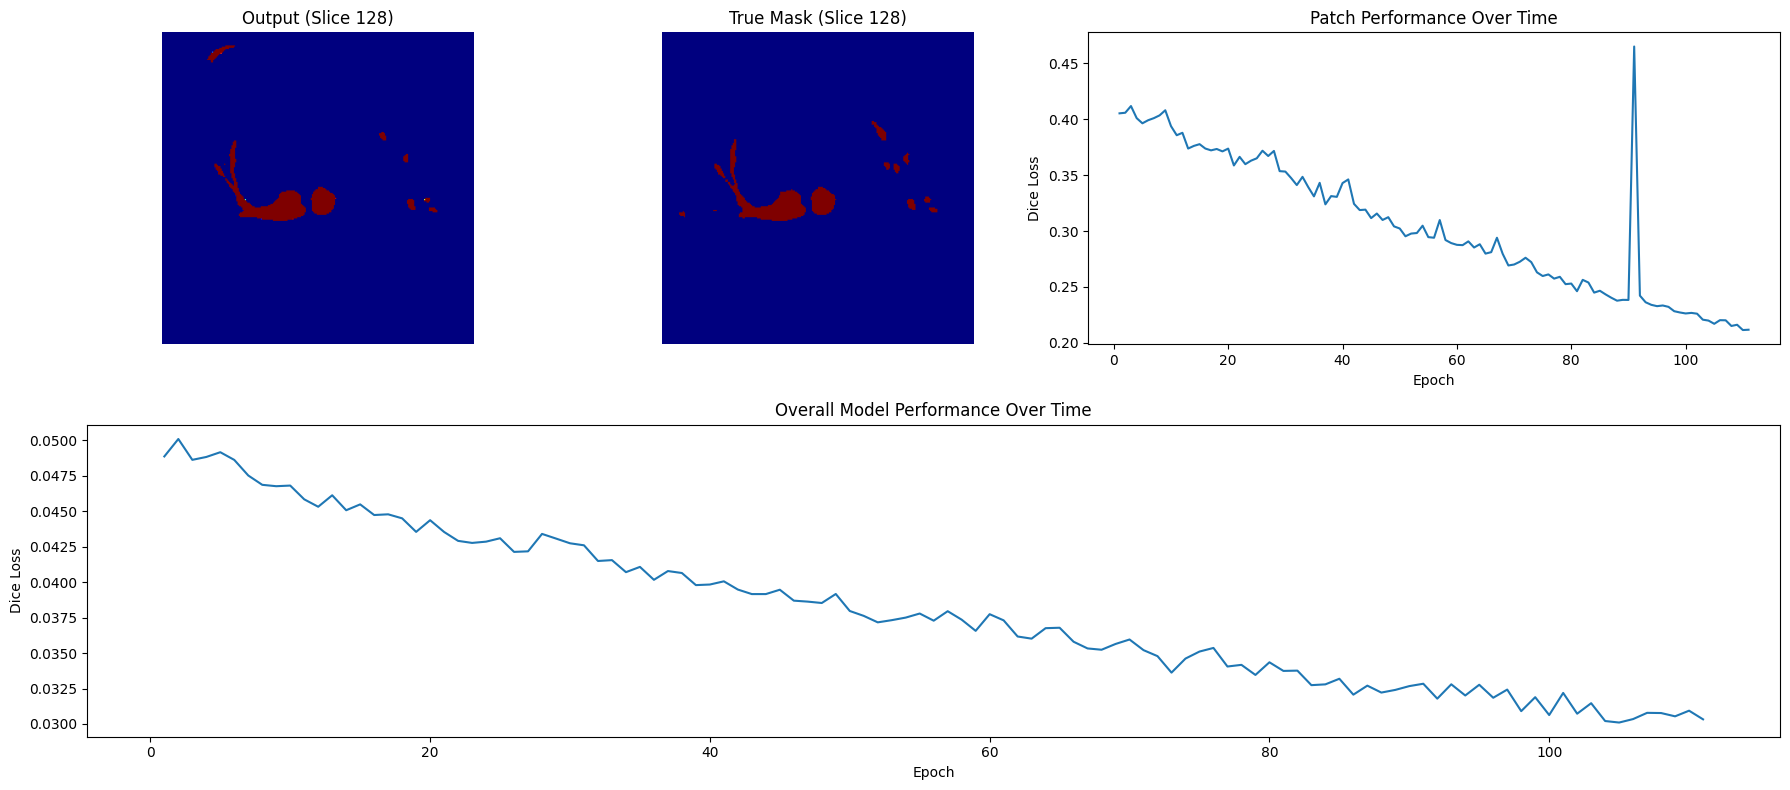

Checkpoint saved at epoch 111 to /content/drive/MyDrive/MyCheckpoints/model_epoch_111.pth


Epoch 121/1000: 100%|██████████| 100/100 [01:53<00:00,  1.13s/it]


Epoch [121/1000], Loss: 0.02874012231826782


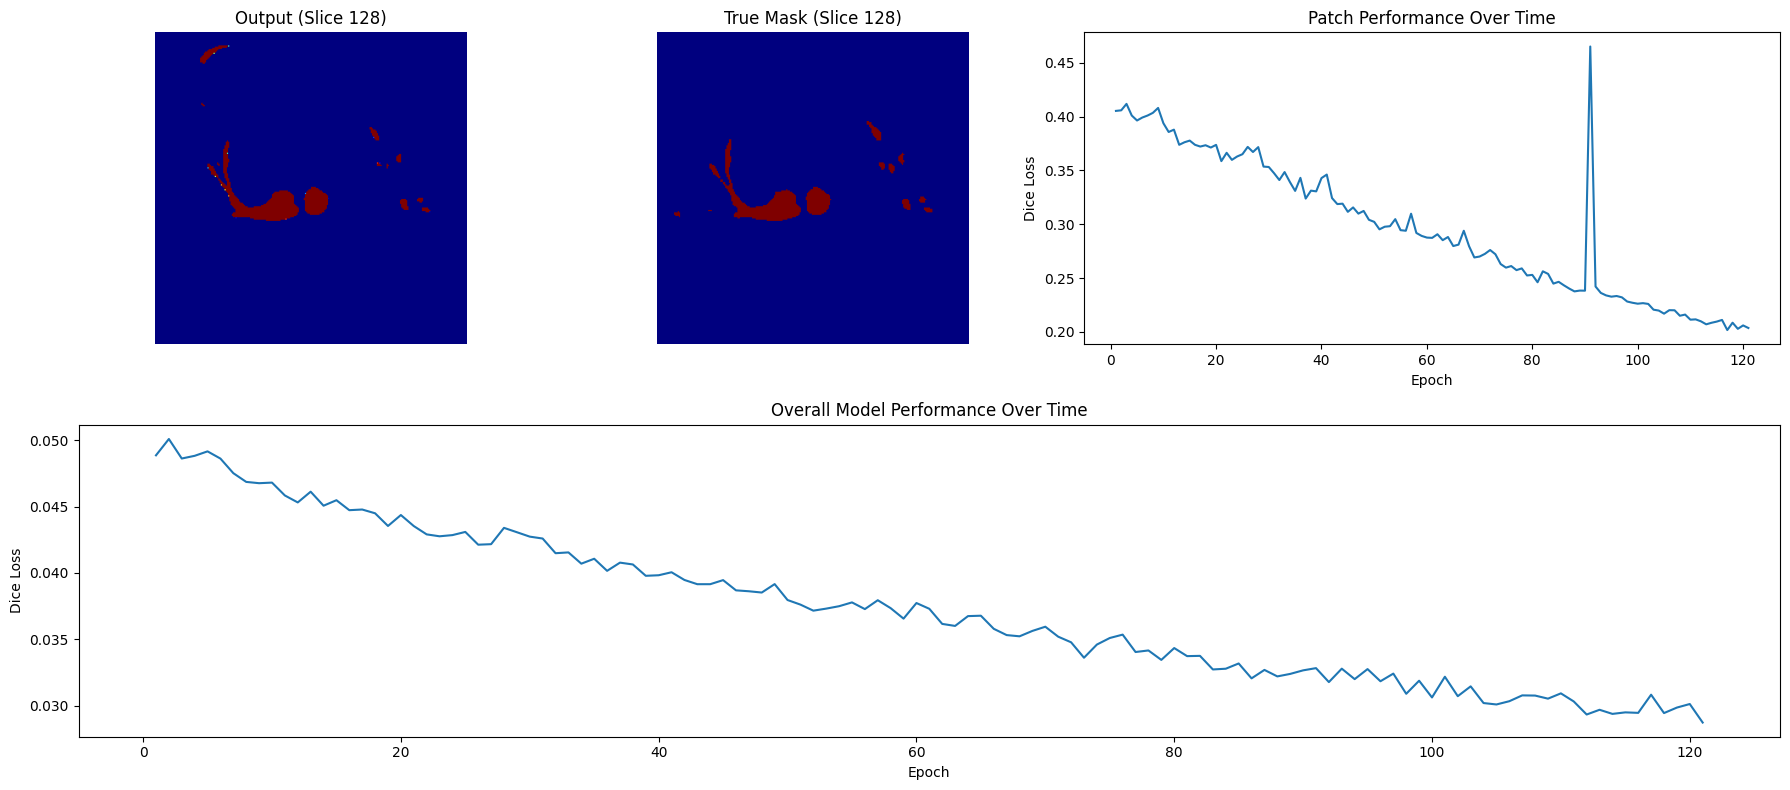

Checkpoint saved at epoch 121 to /content/drive/MyDrive/MyCheckpoints/model_epoch_121.pth


Epoch 131/1000: 100%|██████████| 100/100 [01:53<00:00,  1.13s/it]


Epoch [131/1000], Loss: 0.02777184545993805


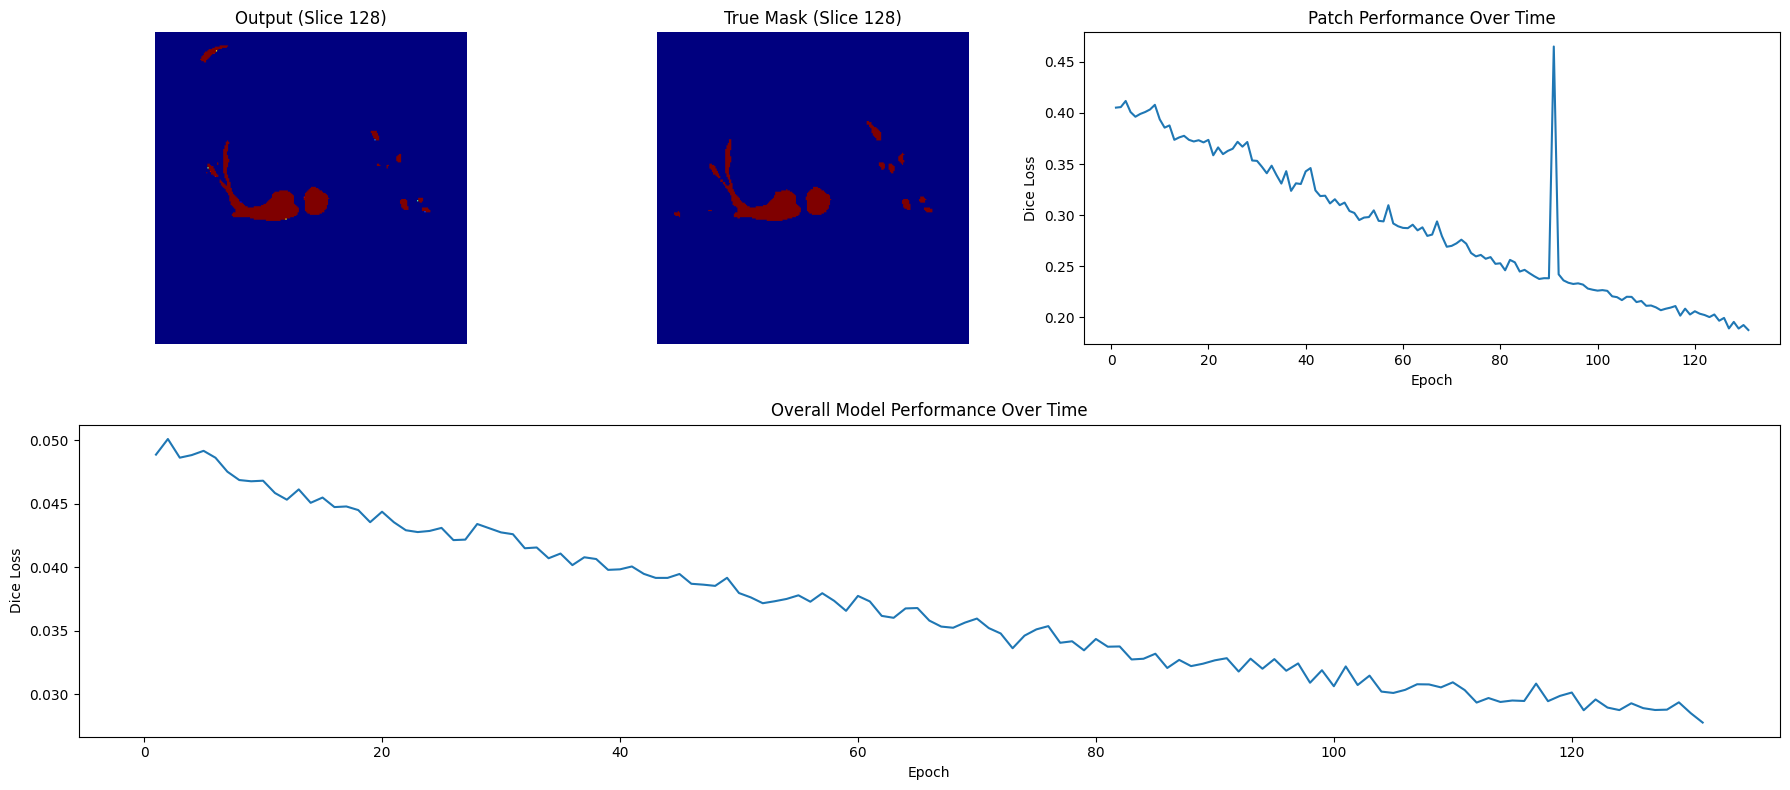

Checkpoint saved at epoch 131 to /content/drive/MyDrive/MyCheckpoints/model_epoch_131.pth


Epoch 141/1000: 100%|██████████| 100/100 [01:52<00:00,  1.13s/it]


Epoch [141/1000], Loss: 0.02698473334312439


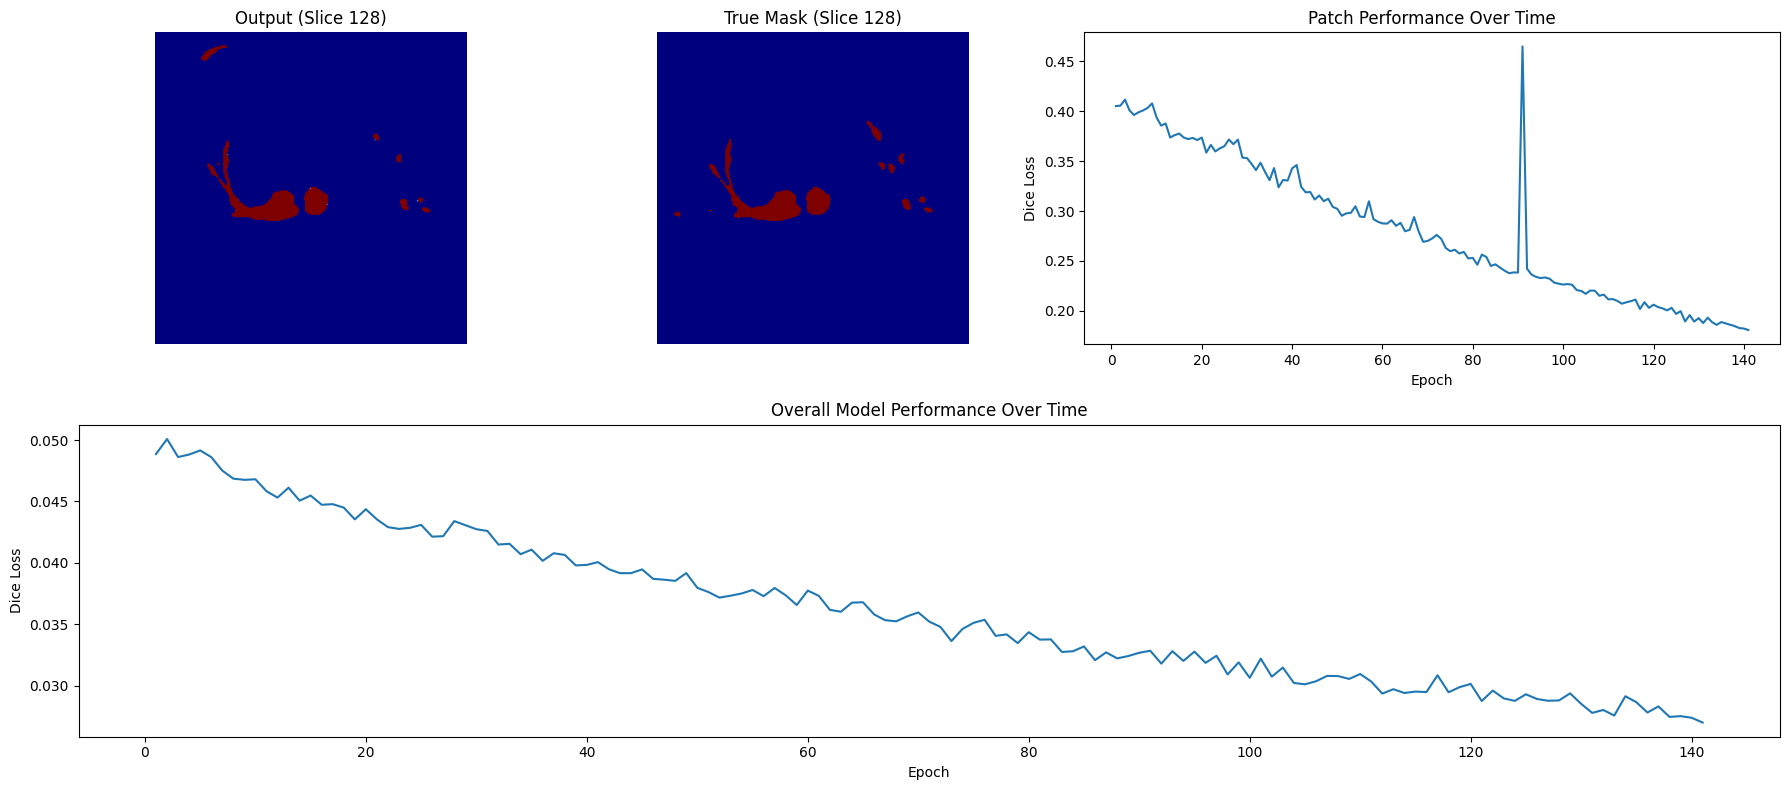

Checkpoint saved at epoch 141 to /content/drive/MyDrive/MyCheckpoints/model_epoch_141.pth


Epoch 151/1000: 100%|██████████| 100/100 [01:52<00:00,  1.13s/it]


Epoch [151/1000], Loss: 0.02676213800907135


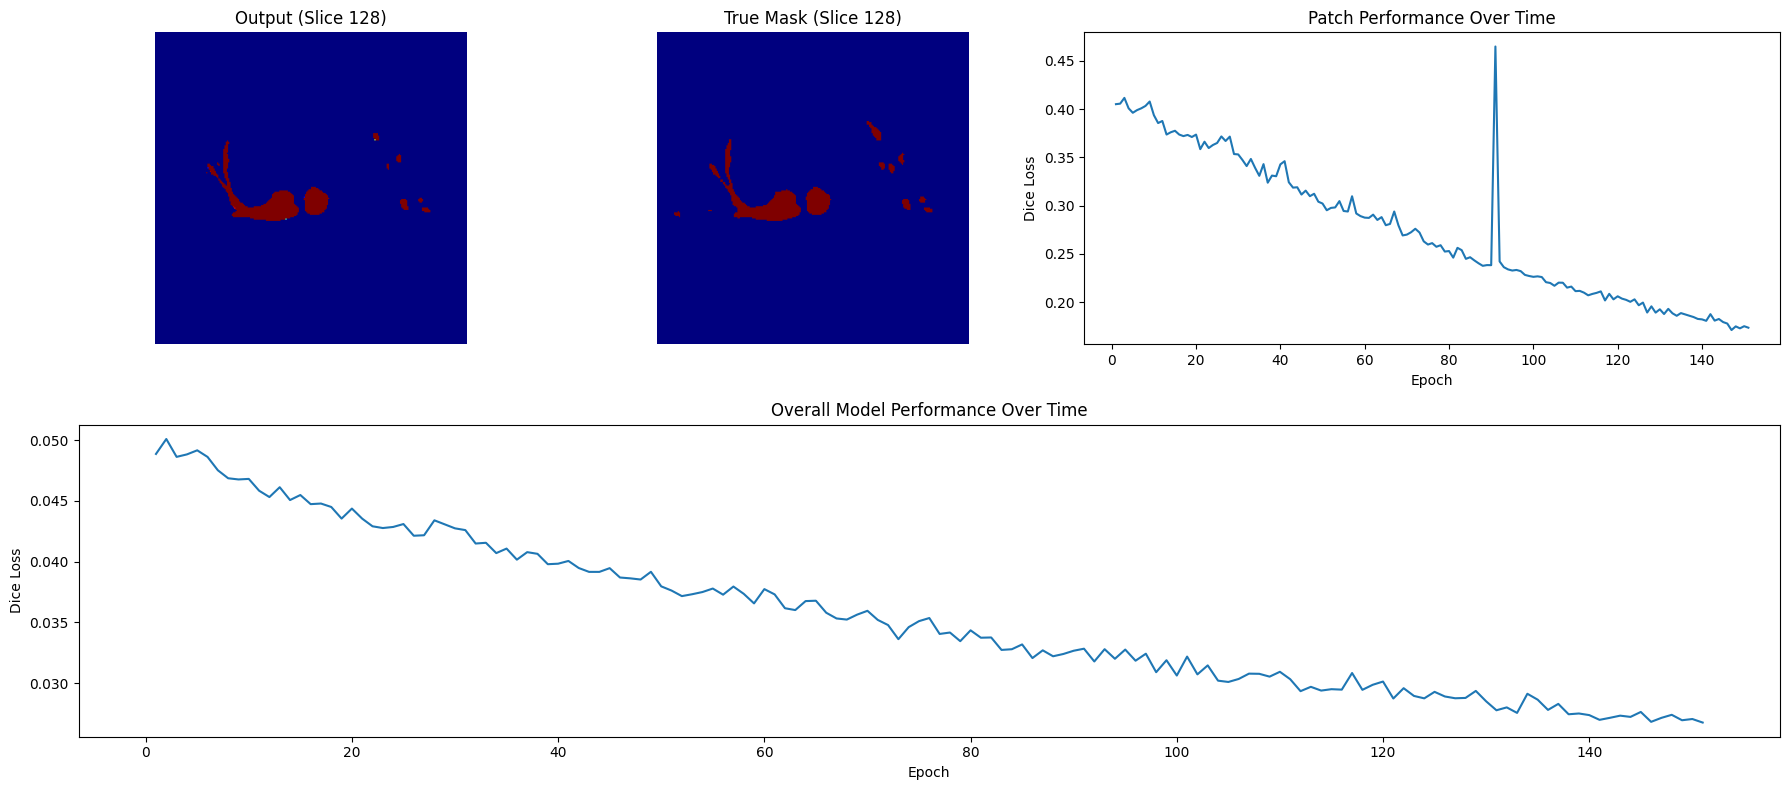

Checkpoint saved at epoch 151 to /content/drive/MyDrive/MyCheckpoints/model_epoch_151.pth


Epoch 161/1000: 100%|██████████| 100/100 [01:53<00:00,  1.13s/it]


Epoch [161/1000], Loss: 0.025868287682533263


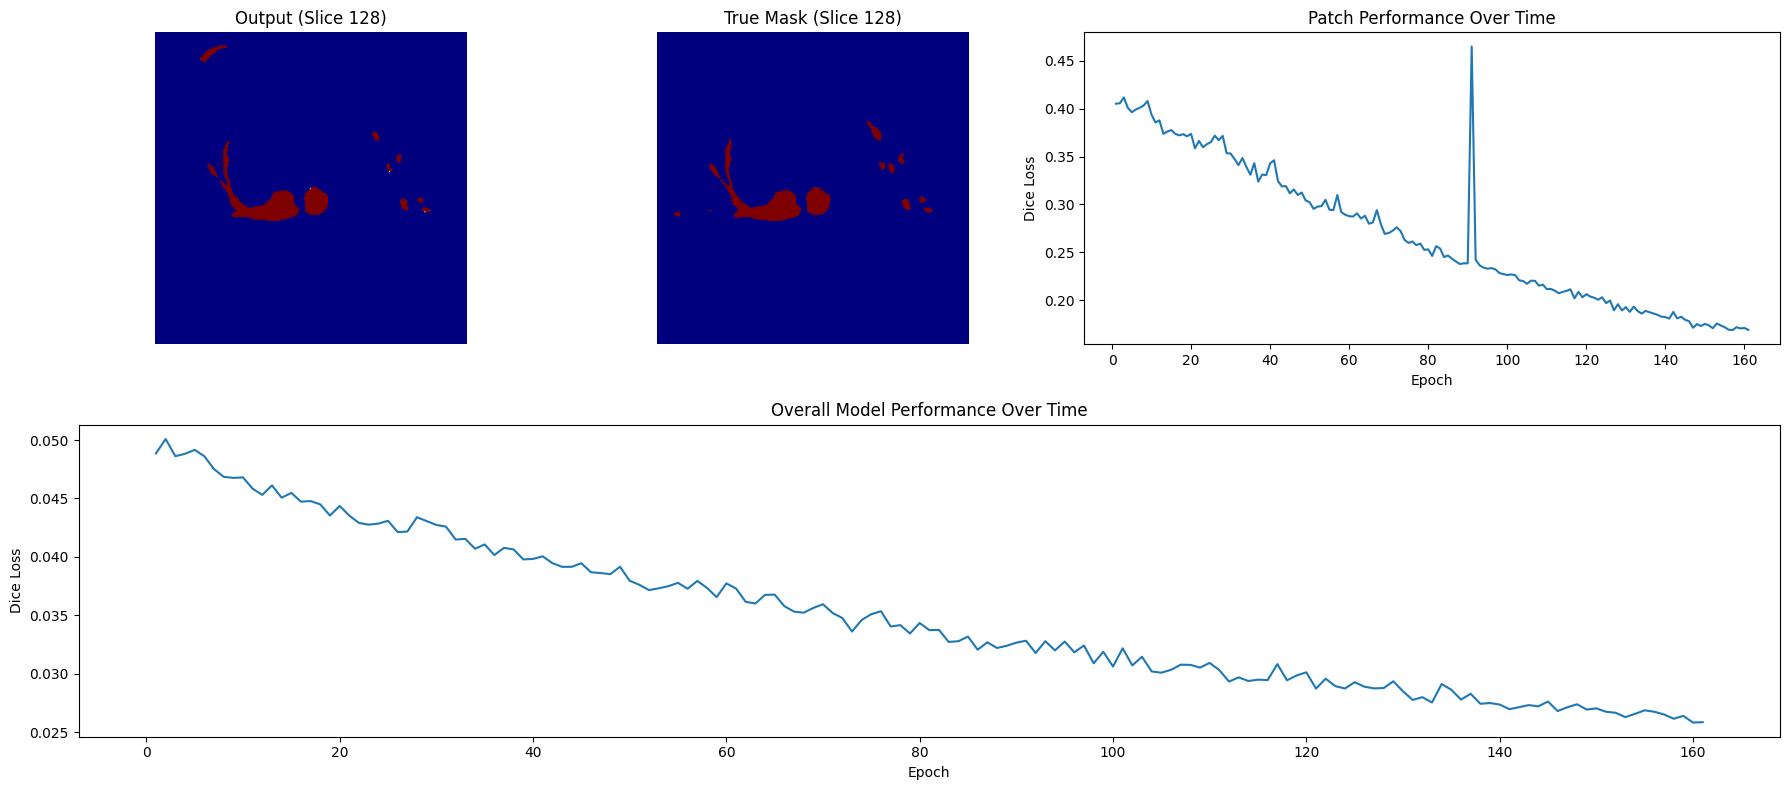

Checkpoint saved at epoch 161 to /content/drive/MyDrive/MyCheckpoints/model_epoch_161.pth


Epoch 171/1000: 100%|██████████| 100/100 [01:52<00:00,  1.13s/it]


Epoch [171/1000], Loss: 0.02616365373134613


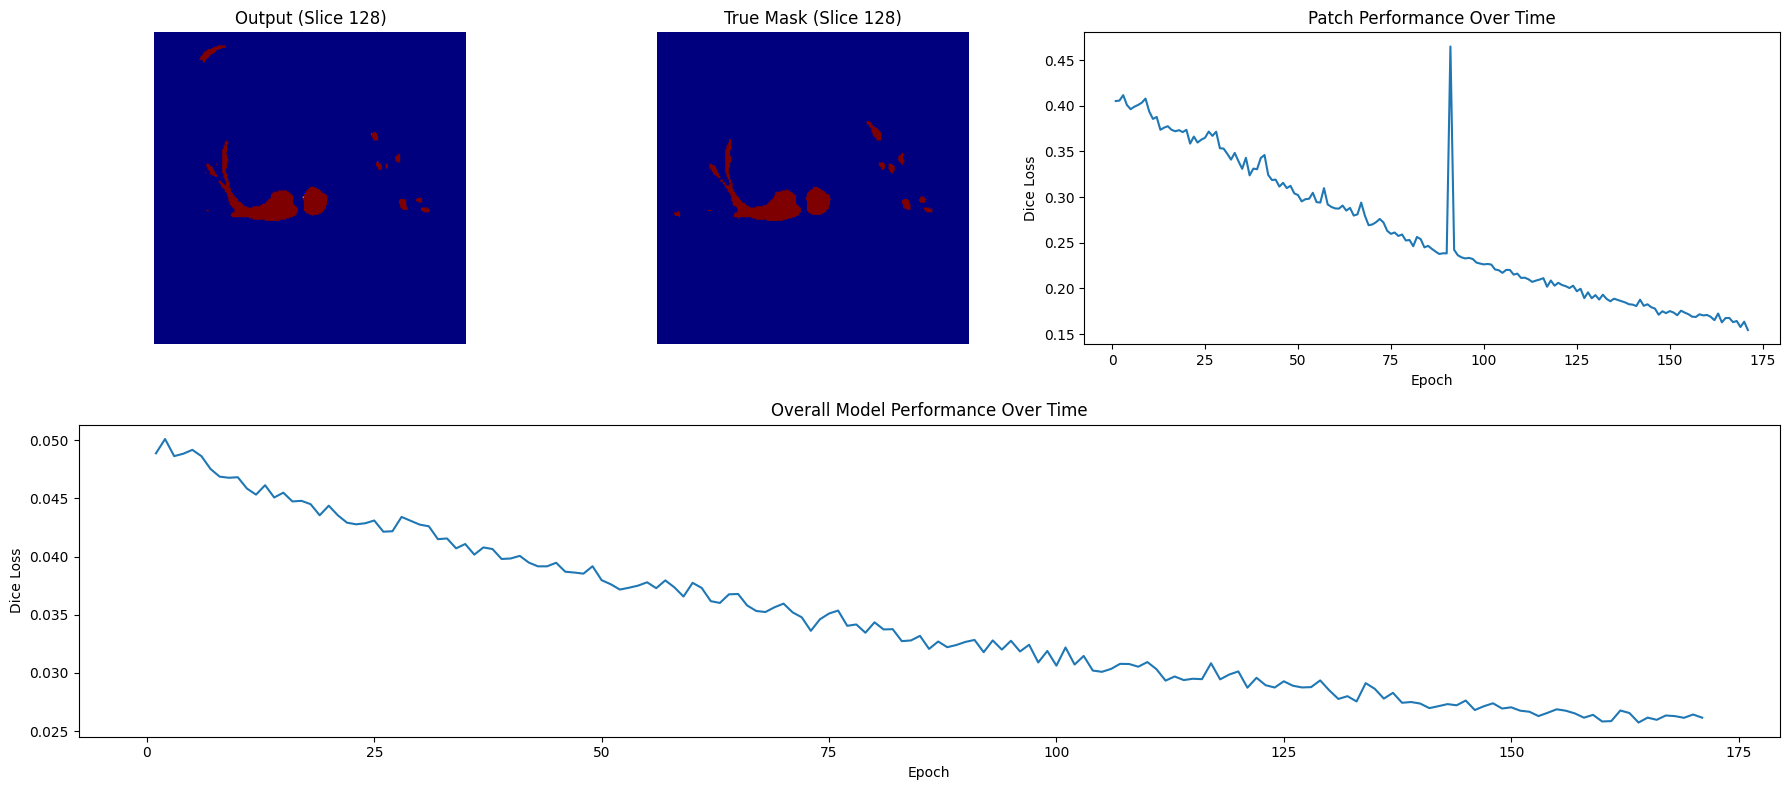

Checkpoint saved at epoch 171 to /content/drive/MyDrive/MyCheckpoints/model_epoch_171.pth


Epoch 181/1000: 100%|██████████| 100/100 [01:52<00:00,  1.13s/it]


Epoch [181/1000], Loss: 0.025272240042686463


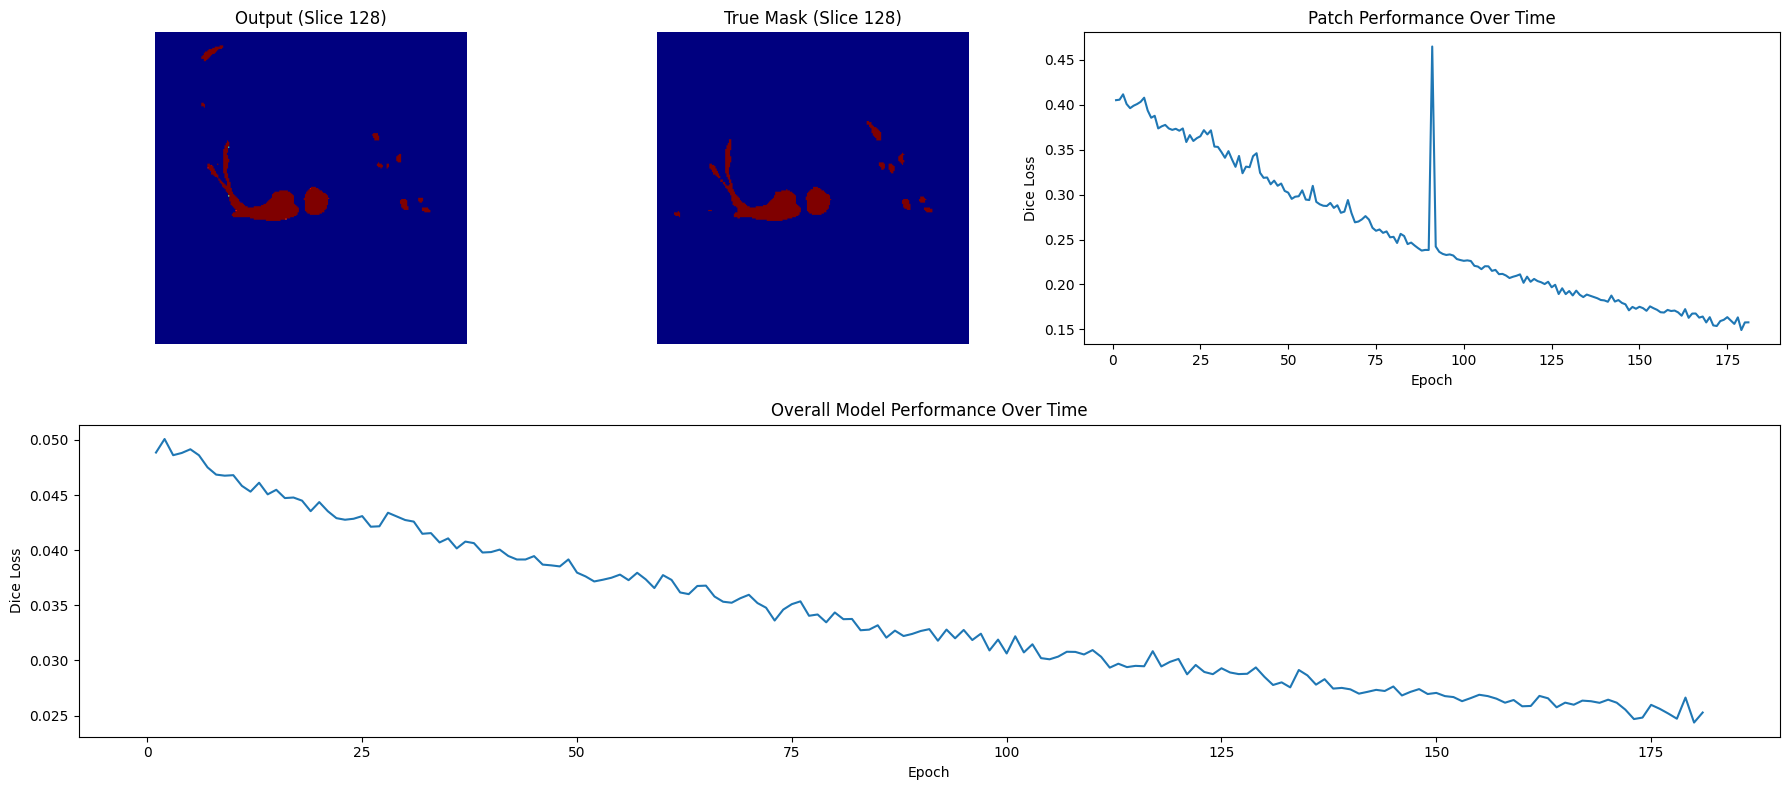

Checkpoint saved at epoch 181 to /content/drive/MyDrive/MyCheckpoints/model_epoch_181.pth


Epoch 184/1000:  28%|██▊       | 28/100 [00:32<01:22,  1.14s/it]


KeyboardInterrupt: 

In [ ]:
model_GPU = UNet3D(in_channels=1).to(device)
optimizer = optim.Adam(model_GPU.parameters(), lr=1e-4)
criterion = dice_loss
patch_loader = GPUPatchLoader(data_folders[:20], patches_per_vol=5, patch_size=256)
num_epochs = 1000
slice_index = 128

example_patch = None

train_losses = []
dice_scores = []
patch_losses = []

loss_file_path = "loss_values.txt"
checkpoint_dir = '/content/drive/MyDrive/MyCheckpoints'
checkpoint_path = '/content/drive/MyDrive/MyCheckpoints/model_epoch_101.pth'
checkpoint = torch.load(checkpoint_path)
model_GPU.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
start_epoch = checkpoint['epoch']

# hack to run model after traing was randomly stopped
start_epoch = 0

if 'patch_losses' in checkpoint:
    patch_losses = checkpoint['patch_losses']

os.makedirs(checkpoint_dir, exist_ok=True)

for epoch in range(start_epoch, num_epochs):
    model_GPU.train()
    epoch_loss = 0

    for i in tqdm(range(len(patch_loader)), desc=f"Epoch {epoch + 1}/{num_epochs}"):
        input_patch, mask_patch = patch_loader[i]
        input_patch = input_patch.unsqueeze(0).to(device)
        mask_patch = mask_patch.unsqueeze(0).to(device)

        optimizer.zero_grad()
        output = model_GPU(input_patch)
        loss = criterion(output, mask_patch)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_epoch_loss = epoch_loss / len(patch_loader)
    train_losses.append(epoch_loss / len(patch_loader))

    model_GPU.eval()
    with torch.no_grad():
        if example_patch is None:
            example_patch, example_mask = patch_loader[101]
            example_patch = example_patch.unsqueeze(0).to(device)
            example_mask = example_mask.unsqueeze(0).to(device)

        output = model_GPU(example_patch)
        patch_loss = criterion(output, example_mask).item()
        patch_losses.append(patch_loss)

    if (epoch) % 10 == 0:
        with open(loss_file_path, 'a') as file:
            file.write(f"Epoch {epoch + 1}/{num_epochs}, Loss: {avg_epoch_loss}\n")
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_epoch_loss}')

    if (epoch) % 10 == 0:
        o, m = output.detach().cpu().numpy(), example_mask.detach().cpu().numpy()
        fig, axes = plt.subplots(2, 3, figsize=(18, 8), gridspec_kw={'width_ratios': [1, 1, 1.5], 'height_ratios': [1, 1]})  # Changed to 2 rows, 3 columns
        axes[0, 0].imshow(o[0, 0, slice_index], cmap='jet')
        axes[0, 0].set_title(f"Output (Slice {slice_index})")
        axes[0, 0].axis('off')

        axes[0, 1].imshow(m[0, 0, slice_index], cmap='jet')
        axes[0, 1].set_title(f"True Mask (Slice {slice_index})")
        axes[0, 1].axis('off')

        axes[0, 2].plot(range(1, epoch + 2), patch_losses[:epoch+1])
        axes[0, 2].set_title("Patch Performance Over Time")
        axes[0, 2].set_xlabel("Epoch")
        axes[0, 2].set_ylabel("Dice Loss")

        gs = axes[1, 0].get_gridspec()
        for ax in axes[1, :]:
            ax.remove()

        axbig = fig.add_subplot(gs[1, :])
        axbig.plot(range(1, epoch + 2), train_losses)
        axbig.set_title("Overall Model Performance Over Time")
        axbig.set_xlabel("Epoch")
        axbig.set_ylabel("Dice Loss")

        plt.tight_layout()
        plt.show()
        plt.close(fig)

        checkpoint_path = os.path.join(checkpoint_dir, f'model_epoch_{epoch + 1}.pth')
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model_GPU.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'patch_losses': patch_losses
        }, checkpoint_path)
        print(f'Checkpoint saved at epoch {epoch + 1} to {checkpoint_path}')

# TESTING

Testing:   0%|          | 0/30 [00:00<?, ?it/s]

<Figure size 640x480 with 0 Axes>

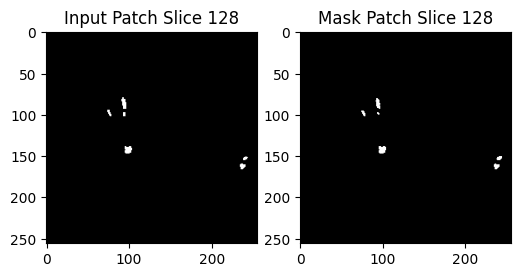

Testing:   3%|▎         | 1/30 [00:01<00:33,  1.16s/it]

<Figure size 640x480 with 0 Axes>

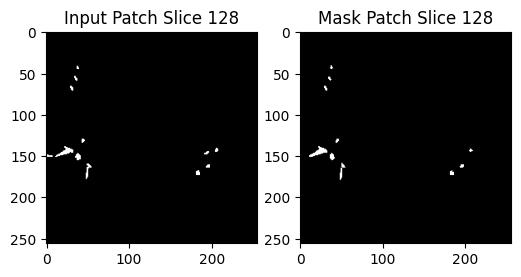

Testing:   7%|▋         | 2/30 [00:02<00:31,  1.13s/it]

<Figure size 640x480 with 0 Axes>

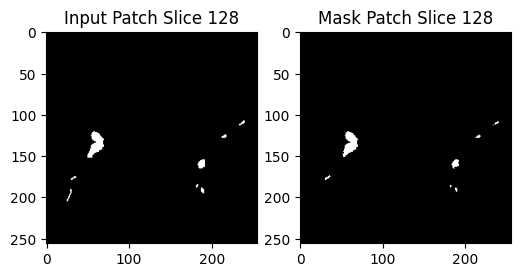

Testing:  10%|█         | 3/30 [00:03<00:30,  1.12s/it]

<Figure size 640x480 with 0 Axes>

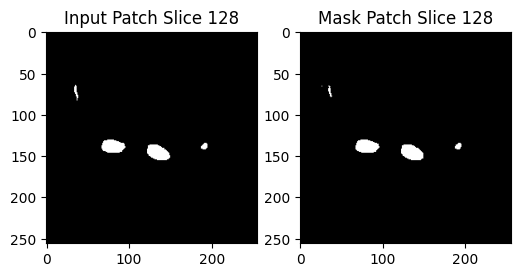

Testing:  13%|█▎        | 4/30 [00:04<00:29,  1.12s/it]

<Figure size 640x480 with 0 Axes>

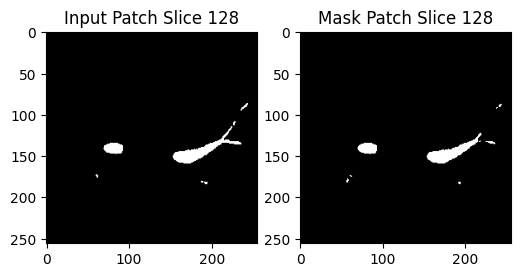

Testing:  17%|█▋        | 5/30 [00:05<00:27,  1.12s/it]

<Figure size 640x480 with 0 Axes>

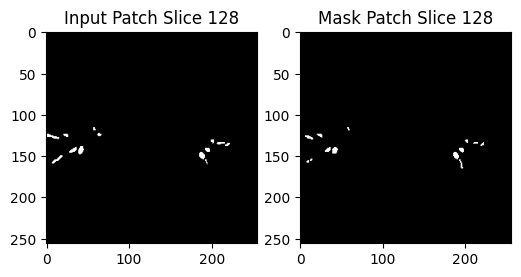

Testing:  20%|██        | 6/30 [00:06<00:26,  1.12s/it]

<Figure size 640x480 with 0 Axes>

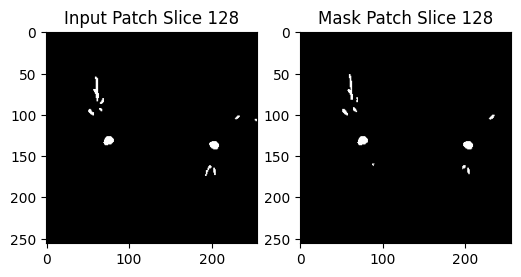

Testing:  23%|██▎       | 7/30 [00:07<00:25,  1.12s/it]

<Figure size 640x480 with 0 Axes>

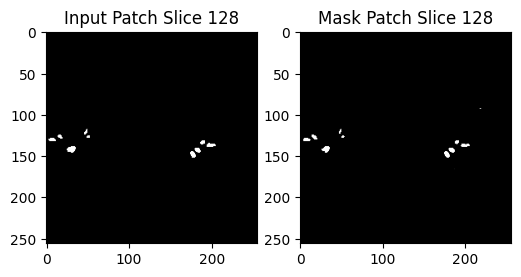

Testing:  27%|██▋       | 8/30 [00:08<00:24,  1.11s/it]

<Figure size 640x480 with 0 Axes>

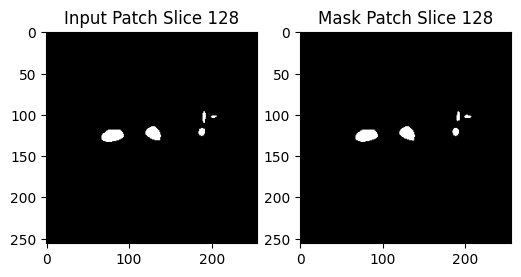

Testing:  30%|███       | 9/30 [00:10<00:23,  1.13s/it]

<Figure size 640x480 with 0 Axes>

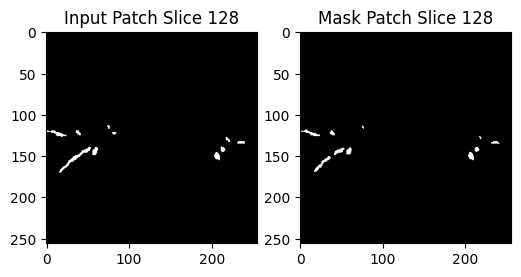

Testing:  33%|███▎      | 10/30 [00:11<00:22,  1.14s/it]

<Figure size 640x480 with 0 Axes>

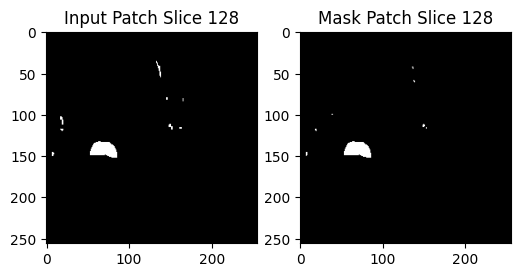

Testing:  37%|███▋      | 11/30 [00:12<00:21,  1.14s/it]

<Figure size 640x480 with 0 Axes>

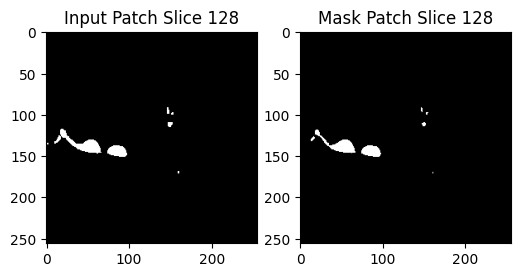

Testing:  40%|████      | 12/30 [00:13<00:20,  1.13s/it]

<Figure size 640x480 with 0 Axes>

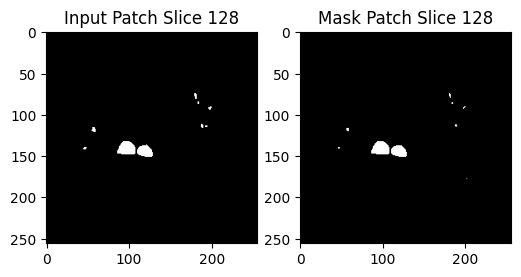

Testing:  43%|████▎     | 13/30 [00:14<00:19,  1.13s/it]

<Figure size 640x480 with 0 Axes>

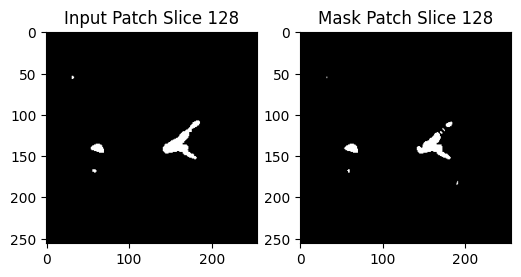

Testing:  47%|████▋     | 14/30 [00:15<00:18,  1.13s/it]

<Figure size 640x480 with 0 Axes>

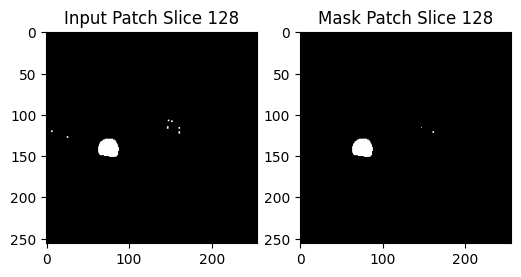

Testing:  50%|█████     | 15/30 [00:16<00:16,  1.13s/it]

<Figure size 640x480 with 0 Axes>

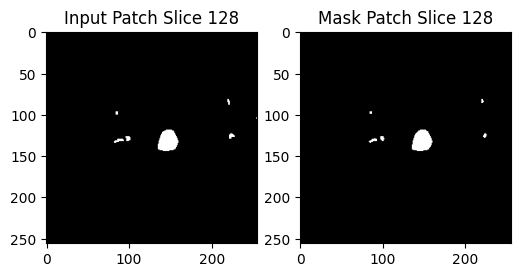

Testing:  53%|█████▎    | 16/30 [00:17<00:15,  1.12s/it]

<Figure size 640x480 with 0 Axes>

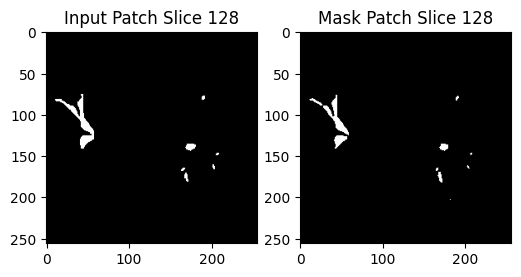

Testing:  57%|█████▋    | 17/30 [00:19<00:15,  1.22s/it]

<Figure size 640x480 with 0 Axes>

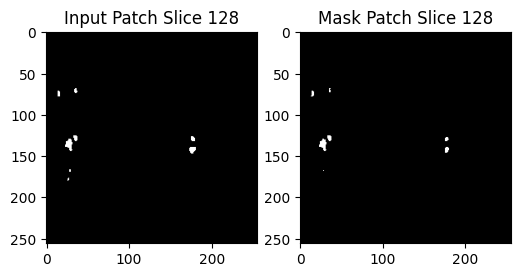

Testing:  60%|██████    | 18/30 [00:20<00:14,  1.18s/it]

<Figure size 640x480 with 0 Axes>

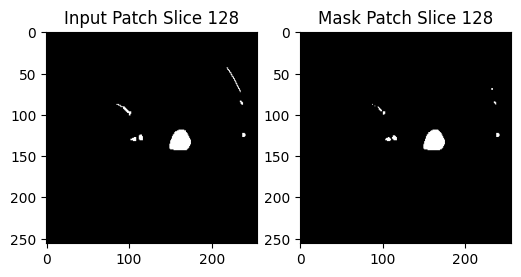

Testing:  63%|██████▎   | 19/30 [00:21<00:12,  1.16s/it]

<Figure size 640x480 with 0 Axes>

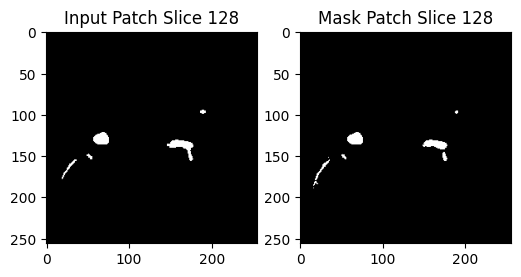

Testing:  67%|██████▋   | 20/30 [00:22<00:11,  1.16s/it]

<Figure size 640x480 with 0 Axes>

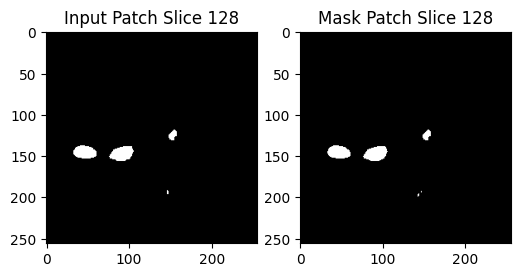

Testing:  70%|███████   | 21/30 [00:24<00:11,  1.23s/it]

<Figure size 640x480 with 0 Axes>

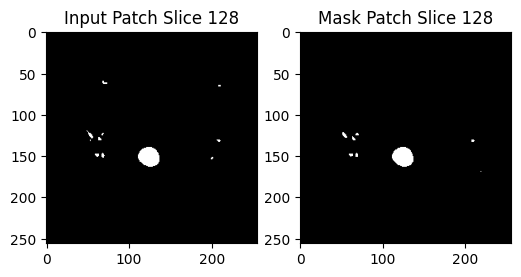

Testing:  73%|███████▎  | 22/30 [00:25<00:10,  1.26s/it]

<Figure size 640x480 with 0 Axes>

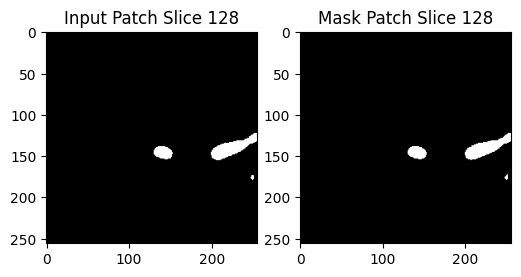

Testing:  77%|███████▋  | 23/30 [00:26<00:09,  1.29s/it]

<Figure size 640x480 with 0 Axes>

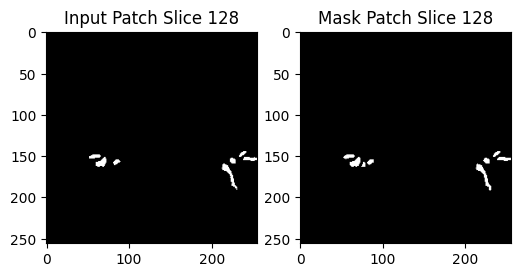

Testing:  80%|████████  | 24/30 [00:28<00:07,  1.31s/it]

<Figure size 640x480 with 0 Axes>

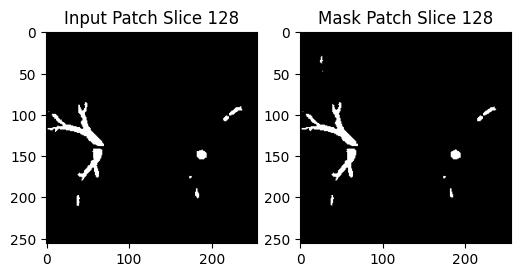

Testing:  83%|████████▎ | 25/30 [00:29<00:06,  1.32s/it]

<Figure size 640x480 with 0 Axes>

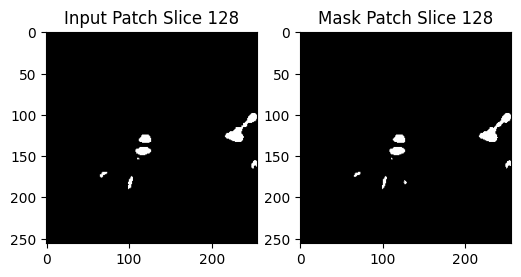

Testing:  87%|████████▋ | 26/30 [00:31<00:05,  1.36s/it]

<Figure size 640x480 with 0 Axes>

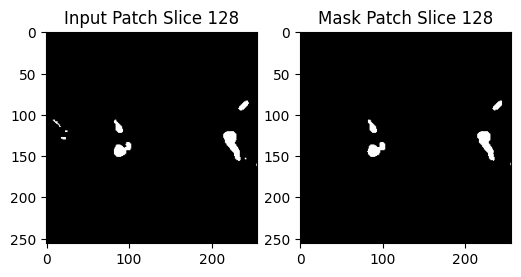

Testing:  90%|█████████ | 27/30 [00:32<00:04,  1.37s/it]

<Figure size 640x480 with 0 Axes>

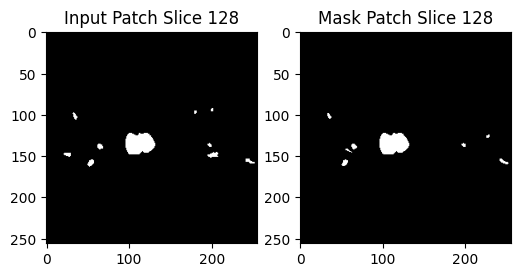

Testing:  93%|█████████▎| 28/30 [00:33<00:02,  1.39s/it]

<Figure size 640x480 with 0 Axes>

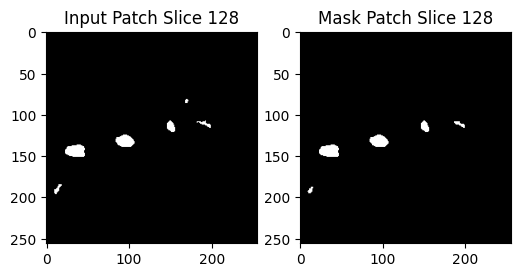

Testing:  97%|█████████▋| 29/30 [00:35<00:01,  1.42s/it]

<Figure size 640x480 with 0 Axes>

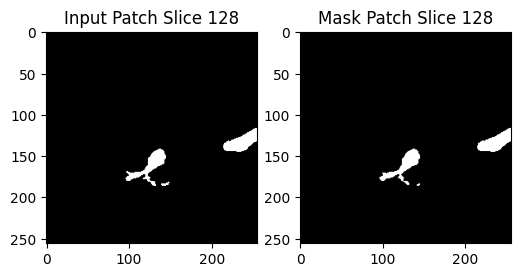

Testing: 100%|██████████| 30/30 [00:36<00:00,  1.23s/it]

Average Dice Loss on Test Set: 0.06787104010581971


In [ ]:
test_patch_loader = GPUPatchLoader(data_folders[20:], patches_per_vol=5, patch_size=256)
model_GPU.eval()

def visualize_patch(input_patch, mask_patch, slice_index=64):
    plt.clf()
    fig, axes = plt.subplots(1, 2, figsize=(6, 5))

    # Check if slice_index is valid for the current input_patch shape
    slice_index = min(slice_index, input_patch.shape[2] - 1)  # Assuming the slices are along dimension 2

    input_patch_np = input_patch[0, 0, slice_index].cpu().numpy()  # Accessing elements correctly
    axes[0].imshow(input_patch_np, cmap='gray')
    axes[0].set_title(f"Input Patch Slice {slice_index}")
    del input_patch_np

    mask_patch_np = mask_patch[0, 0, slice_index].cpu().numpy()  # Accessing elements correctly
    axes[1].imshow(mask_patch_np, cmap='gray')
    axes[1].set_title(f"Mask Patch Slice {slice_index}")
    del mask_patch_np

    plt.show()
    plt.close()

with torch.no_grad():
    total_dice_loss = 0
    for i in tqdm(range(len(test_patch_loader)), desc="Testing"):
        input_patch, mask_patch = test_patch_loader[i]
        input_patch = input_patch.unsqueeze(0).to(device)
        mask_patch = mask_patch.unsqueeze(0).to(device)

        output = model_GPU(input_patch)
        dice_loss_value = dice_loss(output, mask_patch).item()
        total_dice_loss += dice_loss_value

        visualize_patch(mask_patch.cpu(), output.cpu(), slice_index=128)

    average_dice_loss = total_dice_loss / len(test_patch_loader)
    print(f"Average Dice Loss on Test Set: {average_dice_loss}")
